# Drug Rates by U.S. State in Teens and Young Adults

**Names**: Sydney Casey, Jake Hunnius, Ben Leidig, Lily Novosel


## 1. Introduction - Sydney

The drugs dataset contains information about drug use for people in three different age groups across U.S. states. In this analysis we focus on comparing drug use rates vary by state for people aged 18-25. According to a study published in the National Library of Medicine, young adults are more likely to have substance abuse disorders than other age groups, but less likely to receive treatment (Substance Abuse and Mental Health Services Administration, 2025). Therefore, additional analysis is needed to understand what causes this discrepancy and whether patterns exist between particular states. It's important to understand drug use in developing adults to gain insight on which states face similar situations. From there, we can identify which states have the best and worst support programs for young adult drug users. State and federal legislators who are tracking funding for drug abuse programs would benefit from the findings in this cluster analysis. They could identify which groups of states face similar issues and decide whether the funding is being used effectively in the programs those states offer. The next steps would include contacting underperforming states to increase, decrease, or reallocate resources appropriately. If the clustering algorithm doesn't find all the inherent clusters, legislators would miss out on valuable, nuanced information on drug use within states. States with significantly different drug use rates could be grouped together, leading to program implementations or funding that don't properly meet the states' needs. Similarly, if the clustering algorithm erroneously splits an inherent cluster, states that actually face comparable patterns of young adult drug use could be treated differently, leading to inefficient or duplicate resource allocation. These analyses are important in understanding which types of U.S. states face similar drug use patterns, which drugs most strongly distinuish those patterns, or if there exist any states with vastly different drug use rates than the others. With this information, legislators can implement more personalized and effective programs to counter drug use in young adults.

First, we cluster the dataset with fuzzy c-means. Obtaining a fuzzy clustering result is beneficial in identifying clusters even if they are overlapping. We could also use each state's partial cluster membership to flag straddle states. Using this information, legislators could identify states that share drug use characteristics with several clusters and could benefit from a blend of the existing programs. Next we cluster the dataset using hierarchical agglomerative clustering with complete linkage. With this algorithm, we can quantify the nearness of clusters and identify any existing outliers. This will help answer the research question of whether any states exist with vastly different metrics than all other states, and which drugs most strongly distinguish existing patterns. From there, legislators can propose funding and program changes that aim to reduce drug abuse in young adults.

In this report, we discuss the structure of the dataset and how we extract the necessary information to perform a cluster analysis. We then perform basic descriptive analysis and determine whether to scale the data. Next, we use t-SNE to understand the clusterability of the dataset and select which clustering algorithms best identify the inherent clusters. We cluster the dataset using fuzzy c-means and hierarchical agglomerative clustering with complete linkage, analyzing the effectiveness of each algorithm and parameter tuning as necessary. We then compare the best result of each clustering algorithm and analyze which variables characterize each cluster. Finally, we address any shortcomings in the analysis and make a recommendation based on our key findings. 


In [2]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import adjusted_rand_score

import warnings
warnings.filterwarnings('ignore')


from skfuzzy.cluster import cmeans

from scipy.spatial.distance import pdist, squareform

## 2. Dataset Discussion - Lily

In [3]:
df = pd.read_csv('drugs.csv')
print(f'Original Dataset:\n{df.shape}')
display(df.head())
states = df['State'].unique().tolist()
df = df\
    .groupby('State').agg('mean')\
    .reset_index()\
    .drop(columns=[col for col in df.columns if (not col.startswith('Rates') or not col.endswith('.18-25')) and col != 'State'])
print(f'----------------\nModified Dataset:\n{df.shape}')
display(df.head())
X = df.select_dtypes([float, int]).to_numpy()

Original Dataset:
(867, 53)


State  Year  Population.12-17  Population.18-25  Population.26+  \
0     Alabama  2002            380805            499453         2812905   
1      Alaska  2002             69400             62791          368460   
2     Arizona  2002            485521            602265         3329482   
3    Arkansas  2002            232986            302029         1687337   
4  California  2002           3140739           3919577        21392421   

   Totals.Alcohol.Use Disorder Past Year.12-17  \
0                                           18   
1                                            4   
2                                           36   
3                                           14   
4                                          173   

   Totals.Alcohol.Use Disorder Past Year.18-25  \
0                                           68   
1                                           12   
2                                          117   
3                                           53   
4                                          581   

   Totals.Alcohol.Use Disorder Past Year.26+  \
0                                        138   
1                                         27   
2                                        258   
3                                        101   
4                                       1298   

   Rates.Alcohol.Use Disorder Past Year.12-17  \
0                                      48.336   
1                                      61.479   
2                                      73.819   
3                                      61.457   
4                                      55.109   

   Rates.Alcohol.Use Disorder Past Year.18-25  ...  \
0                                     136.490  ...   
1                                     187.891  ...   
2                                     193.626  ...   
3                                     175.913  ...   
4                                     148.312  ...   

   Totals.Marijuana.Used Past Year.26+  Rates.Marijuana.Used Past Year.12-17  \
0                                  141                               127.535   
1                                   46                               188.730   
2                                  215                               169.646   
3                                  104                               157.567   
4                                 1670                               141.067   

   Rates.Marijuana.Used Past Year.18-25  Rates.Marijuana.Used Past Year.26+  \
0                               237.880                              50.275   
1                               389.026                             124.566   
2                               275.435                              64.640   
3                               288.856                              61.510   
4                               282.887                              78.068   

   Totals.Tobacco.Use Past Month.12-17  Totals.Tobacco.Use Past Month.18-25  \
0                                   63                                  226   
1                                   11                                   30   
2                                   73                                  240   
3                                   46                                  169   
4                                  290                                 1377   

   Totals.Tobacco.Use Past Month.26+  Rates.Tobacco.Use Past Month.12-17  \
0                                930                             166.578   
1                                112                             163.918   
2                               1032                             151.071   
3                                660                             195.714   
4                               4721                              92.235   

   Rates.Tobacco.Use Past Month.18-25  Rates.Tobacco.Use Past Month.26+  
0                             451.976                           330.659  
1         

----------------
Modified Dataset:
(51, 9)


State  Rates.Alcohol.Use Disorder Past Year.18-25  \
0     Alabama                                  115.566235   
1      Alaska                                  148.890824   
2     Arizona                                  148.500118   
3    Arkansas                                  132.029059   
4  California                                  143.550471   

   Rates.Alcohol.Use Past Month.18-25  \
0                          514.068706   
1                          586.418471   
2                          565.915353   
3                          525.740412   
4                          569.151118   

   Rates.Tobacco.Cigarette Past Month.18-25  \
0                                343.957647   
1                                355.791176   
2                                302.728706   
3                                372.494765   
4                                253.590471   

   Rates.Illicit Drugs.Cocaine Used Past Year.18-25  \
0                                         39.954000   
1                                         61.621882   
2                                         67.284235   
3                                         41.915000   
4                                         64.952765   

   Rates.Marijuana.New Users.18-25  Rates.Marijuana.Used Past Month.18-25  \
0                        57.573647                             144.057882   
1                        84.826824                             237.804118   
2                        68.157059                             171.207471   
3                        62.762353                             154.143059   
4                        75.623824                             201.858588   

   Rates.Marijuana.Used Past Year.18-25  Rates.Tobacco.Use Past Month.18-25  
0                            243.660941                          423.839765  
1                            372.123529                          423.792706  
2                            284.355588                          354.066882  
3                            263.992529                          441.088588  
4                            324.389294                          293.485471

In the drugs dataset, there are a total of 867 rows before any data cleaning. This csv file was one of the three dataset options provided to us in the project specificiations folder. The full dataset can be found here at https://corgis-edu.github.io/corgis/csv/drugs/ and is provided to us via GitHub. The dataset was downloaded on 11/8/2025.

The rows of this dataset represent a single state observation for a specific year, between 2002 and 2018. The columns of the dataset report the population size , the total number of people with a drug use disorder, and usage rates per 1000 people for different age groups. This dataset comes from the National Survey on Drug Use and Health (NSDUH) and the data was collected from individual states. Because the NSDUH aggregates the data for each state with limited ages and drug types, the drugs dataset is not fully inclusive of all types of observations. We don't have access to each individual survey response, age groups younger than twelve, or drugs other than alcohol, marijuana, tobacco, and cocaine. We plan to only use the rate-based variables for each drug group, limited to the ages 18-25 while averaging across the years for each individual state. We chose to use rates rather than totals because rates would take into account the population size and create more meaningful comparisons across each state. Some states like Texas have a much higher population so using the pure totals can exaggerate the states drug use while rates can more accurately represent the state-by-state differences. This will enhance our understanding of the underlying groupings in the original dataset and help administrators revise drug use programs or reallocate funding more accurately. We also decided to focus on the ages 18-25 because not only is it more relevant to us as college students, but it also represents a population that is more vulnerable to developing drug use disorders. Not all drug rates contribute equally and can vary greatly across different states. This is why it's important for us to scale our variables so we know that certain rates don't dominate our unsupervised learning.

## 3. Dataset Cleaning and Exploration - Jake

Missing Value Detection and Cleaning
* Does your dataset have any missing values?
* If so, clean these missing values.
* Are there any downsides to cleaning the missing values in this particular way?

Outlier Identification - Two Variable Outliers (IF YOUR DATASET IS IMAGES, YOU CAN SKIP)
*For every pair of numerical explanatory variables that you're using, create a scatterplot.
* Are you able to detect any outliers in these plots?

Outlier Identification - 3+ Variable Outliers
*Use either a (KNN distance plot or a single linkage dendrogram) to look for outliers including
those that can only be seen in 3 or more dimensions.
* How many outlier/noise points are being suggested?

Outlier Consideration
*In the context of your research motivation, what do you think should be done with any
identified outliers? Explain.
- Should they be dropped? If so, what are some of the pros and cons of dropping these
outliers?
- Should they be clustered in their own singleton clusters?
- Should they be clustered with larger clusters that may happen to be further away?
* If you identified outliers in your dataset, does this impact the type of clustering algorithms
or clustering evaluation metrics that you might use in your analysis? Explain.

Noise Consideration and Identification
* Use a technique discussed in this class to determine if your dataset has any noise.
*In the context of your research motivation, what do you think should be done with any
identified noise? Explain.
* If you identified noise in your dataset, does this impact the type of clustering algorithms or
clustering evaluation metrics that you might use in your analysis? Explain.

Other Data Cleaning
* Were there any other data cleaning steps that you deemed suitable for this analysis? What
were they? Why did you choose to perform this additional data cleaning?
* If there are, do so here.
* If you dropped rows, how many did you drop?

- No missing values
- Show scatterplots with outliers (not full pairplot)
- Show KNN plot for outliers or single linkage
- Outlier treatment --> definitely don't outliers, will look into further analysis about what to do with outliers
- Explain why outliers impact clustering method choice
- Talk about noise in the dataset
- Grouped by state, taking mean of only the `Rate` columns (so average of each state + DC over all years)

The dataframe came with no missing values, so we did not need to drop any. Looking at our pairplot, there are some pretty strong outliers in multiple columns. However, since we combined our data in a way that makes each state its own row in the dataframe, it does not make sense to drop the outliers. Dropping the outliers would go against the goals of the client and essentially eliminate a few states from our analysis which we do not want to do. Since we want to use our clusters as a comparison metric for the states, we do not want any singleton clusters as this makes it harder to compare that state to any other similar states. Since there are outliers, our clustering algorithms are definitely impacted. We chose one of our algorithms to be Hierarchical Agglomerative Clustering, and choosing that to be single linkage means there will be singleton clusters. So to avoid the singleton clusters in our HAC model, we cannot use single linkage and instead have to use complete linkage. We also cannot use KMeans as that algorithm is also sensitive to outliers. There is some noise in the dataset, the inherent clusters we have show some bridge points, and the KNN plots are flat with a major increase right at the end. We don't want to ignore any noise points for similar reasons as not wanting to drop outliers. We want to make sure each state belongs to a cluster so we can compare. The noise and bridge points also impacted our clustering decisions as we chose to use fuzzy c-Means, so each point would have a membership score for each cluster. This gives us an even better gauge of where each state belongs relative to other states!

In order to make our data represent each state, we opted to take our full dataset, which was each state's information by year, and grouped them together at the state level, taking the mean of rate columns for 18-25 year olds. The end result of our data is 51 rows, one row for each state and then a row for Washington D.C., and 9 columns. The 9 columns we chose are the drug/alcohol rates, instead of the raw numbers.

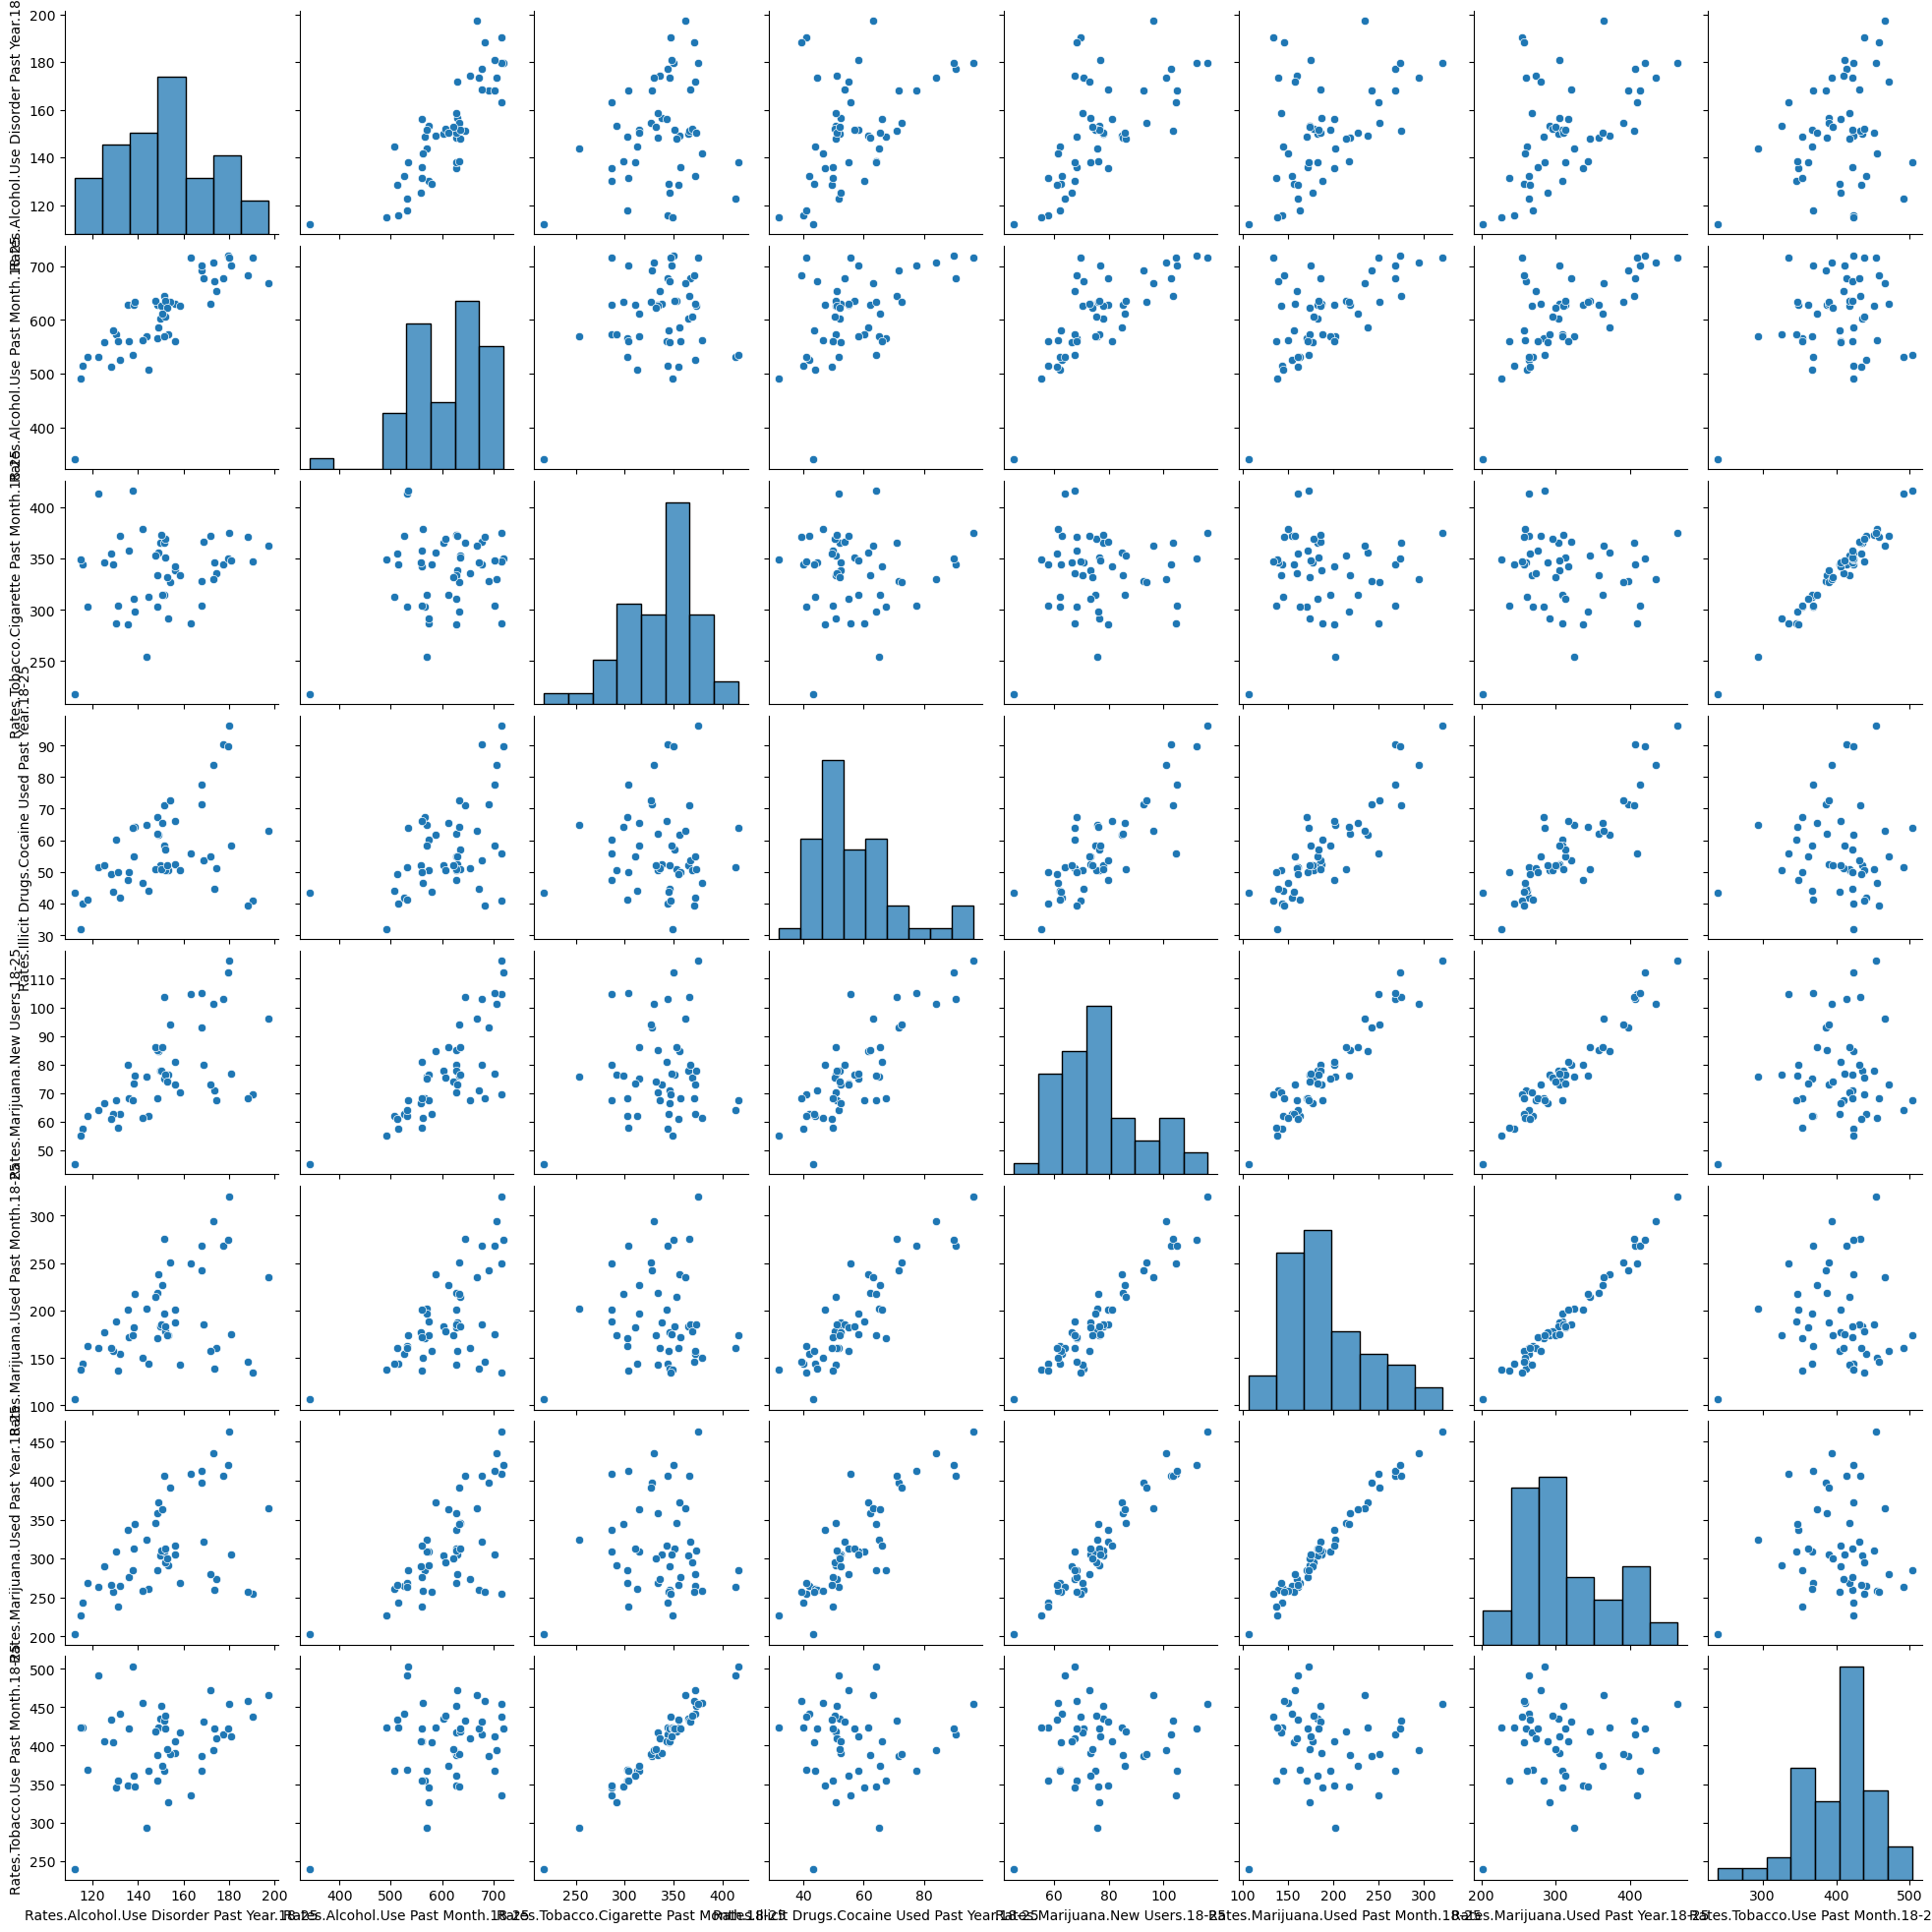

In [4]:
sns.pairplot(df)

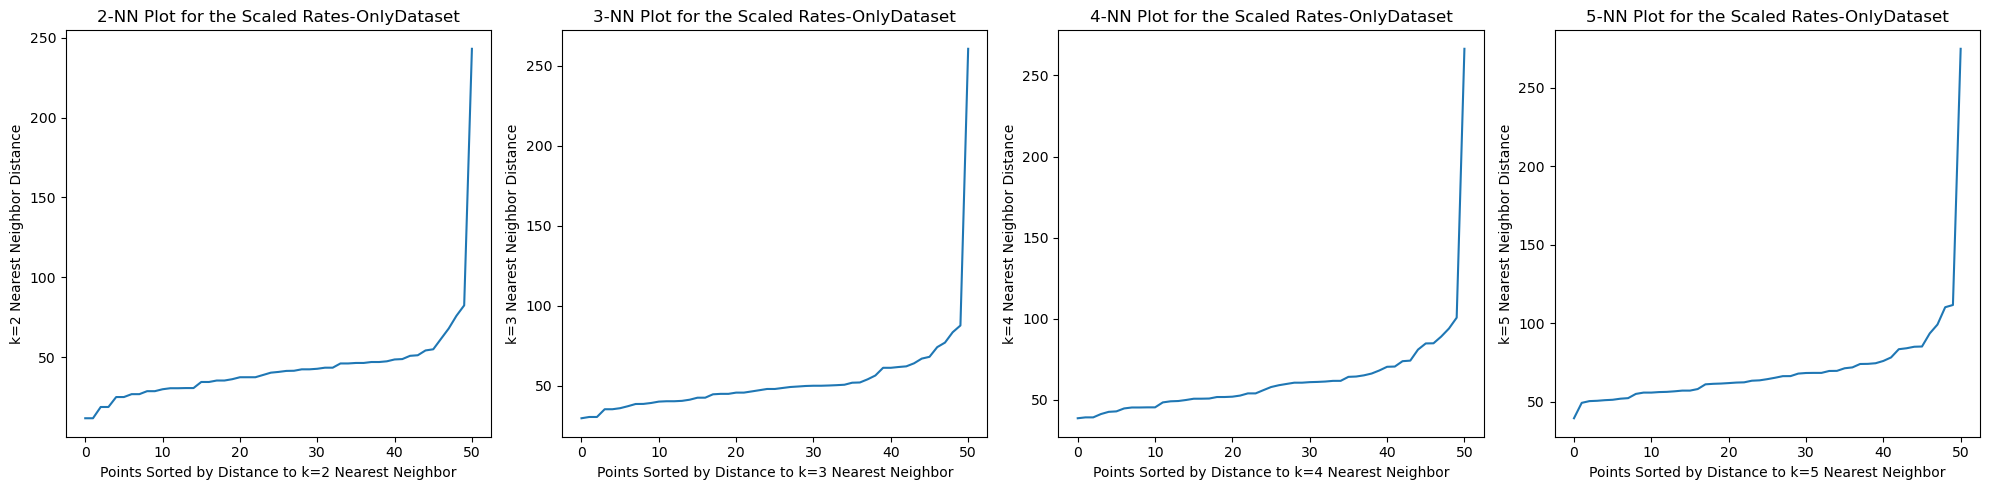

In [5]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
for i, k in enumerate(range(2, 6)):
    ax = axes[i]
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    ax.plot(np.sort(distances.T[k-1]))
    ax.set_xlabel(f'Points Sorted by Distance to k={k} Nearest Neighbor')
    ax.set_ylabel(f'k={k} Nearest Neighbor Distance')
    ax.set_title(f'{k}-NN Plot for the Scaled Rates-OnlyDataset')
plt.tight_layout()
plt.show()

## 4. Basic Descriptive Analytics

* For your numerical attributes, calculate basic summary statistics about each attribute.
* For any categorical attributes (including the pre-assigned class labels, if your dataset has
any) count up the number of observations of each type.
* Determine if there exist are any strong pairwise relationships between the variables in your
dataset.

In [6]:
df.describe()

Rates.Alcohol.Use Disorder Past Year.18-25  \
count                                   51.000000   
mean                                   151.180014   
std                                     20.703993   
min                                    112.112706   
25%                                    136.776941   
50%                                    150.447824   
75%                                    167.946176   
max                                    197.337765   

       Rates.Alcohol.Use Past Month.18-25  \
count                           51.000000   
mean                           608.283817   
std                             73.385034   
min                            341.518235   
25%                            561.290382   
50%                            626.430941   
75%                            660.910176   
max                            719.070647   

       Rates.Tobacco.Cigarette Past Month.18-25  \
count                                 51.000000   
mean                                 336.812463   
std                                   36.455172   
min                                  217.500529   
25%                                  313.347971   
50%                                  344.115235   
75%                                  359.764059   
max                                  416.169941   

       Rates.Illicit Drugs.Cocaine Used Past Year.18-25  \
count                                         51.000000   
mean                                          56.923988   
std                                           13.721890   
min                                           31.908882   
25%                                           49.608353   
50%                                           52.335824   
75%                                           64.073000   
max                                           96.149176   

       Rates.Marijuana.New Users.18-25  Rates.Marijuana.Used Past Month.18-25  \
count                        51.000000                              51.000000   
mean                         77.003473                             191.704674   
std                          15.543534                              46.823196   
min                          45.116118                             106.362765   
25%                          67.419735                             158.912676   
50%                          75.164235                             182.182059   
75%                          84.893559                             217.601029   
max                         116.202118                             320.629765   

       Rates.Marijuana.Used Past Year.18-25  \
count                             51.000000   
mean                             314.068905   
std                               59.846288   
min                              202.269941   
25%                              266.819118   
50%                              304.923824   
75%                              352.122706   
max                              463.680882   

       Rates.Tobacco.Use Past Month.18-25  
count                           51.000000  
mean                           402.758178  
std                             49.020099  
min                            239.186824  
25%                            368.080824  
50%                            411.663235  
75%                            433.696500  
max                            503.108176

In [7]:
df.corr(numeric_only=True)

Rates.Alcohol.Use Disorder Past Year.18-25  \
Rates.Alcohol.Use Disorder Past Year.18-25                                          1.000000   
Rates.Alcohol.Use Past Month.18-25                                                  0.834531   
Rates.Tobacco.Cigarette Past Month.18-25                                            0.222673   
Rates.Illicit Drugs.Cocaine Used Past Year.18-25                                    0.457238   
Rates.Marijuana.New Users.18-25                                                     0.630382   
Rates.Marijuana.Used Past Month.18-25                                               0.430995   
Rates.Marijuana.Used Past Year.18-25                                                0.492607   
Rates.Tobacco.Use Past Month.18-25                                                  0.286767   

                                                  Rates.Alcohol.Use Past Month.18-25  \
Rates.Alcohol.Use Disorder Past Year.18-25                                  0.834531   
Rates.Alcohol.Use Past Month.18-25                                          1.000000   
Rates.Tobacco.Cigarette Past Month.18-25                                    0.221744   
Rates.Illicit Drugs.Cocaine Used Past Year.18-25                            0.505765   
Rates.Marijuana.New Users.18-25                                             0.754886   
Rates.Marijuana.Used Past Month.18-25                                       0.601364   
Rates.Marijuana.Used Past Year.18-25                                        0.669568   
Rates.Tobacco.Use Past Month.18-25                                          0.263414   

                                                  Rates.Tobacco.Cigarette Past Month.18-25  \
Rates.Alcohol.Use Disorder Past Year.18-25                                        0.222673   
Rates.Alcohol.Use Past Month.18-25                                                0.221744   
Rates.Tobacco.Cigarette Past Month.18-25                                          1.000000   
Rates.Illicit Drugs.Cocaine Used Past Year.18-25                                  0.012980   
Rates.Marijuana.New Users.18-25                                                   0.089088   
Rates.Marijuana.Used Past Month.18-25                                             0.032565   
Rates.Marijuana.Used Past Year.18-25                                              0.006038   
Rates.Tobacco.Use Past Month.18-25                                                0.980361   

                                                  Rates.Illicit Drugs.Cocaine Used Past Year.18-25  \
Rates.Alcohol.Use Disorder Past Year.18-25                                                0.457238   
Rates.Alcohol.Use Past Month.18-25                                                        0.505765   
Rates.Tobacco.Cigarette Past Month.18-25                                                  0.012980   
Rates.Illicit Drugs.Cocaine Used Past Year.18-25                                          1.000000   
Rates.Marijuana.New Users.18-25                                                           0.831308   
Rates.Marijuana.Used Past Month.18-25                                                     0.879689   
Rates.Marijuana.Used Past Year.18-25                                                      0.864393   
Rates.Tobacco.Use Past Month.18-25                                                        0.001767   

                                                  Rates.Marijuana.New Users.18-25  \
Rates.Alcohol.Use Disorder Past Year.18-25                               0.630382   
Rates.Alcohol.Use Past Month.18-25                                       0.754886   
Rates.Tobacco.Cigarette Past Month.18-25                                 0.089088   
Rates.Illicit Drugs.Cocaine Used Past Year.18-25                         0.831308   
Rates.Marijuana.New Users.18-25                                          1.000000   
Rates.Marijuana.Used Past Month.18-25                                    0.946209   
Rates.Marijuana.Used Past Year.

The points with the highest correlation:
- marijuana used in the last year with marijuana in the last month $\approx$ 0.9867
- tobacco in the pst month with cigarettes in the past month $\approx$ 0.9804
- marijuana used in the last month with new marijuana users at $\approx$ 0.9658
- marijuana used in the last month with new marijuana users at $\approx$ 0.9462
- cocaine used in the past year with marijuana used in the past month $\approx$ 0.8797
- alcohol in the past year with alcohol in the past month $\approx$ 0.8345
- cocaine in the past year with marijuana in the past month at $\approx$ 0.8793
- cocaine in the past year with new marijuana users at $\approx$ 0.8313
- cocaine in the past year with marijuana in the past year at $\approx$ 0.8644
- alcohol in the past month with new marijuana user at $\approx$ 0.7549
- alcohol in the past month with marijuana in the past year at $\approx$ 0.6696
- alcohol in the past month with marijuana in the past month at $\approx$ 0.6014

## 5. Scaling Decisions

From your analyses conducted here, discuss whether you should scale the dataset or not.
Explain why or why not. If you choose to scale, then do so in this section here.

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=df.columns[1:])

We chose to scale the data because as we saw in our descriptive statistics that there were very different standard deviations for each column. Scaling the data minimizes the impact that the vastly different standard deviations would have on our clustering structure.

## 6. Clusterability and Clustering Structure - Ben

t-SNE Plots + Clusterability Check
* Create some appropriate t-SNE plots (6 perplexity values, 2 random states each).
* Select a representative t-SNE plot that displays similar patterns seen across many plots.

Describe the Underlying Clustering Structure of the Dataset
What do your t-SNE plots suggest about the following:
* Is your dataset clusterable? (THE ANSWER TO THIS SHOULD BE YES)
* Approximately how many underlying clusters does the data have?
* What are the shapes of the underlying clusters?
* Are the clusters balanced in size?
* Are there are any clusters that are not well-separated?
* Is there any evidence of nested cluster relationships in this dataset?

Clustering Structure and Attribute Association
* Is there an association between each of the attributes and the clustering structure
suggested by the t-SNE plot? Show the appropriate visualizations to explain. (That is, you
should color-code your t-SNE plot by each of your attributes and talk about the amount of
association between the attribute labels and the t-SNE plot suggested clusters).

Understanding the t-SNE algorithm
* Caution your reader about 4 original dataset properties that your t-SNE plots are not able to reveal or represent.

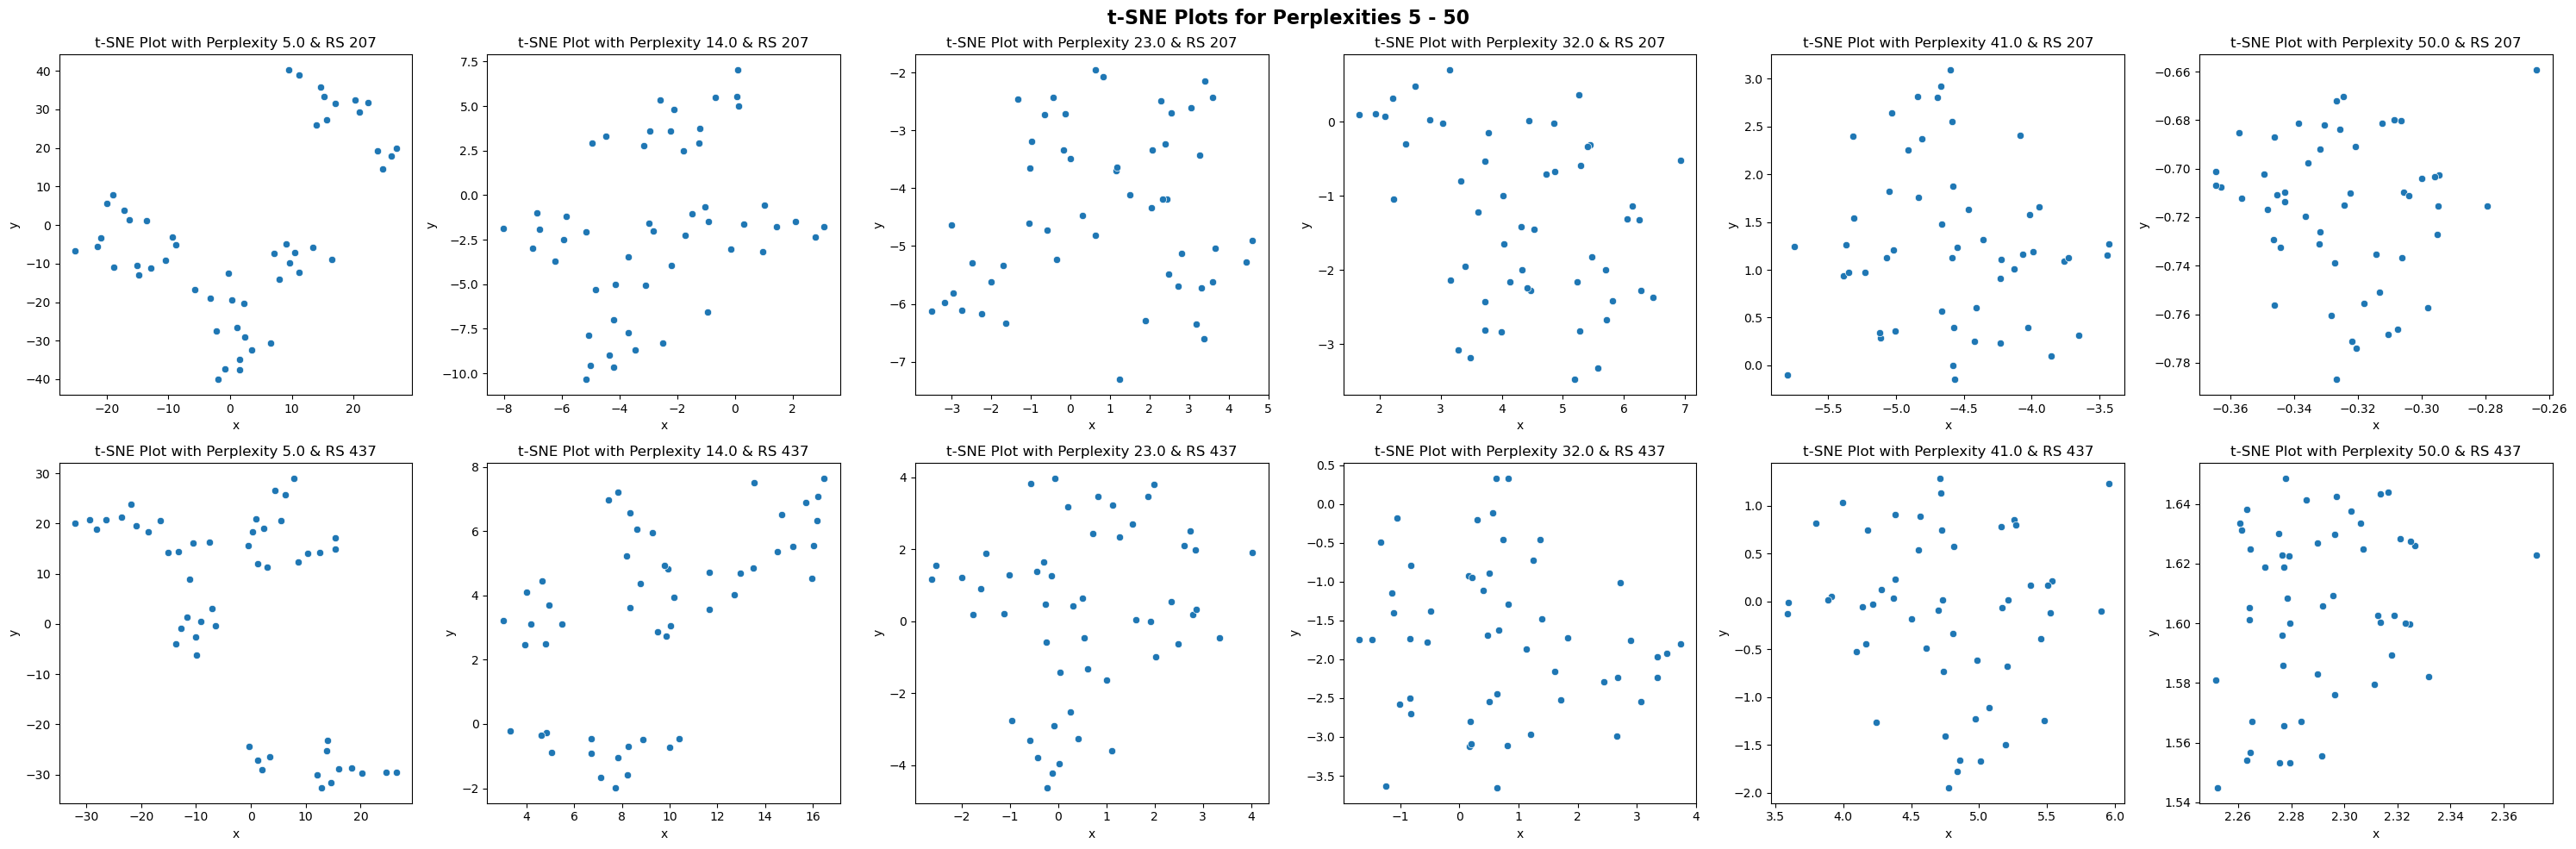

In [9]:
## 5 - 50 PERPLEXITY
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(30, 10))
for col, perp in enumerate(np.linspace(5, 50, 6)):
    for row, rs in enumerate((207, 437)):
        ax = axes[row, col]
        tsne = TSNE(
            n_components=2, init='random',
            perplexity=perp, random_state=rs
        )
        data_tsne = tsne.fit_transform(df_scaled)
        df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])
        sns.scatterplot(x='x', y='y', data=df_tsne, ax=ax)
        ax.set_title(f't-SNE Plot with Perplexity {perp} & RS {rs}')
fig.suptitle('t-SNE Plots for Perplexities 5 - 50', fontsize=16, fontweight='bold')
fig.tight_layout()
plt.show()

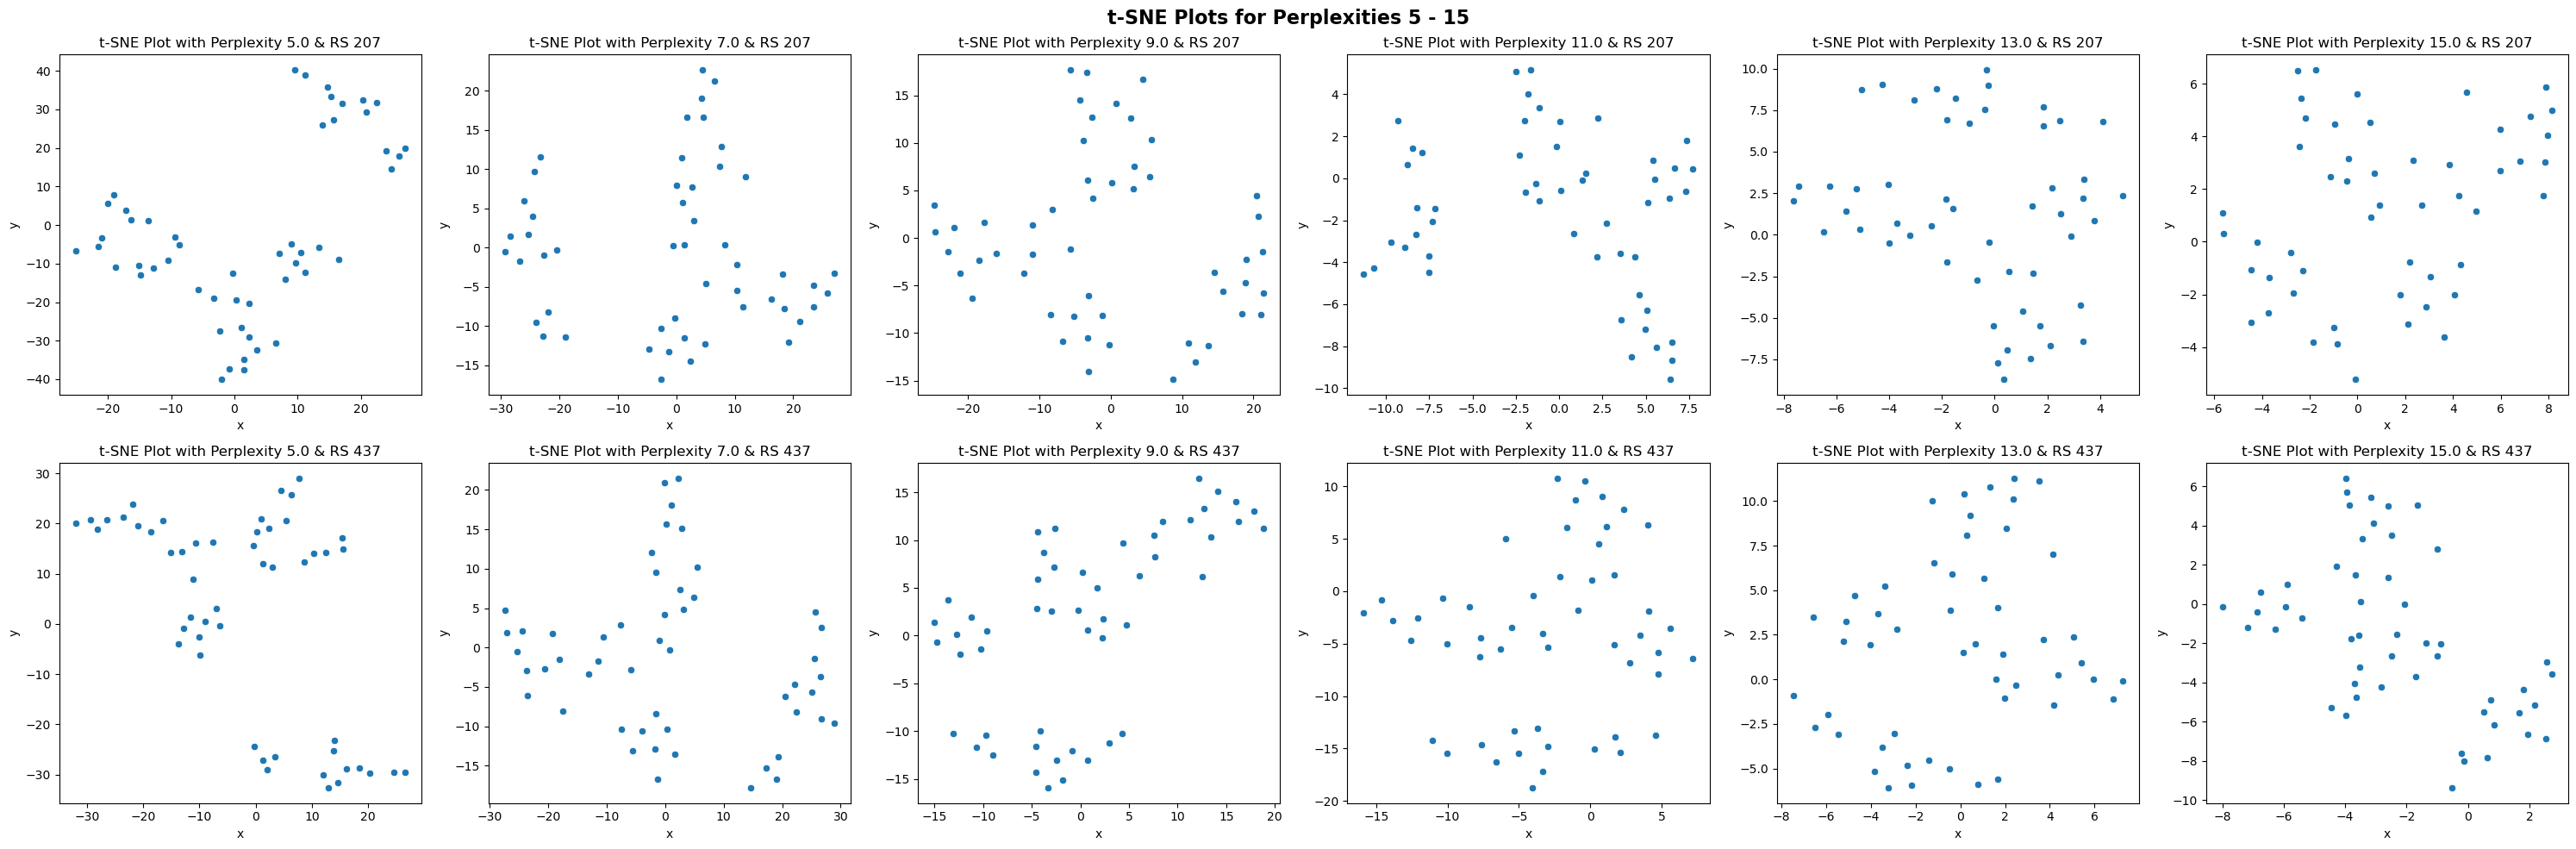

In [10]:
## 5 - 15 PERPLEXITY
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(30, 10))
for col, perp in enumerate(np.linspace(5, 15, 6)):
    for row, rs in enumerate((207, 437)):
        ax = axes[row, col]
        tsne = TSNE(
            n_components=2, init='random',
            perplexity=perp, random_state=rs
        )
        data_tsne = tsne.fit_transform(df_scaled)
        df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])
        sns.scatterplot(x='x', y='y', data=df_tsne, ax=ax)
        ax.set_title(f't-SNE Plot with Perplexity {perp} & RS {rs}')
fig.suptitle('t-SNE Plots for Perplexities 5 - 15', fontsize=16, fontweight='bold')
fig.tight_layout()
plt.show()

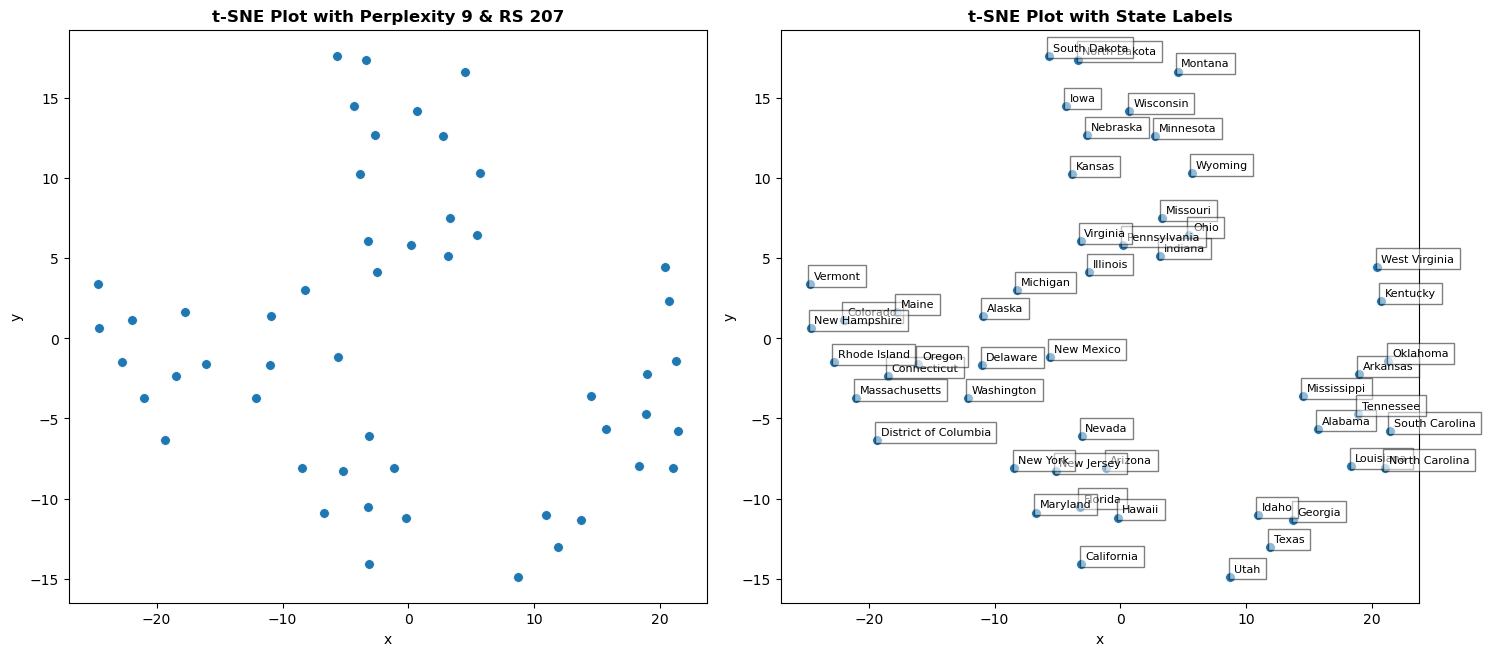

In [11]:
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10*(2/3)))
tsne = TSNE(
    n_components=2, init='random',
    perplexity=9, random_state=207
)
X_tsne = tsne.fit_transform(X_scaled)
df_tsne = pd.DataFrame(X_tsne, columns=['x', 'y'])

sns.scatterplot(x='x', y='y', data=df_tsne, ax=ax0, s=50)
ax0.set_title('t-SNE Plot with Perplexity 9 & RS 207', fontweight='bold')

sns.scatterplot(x='x', y='y', data=df_tsne, ax=ax1, s=50)
ax1.set_title('t-SNE Plot with State Labels', fontweight='bold')
for i in range(df_tsne.shape[0]):
    ax1.text(
        x=df_tsne.loc[i, 'x']+0.3, y=df_tsne.loc[i, 'y']+0.3,
        s=states[i],
        fontdict=dict(color='black', size=8), bbox=dict(facecolor='white', alpha=0.5)
    )

plt.tight_layout()
plt.show()

First, twelve different t-SNE plots were made, each with a different perplexity value or random state value, between perplexities five through fifty. However, since there are only fifty-one observations in the dataset (the fifty United States plus the District of Columbia), high perplexity values (i.e., near fifty) approach $n$, the number of observations in the dataset. Accordingly, these t-SNE plots show little clustering structure. So, twelce new t-SNE plots were again made, but this time with perplexities spanning from five to fifteen, only. These plots demonstrate a clear clustering structure. The representative t-SNE plot, with a perplexity of 9 (and random state of 207), shows roughly four clusters. These "main" clusters are approximately spherical or elongated ovoidal. Each cluster is also approximately balanced in the number of observations. There also appear to be at least two clusters that are not well-separated. Within two of the main clusters, there seem to be at least two "subclusters" in both. 

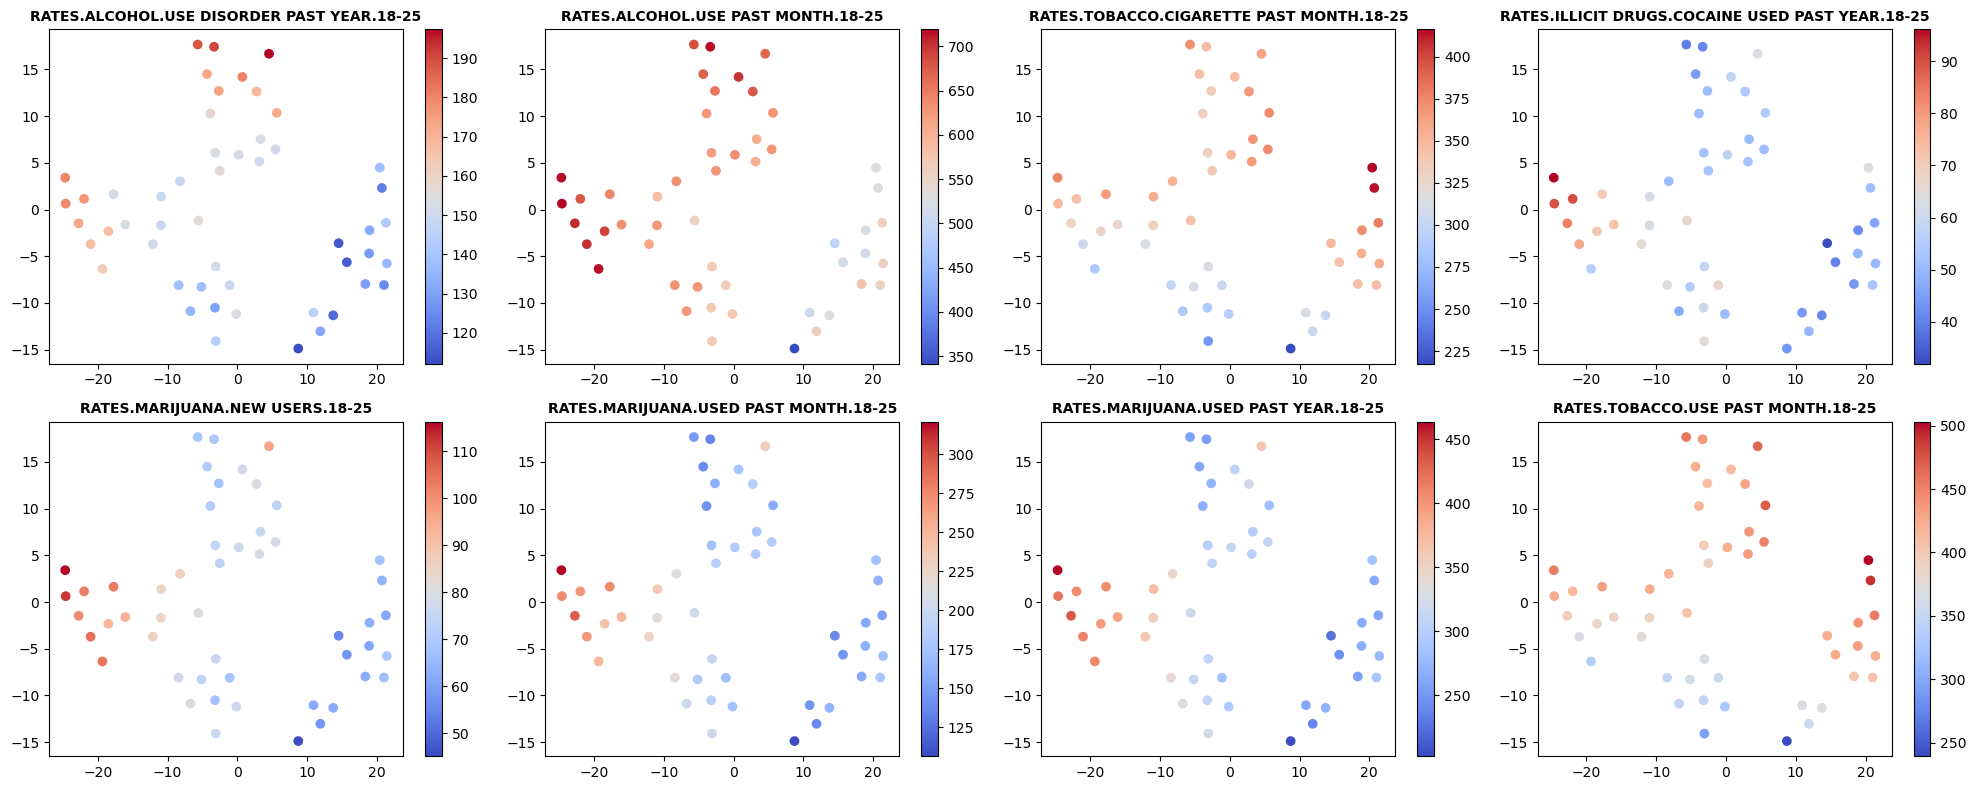

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
axes = axes.flatten()
for i, col in zip(range(df.drop(columns='State').shape[1]), df.columns[1:]):
    ax = axes[i]
    sc = ax.scatter(df_tsne['x'], df_tsne['y'], c=df[col], cmap='coolwarm')
    fig.colorbar(sc, ax=ax)
    ax.set_title(col.upper(), fontsize=10, fontweight='bold')
fig.tight_layout()
plt.show()

There does seem to be some association between the inherent clusters suggested by the t-SNE plot and the variables in the original dataset. First, for alcohol user disorder and similarly for alcohol usage in the past month, the top-left and bottom-right clusters have the highest rates. Second, for tobacco and cigarette usage, the top-left, bottom-left, and bottom-right plots have the highest rates. Lastly, for cocaine and marijuana usage, the bottom right cluster has the highest rates.

Often, t-SNE plots are used for interpreting whether there exists a clustering structure, the approximate shape of clusters, the approximate number of clusters, the approximate number of objects in each cluster, and whether or not clusters are separated in the original dataset. However, t-SNE plots, including the ones created for this analysis, do not accurately elucidate the distance between objects, the distance between clusters, the centroid or any other summary statistics of clusters, the sparsity of clusters, and the existence of noise or outliers in the original dataset. Accordingly, the aforementioned characteristics should not be inferred from t-SNE, nor can t-SNE be used as corroborating evidence for these characteristics.

## 7. Clustering Algorithm Selection Motivation

The first clustering algorithm we selected was HAC with complete linkage. Based on our initial data exploration, we saw in our tSNE plot evidence that the inherent clusters were not well-separated. Based on both the sns pairplot and KNN plots, we identified at least one significant outlier as well. Putting this altogether, we decided to choose HAC complete linkage as one of our clustering algorithms in our unsupervised learning. Our rationale in using this was mainly based on the lack of separation between the clusters in our tSNE plot. Out of all of the algorithms discussed in class, HAC with complete linkage tends to perform the best in the presence of non-well separated clusters. It is also one of the most robust algorithms in terms of outliers, giving us a much better chance at identifying the larger inherent clusters rather than producing singleton clusters. In our unsupervised learning for the drugs dataset, we wish to understand the underlying differences and similarities between the states and their corresponding drug rates for the age group 18-25. We chose HAC complete linkage because it might help us achieve these goals despite some of the shortcomings found in the structure of the dataset. It may also be beneficial to have a clustering algorithm that is deterministic to make sure that the findings policy makers rely on are reproducible and aren't misinterpreted because of the algorithm's randomness.

The second clustering algorithm we selected is fuzzy c-means. Based on the t-SNE plots, we determined that there were possibly overlapping clusters, which fuzzy c-means is able to identify. The t-SNE plots also suggest clusters are approximately balanced in size and have even sparsities, which are ideal properties for fuzzy c-means. Furthermore, based on the pairplots, there appears to be one outlier. Ideally, fuzzy c-means clustering will classify this outlier as its own distinct cluster while providing more nuanced information on the other states. If this does not happen, and instead the outlier is grouped into a larger cluster, the fuzzy c-means membership score will provide useful information about how well the outlier fits into its cluster, and therefore how similar the states are in terms of young adult drug abuse. The most significant hesitation for using this algorithm is that the t-SNE plots indicate that the clusters may not be completely spherical. However, they appear spherical enough that fuzzy c-means should still succeed. Fuzzy c-means will help identify which clusters of states are nearest each other, answering the research question of which states share drug abuse characteristics and therefore could benefit from shared programs for young adults. Compared to other algorithms like k-means, fuzzy c-means should provide the most nuanced information about the overlapping clusters and partial memberships, which are essential for legislators to implement the most effective programs and funding for each state. 

## 8. Clustering Algorithm #1 - Complete Linkage (lily, ben)



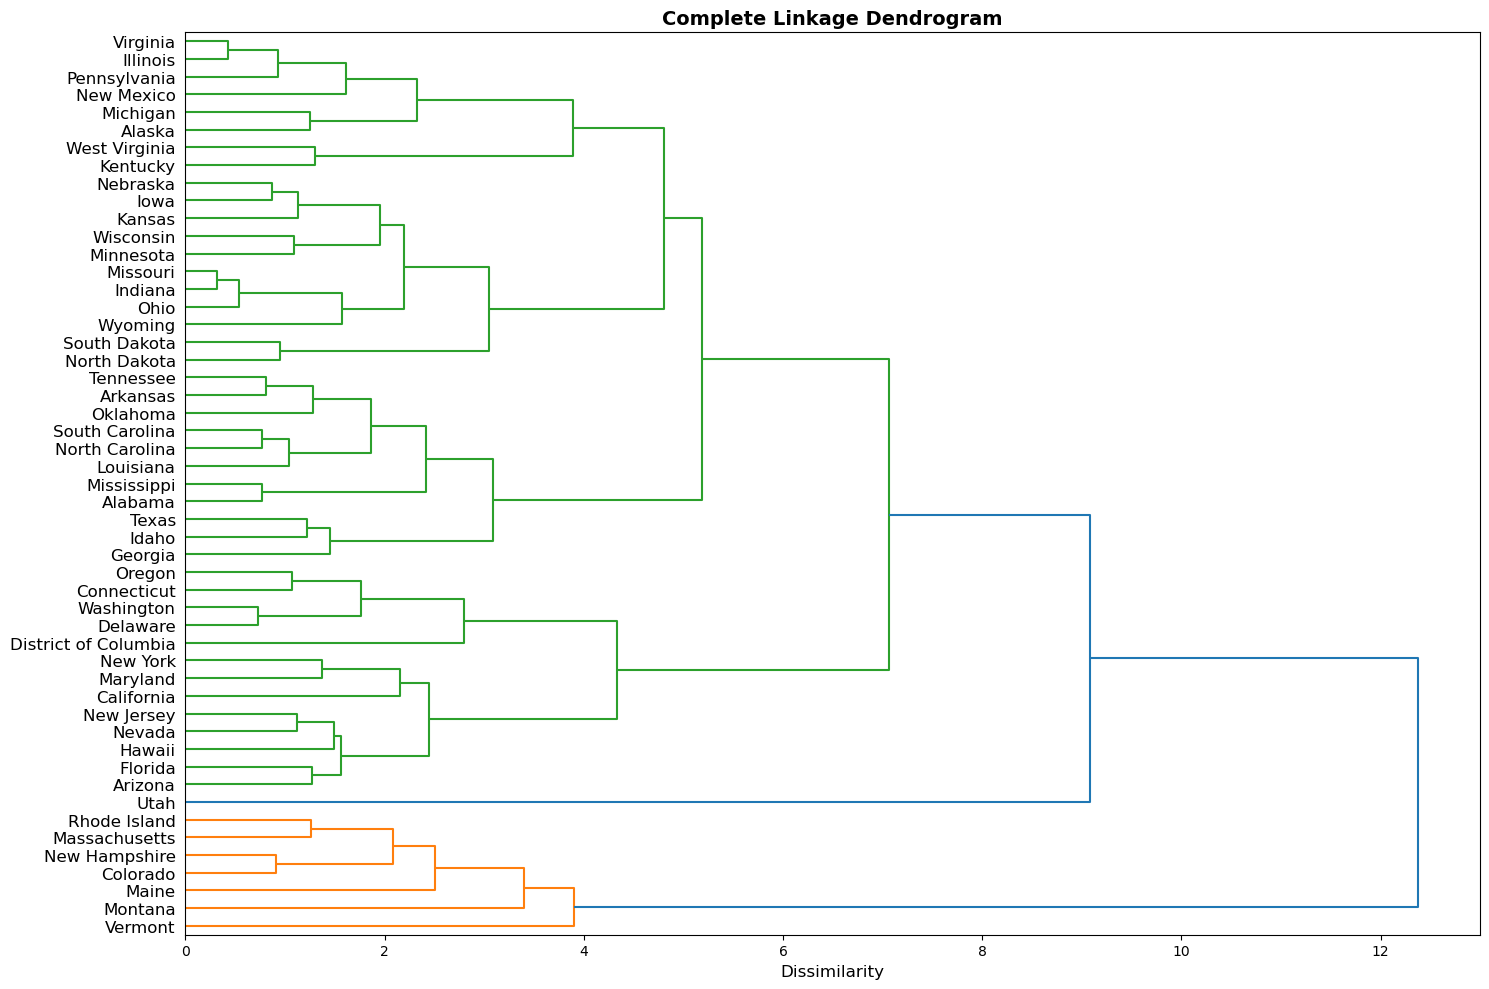

In [13]:
fig, ax = plt.subplots(ncols=1, figsize=(15, 10))
dm = pdist(X_scaled, metric='euclidean')

Z = linkage(dm, method='complete')
d = dendrogram(Z, orientation='right', labels=states, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=12)
ax.set_title('Complete Linkage Dendrogram', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)

fig.tight_layout()
plt.show()

Instead of using an elbow plot to interpret for Hierarchical Agglomerative Clustering (HAC) with Complete Linkage, we created the dendrogram above. It shows the presence of one outlier singleton cluster that splits off at $k=3$ clusters. This observation is the state of Utah. Overall, it looks like there are three or four main clusters (including thje one singleton cluster).

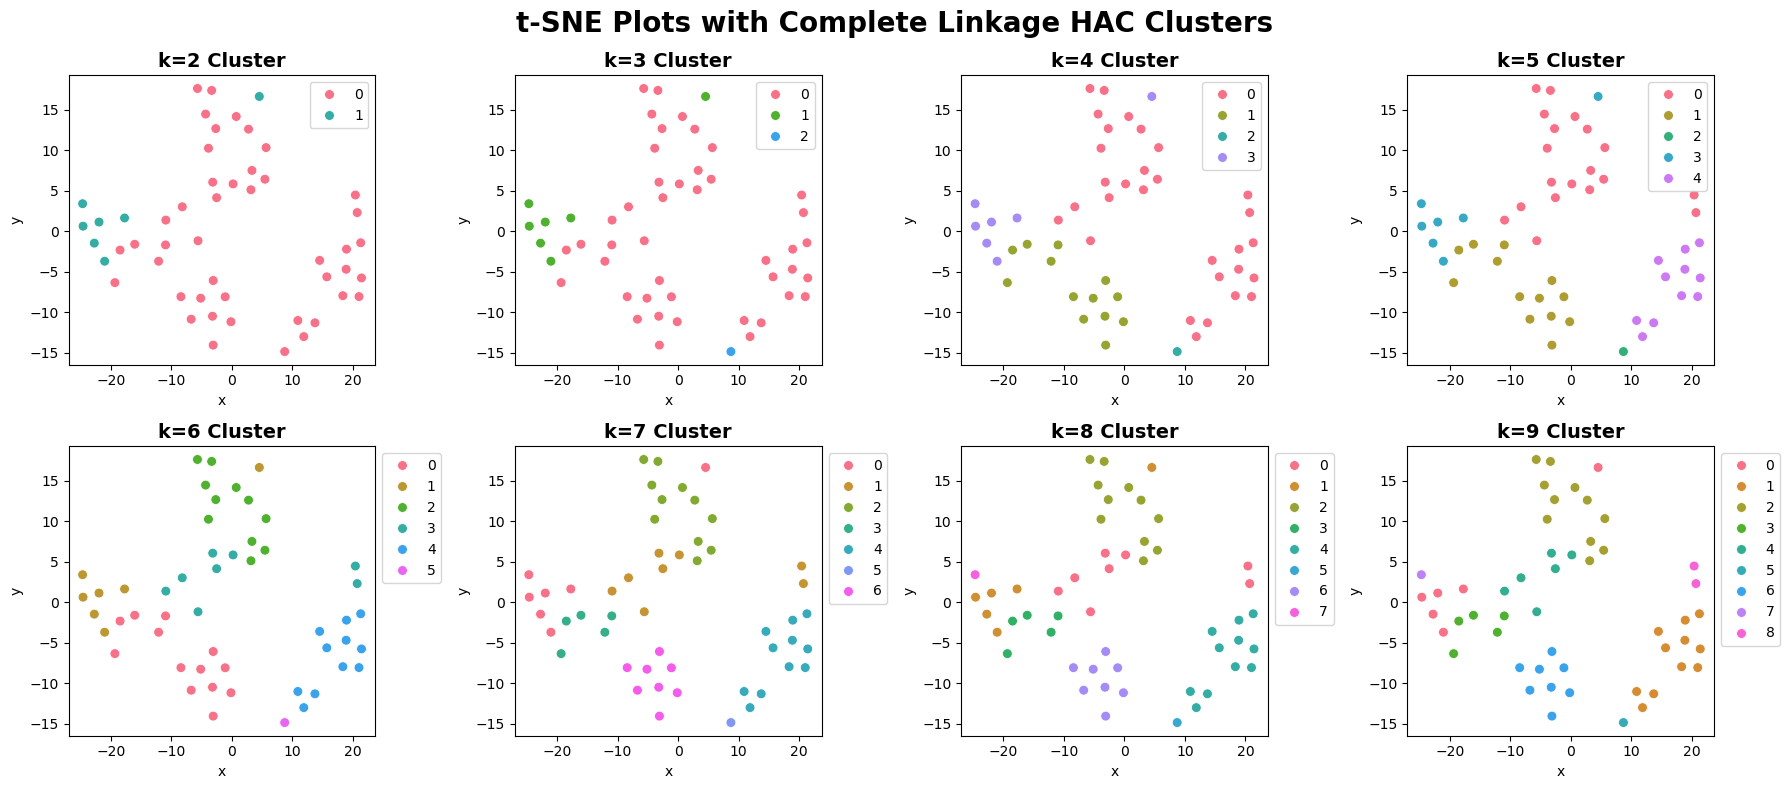

In [14]:
max_k = 9 # MAX CLUSTERS
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
axes = axes.flatten()

for k in range(2, max_k+1):
    hac = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='complete')
    predicted_cluster = hac.fit_predict(X_scaled)
    ax = axes[k-2]

    sns.scatterplot(
        x='x', y='y',
        hue=predicted_cluster, palette=sns.color_palette("husl", k),
        data=df_tsne, s=50, ax=ax
    )

    ax.set_title(f'k={k} Cluster', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1, 1))

fig.suptitle('t-SNE Plots with Complete Linkage HAC Clusters', fontsize=20, fontweight='bold')
fig.tight_layout()
plt.show()

The clustering from HAC with Complete Linkage that has the most corroboration with the t-SNE plots is when $k=5$ clusters. However, it looks like the algorithm is misidentifying a few points on the outskirts of the cluisters. Importantly, it also identifies the smallest cluster (or, arguably, a subcluster of a main cluster) as being part of another main cluster. This clustering does have the added benefit of identifying one outlier, Utah, as it's own cluster, which aligns with our research goal since this state has by far the lowest druge abuse rates. This fact draws a clear and meaningful demarcation between Utah and other states in the dataset, which would be beneficial for our research goals because it shows that Utah does not require increases in funding for young adult drug abuse programs.

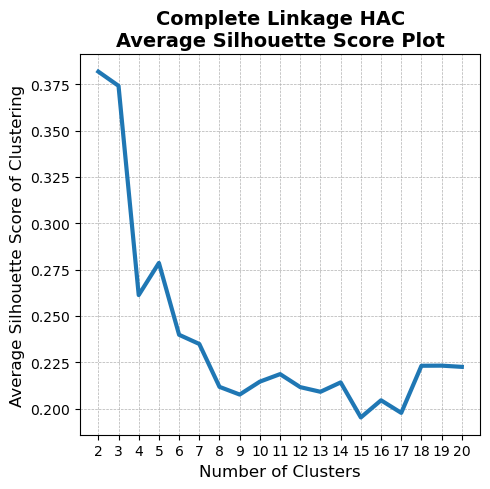

In [15]:
max_k = 20 # MAX CLUSTERS
fig, ax = plt.subplots(figsize=(5, 5), sharey=True)
avg_ss = []
for k in range(2, max_k+1):
    hac = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='complete')
    y_pred = hac.fit_predict(X_scaled)
    avg_ss.append(silhouette_score(X_scaled, y_pred))

ax.plot([_ for _ in range(2, max_k+1)], avg_ss, linewidth=3)
ax.set_title(f'Complete Linkage HAC\nAverage Silhouette Score Plot', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Clusters', fontsize=12)
ax.set_xticks([i for i in range(2, max_k+1)])
ax.grid(True, linewidth=0.5, linestyle='--')
ax.set_ylabel('Average Silhouette Score of Clustering', fontsize=12)
fig.tight_layout()
plt.show()

The HAC Complete Linkage clustering with $k=\{2,3\}$ clusters have by far the highest average silhoutte scores, followed far behind by $k=5$ clusters. When viewing the $k=2$ clustering against our t-SNE plot, we see that (according to the t-SNE algorithm), only one main cluster was mostly identified. This issue persists for $k=3$ clusters, although one singleton outlier cluster has now been added. Thus, these two clustering are unlikely to be identifying the main clusters in the dataset. However, at $k=5$ clusters, the clustering with the third highest average silhouette score, we see the best corroboration with the t-SNE-identified inherent clusters in the dataset (as examine above).

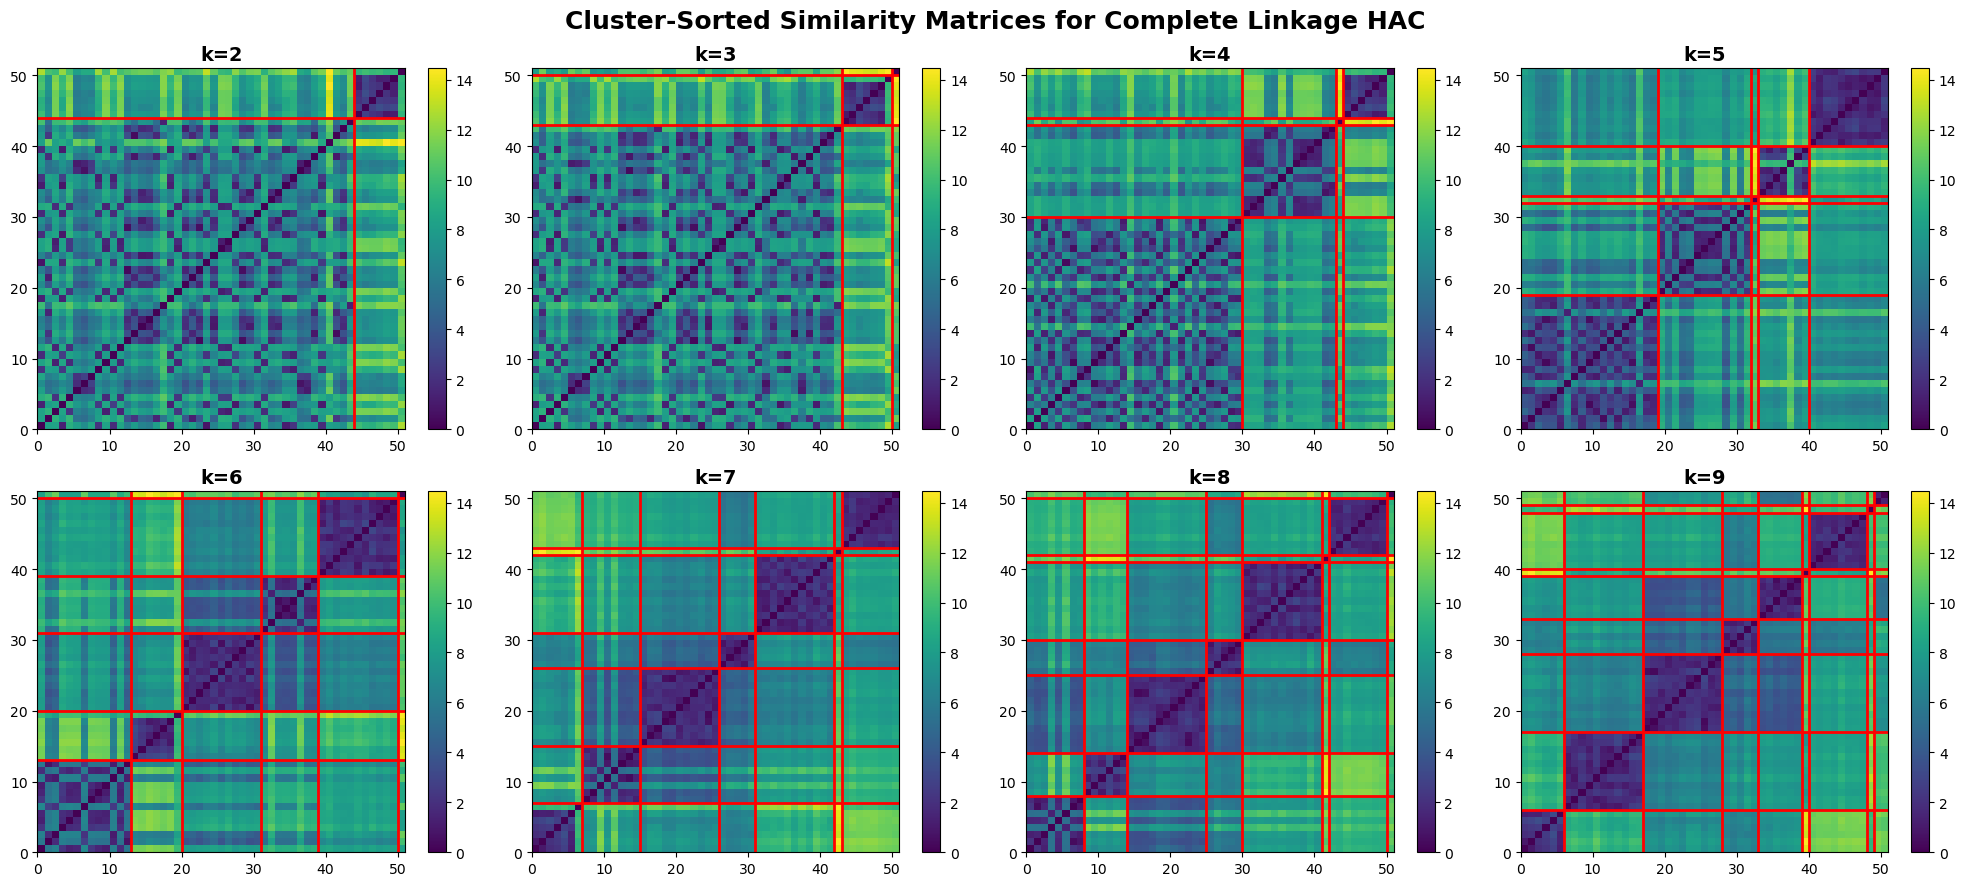

In [16]:
max_k = 9 # MAX CLUSTERS
df_scaled_complete = df_scaled.copy(deep=True)
for k in range(2, max_k+1):
    hac = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='complete')
    df_scaled_complete[f'predicted_cluster_k{k}'] = hac.fit_predict(X_scaled)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 9))
axes = axes.flatten()

for k in range(2, max_k+1):
    ax = axes[k-2]
    df_sort = df_scaled_complete.sort_values(f'predicted_cluster_k{k}', ascending=True)
    dist_mat = squareform(pdist(df_sort.select_dtypes([int, float])))
    bounds = np.flatnonzero(np.diff(df_sort[f'predicted_cluster_k{k}'].to_numpy())) + 1
    im = ax.pcolormesh(dist_mat)
    fig.colorbar(im, ax=ax)
    N = len(df_sort)
    ax.vlines(bounds, 0, len(df_sort), colors='red', lw=2)
    ax.hlines(bounds, 0, len(df_sort), colors='red', lw=2)
    ax.set_xlim([0,N])
    ax.set_ylim([0,N])
    ax.set_title(f'k={k}', fontweight='bold', fontsize=14)

fig.suptitle('Cluster-Sorted Similarity Matrices for Complete Linkage HAC', fontsize=18, fontweight='bold')
fig.tight_layout()
plt.show()

According to the cluster-sorted similarity matrics for HAC with Complete Linkage, the clustering with $k=9$ clusters demonstrates the most cohesion and separation. A few other clusterings are noteworthy, however:
* $k=5$ : demonstrates comparatively good separation but poor cohesion;
* $k=6$ : demonstrates comparatively good separation but only mnarginally better cohesion than when $k=5$ clusters;
* $k=\{7,8\}$ : demonstrate comparatively good separation and only marginally worse cohesion than when $k=9$ clusters.

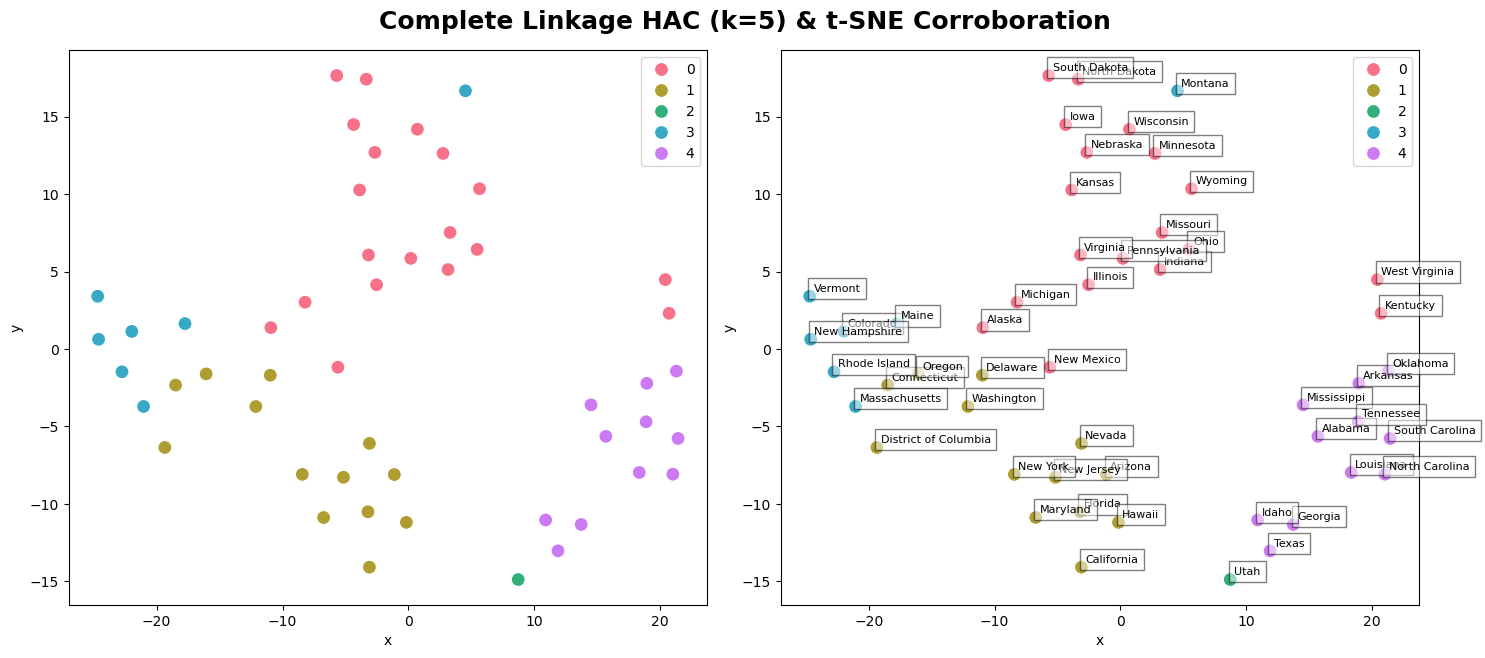

In [17]:
k = 5 # CLUSTERS
hac = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='complete')
predicted_cluster = hac.fit_predict(X_scaled)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10*(2/3)))

sns.scatterplot(
    x='x', y='y', hue=predicted_cluster,
    palette=sns.color_palette("husl", k), data=df_tsne, ax=ax0, s=100
)

sns.scatterplot(x='x', y='y', hue=predicted_cluster, palette=sns.color_palette("husl", k), data=df_tsne, ax=ax1, s=100)

for i in range(df_tsne.shape[0]):
    ax1.text(
        x=df_tsne.loc[i, 'x'] + 0.3, y=df_tsne.loc[i, 'y'] + 0.3,
        s=states[i],
        fontdict=dict(color='black', size=8), bbox=dict(facecolor='white', alpha=0.5)
    )

fig.suptitle(f'Complete Linkage HAC (k={k}) & t-SNE Corroboration', fontsize=18, fontweight='bold')
fig.tight_layout()
plt.show()

The clustering from HAC with Complete Linkage that we believe provides the evidence that we have identified all the inherent clusters is when $k=5$ clusters. The identified clusters have the most corroboration with the t-SNE suggested inherent clusters, despite a few points misaligning between the two algorithms' suggestions. Additionally, this clustering also had the third highest average silhouette score and demonstrates respectively good separation and moderate cohesion in the cluster-sorted similarity matrices. For this reason, and the fact that Utah is correctly identified as an extreme low-end outlier, make this clustering also the most informative and aligned with our research goals. We can see in the state-labelled t-SNE plot color-coded with cluster labels that most clusters align with geographic regions or similarities. This also serves as evidence that this clustering is providing informative information on our research goal to identify regions in most need of young adult drug abuse program funding.

It is also important to mention a few shortcomings in our techniques applied. Since there is at least one significant outlier and the dendrogram shows at least one inherent cluster being significantly further from others, the average silhouette score plot might not work the best for identifying the inherent number of clusters in the dataset. Additionally, it has been noted before that there may exist subclusters in our dataset. This fact could confound the results from our cluster-sorted similarity matrices, which suggest $k=9$ clusters. Overall, however, since our clusters appear to be roughly spherical, the cluster-sorted similarity matrices still showed respectively good separation and decent cohesion for $k=5$ clusters.

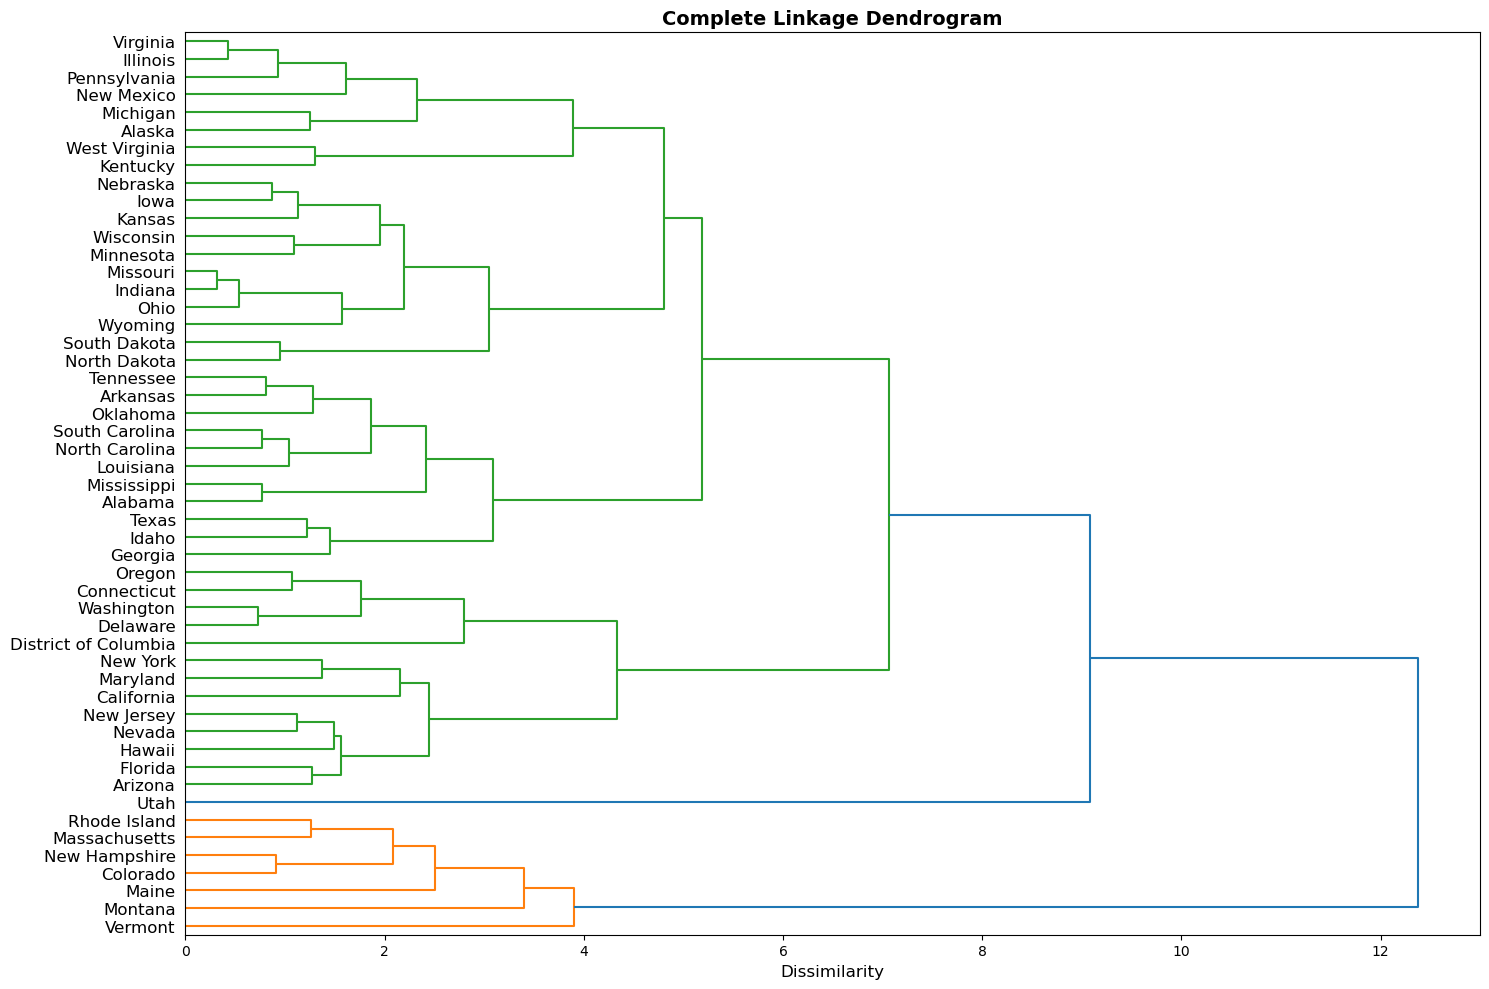

In [18]:
fig, ax = plt.subplots(ncols=1, figsize=(15, 10))
dm = pdist(X_scaled, metric='euclidean')

Z = linkage(dm, method='complete')
d = dendrogram(Z, orientation='right', labels=states, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=12)
ax.set_title('Complete Linkage Dendrogram', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)

fig.tight_layout()
plt.show()

## 9. Clustering Algorithm #2 - Fuzzy c-Means (jake, sydney)

### Fuzzy c-Means Elbow Plots

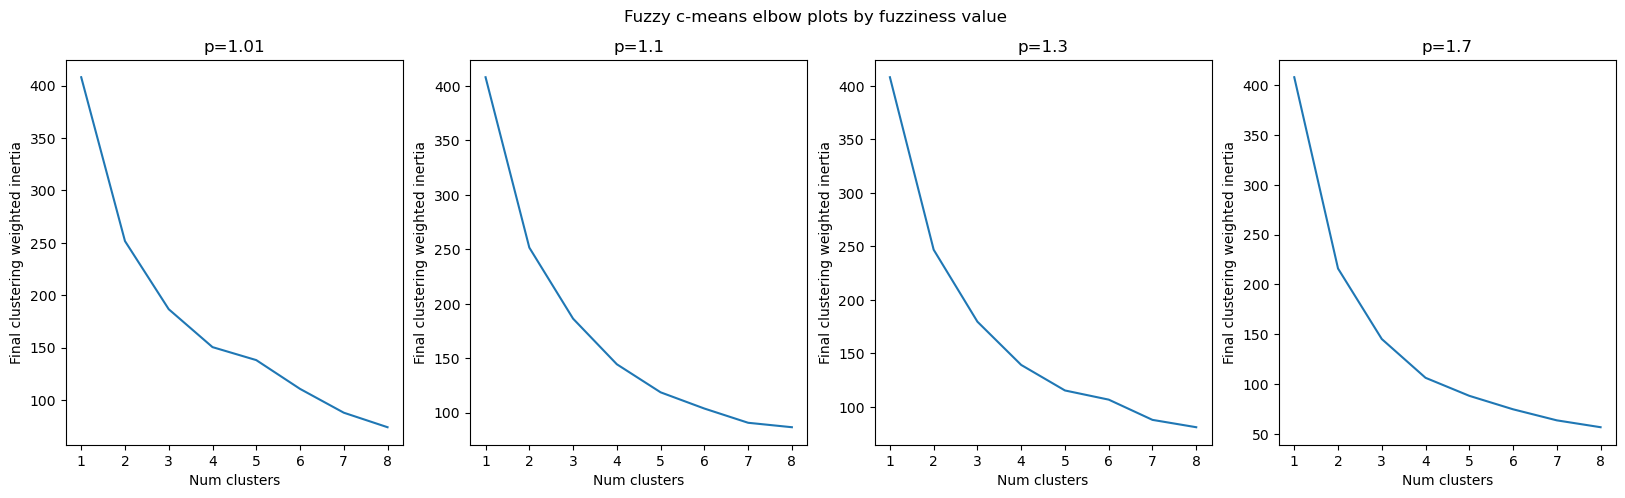

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
fig.suptitle("Fuzzy c-means elbow plots by fuzziness value")
for i,p in enumerate([1.01, 1.1, 1.3, 1.7]):
    inertias = []
    for c in range(1,9):
        centroids, W, W_0, dist_mat, history, iters, ndpc = cmeans(df_scaled.T, c=c, m=p, error=1e-6, maxiter=20000, seed=100)
        inertias.append(history[len(history) - 1])

    ax[i].plot(range(1,9), inertias)
    ax[i].set_xlabel('Num clusters')
    ax[i].set_ylabel('Final clustering weighted inertia')
    ax[i].set_title(f'p={p}')
plt.show()

### Fuzzy c-Means t-SNE Plot Corroboration

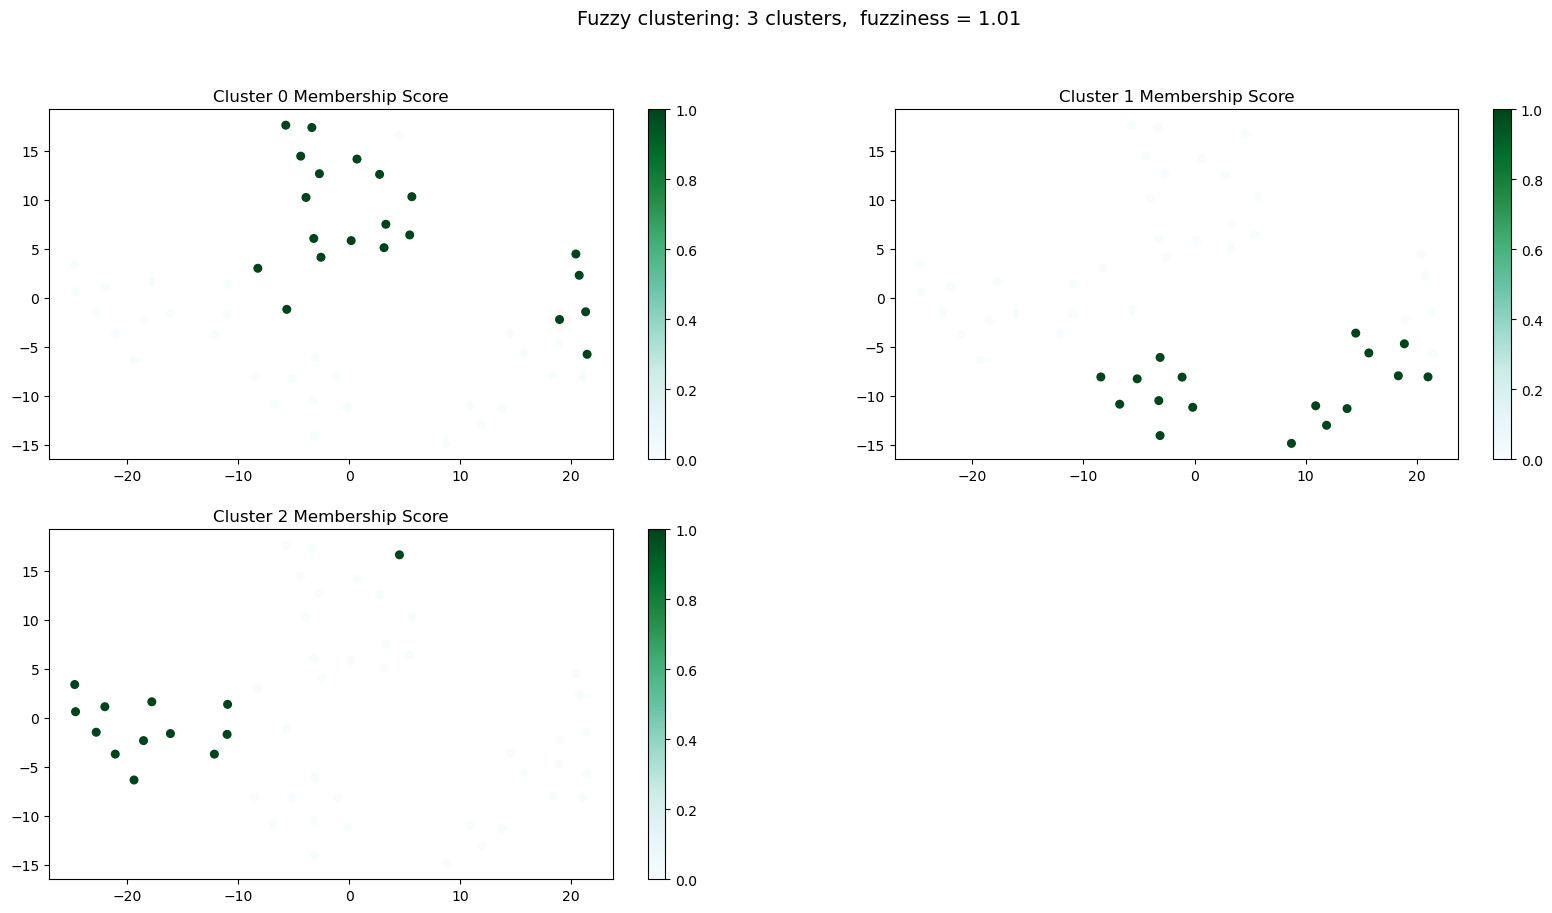

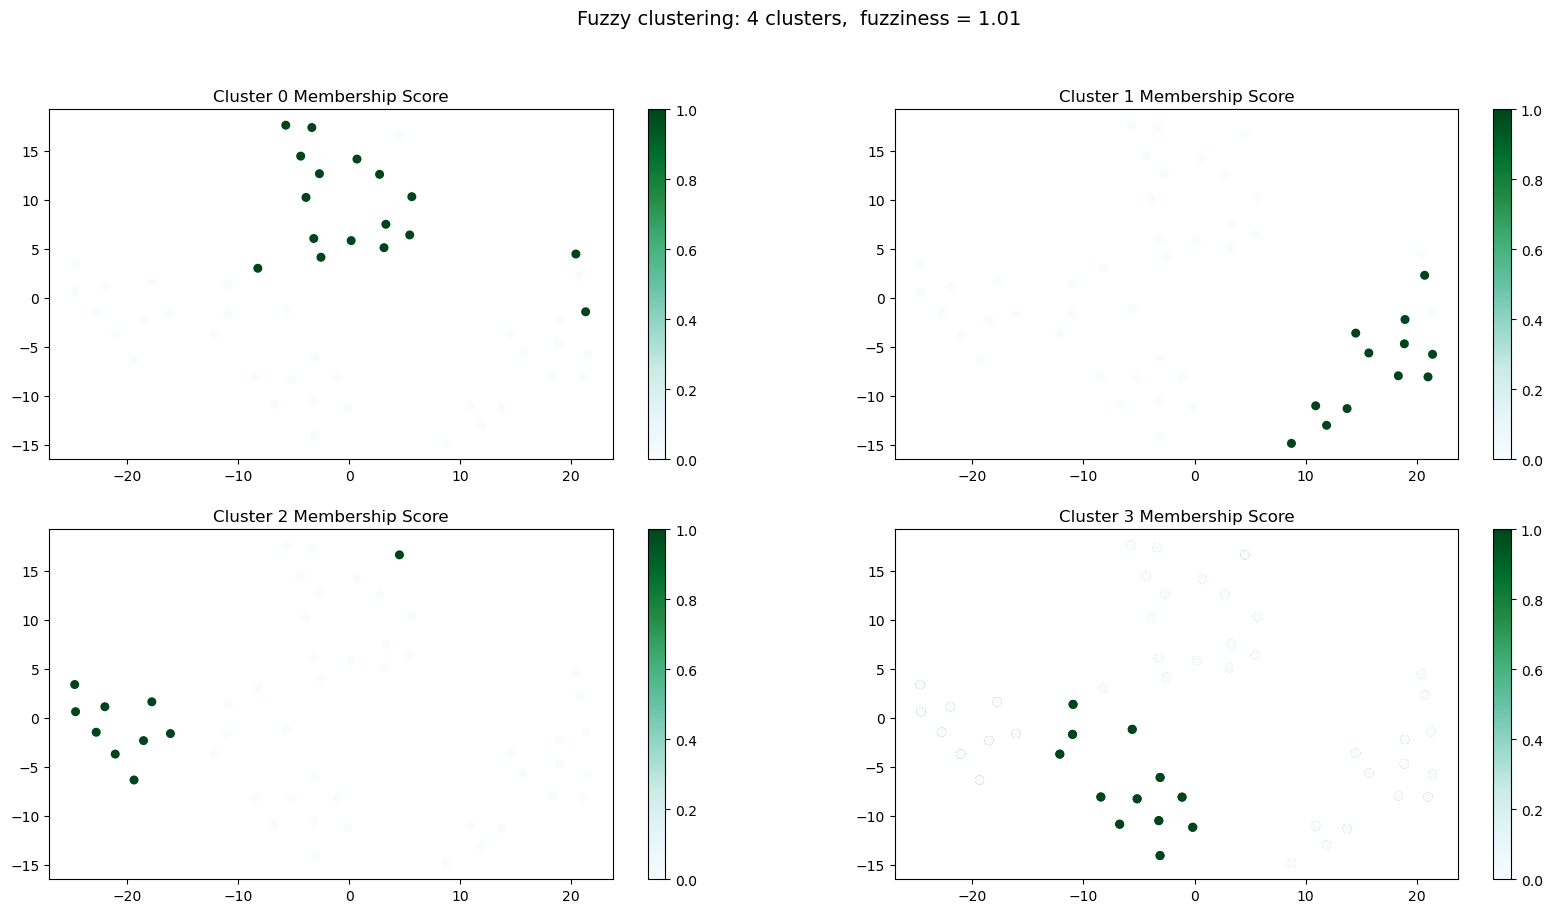

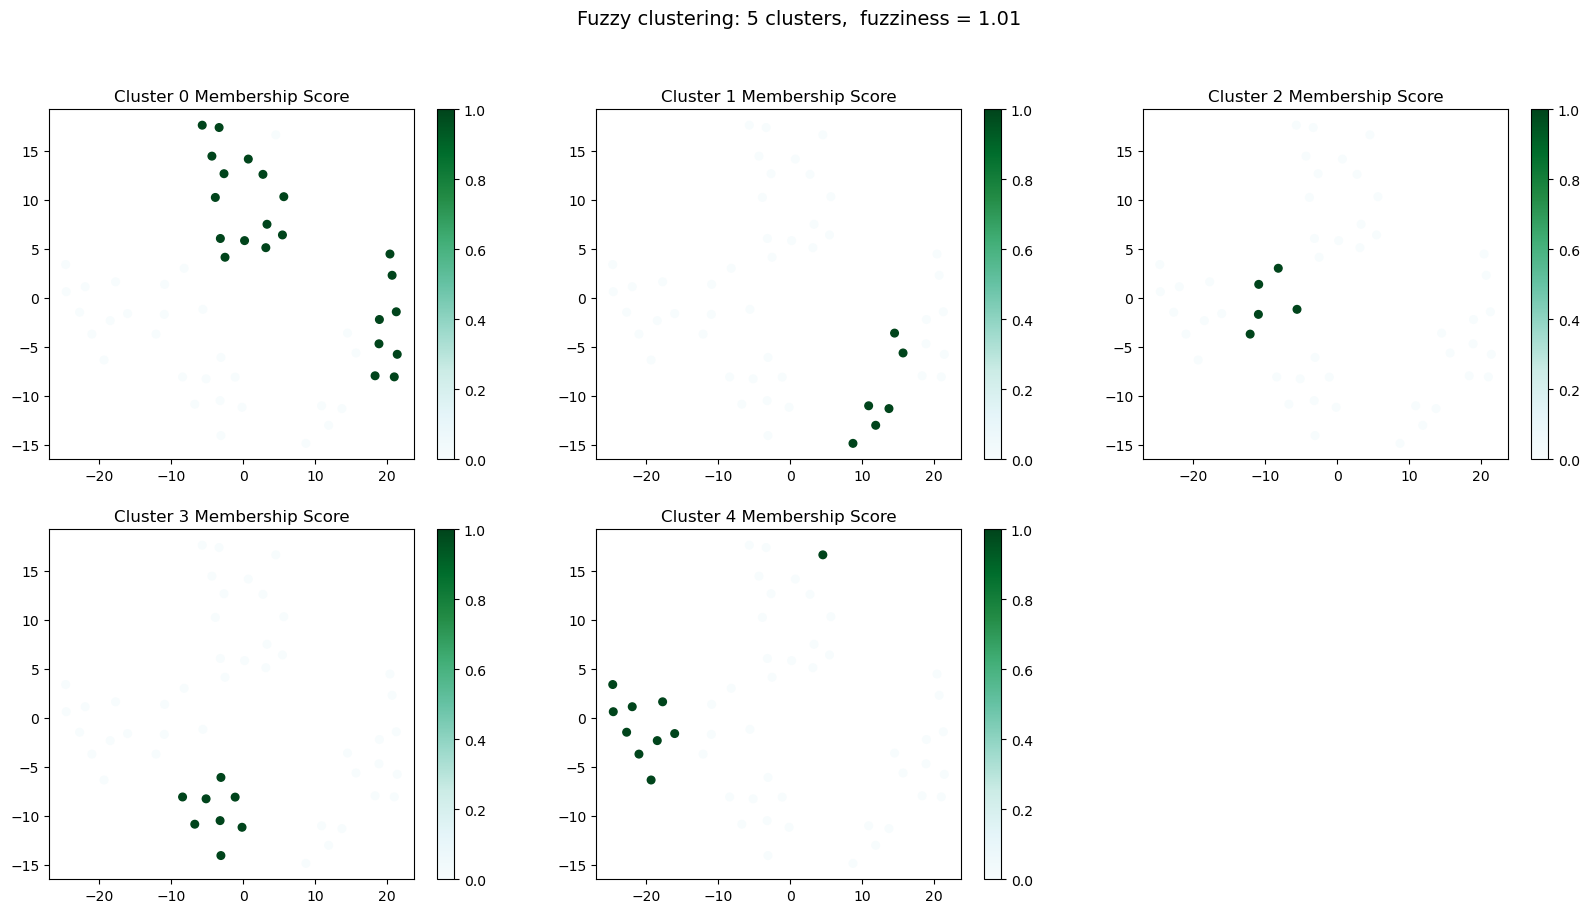

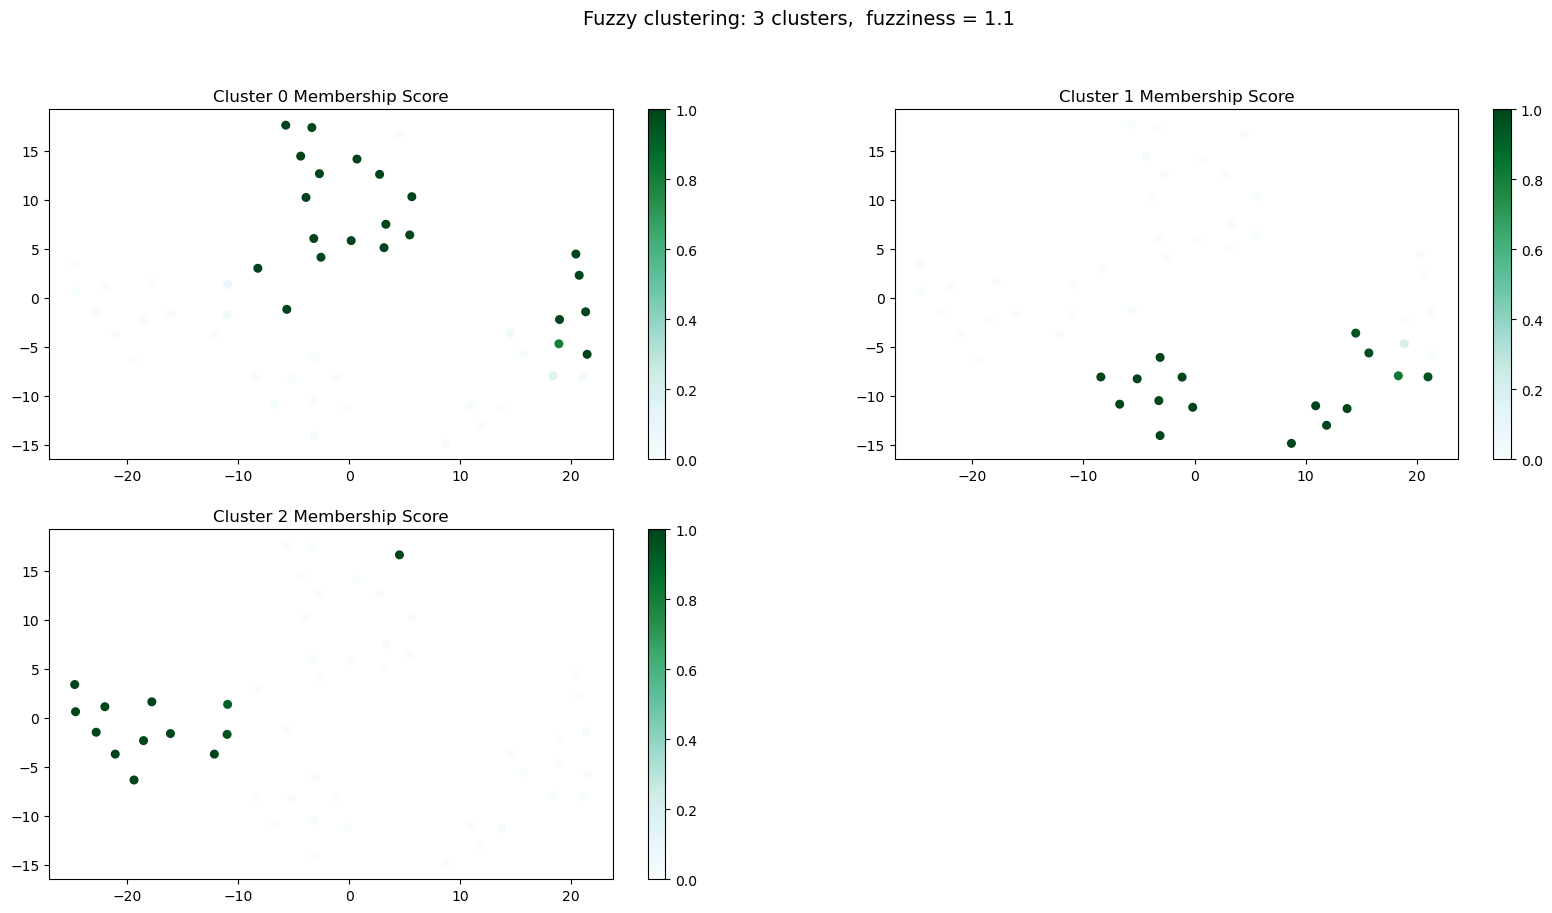

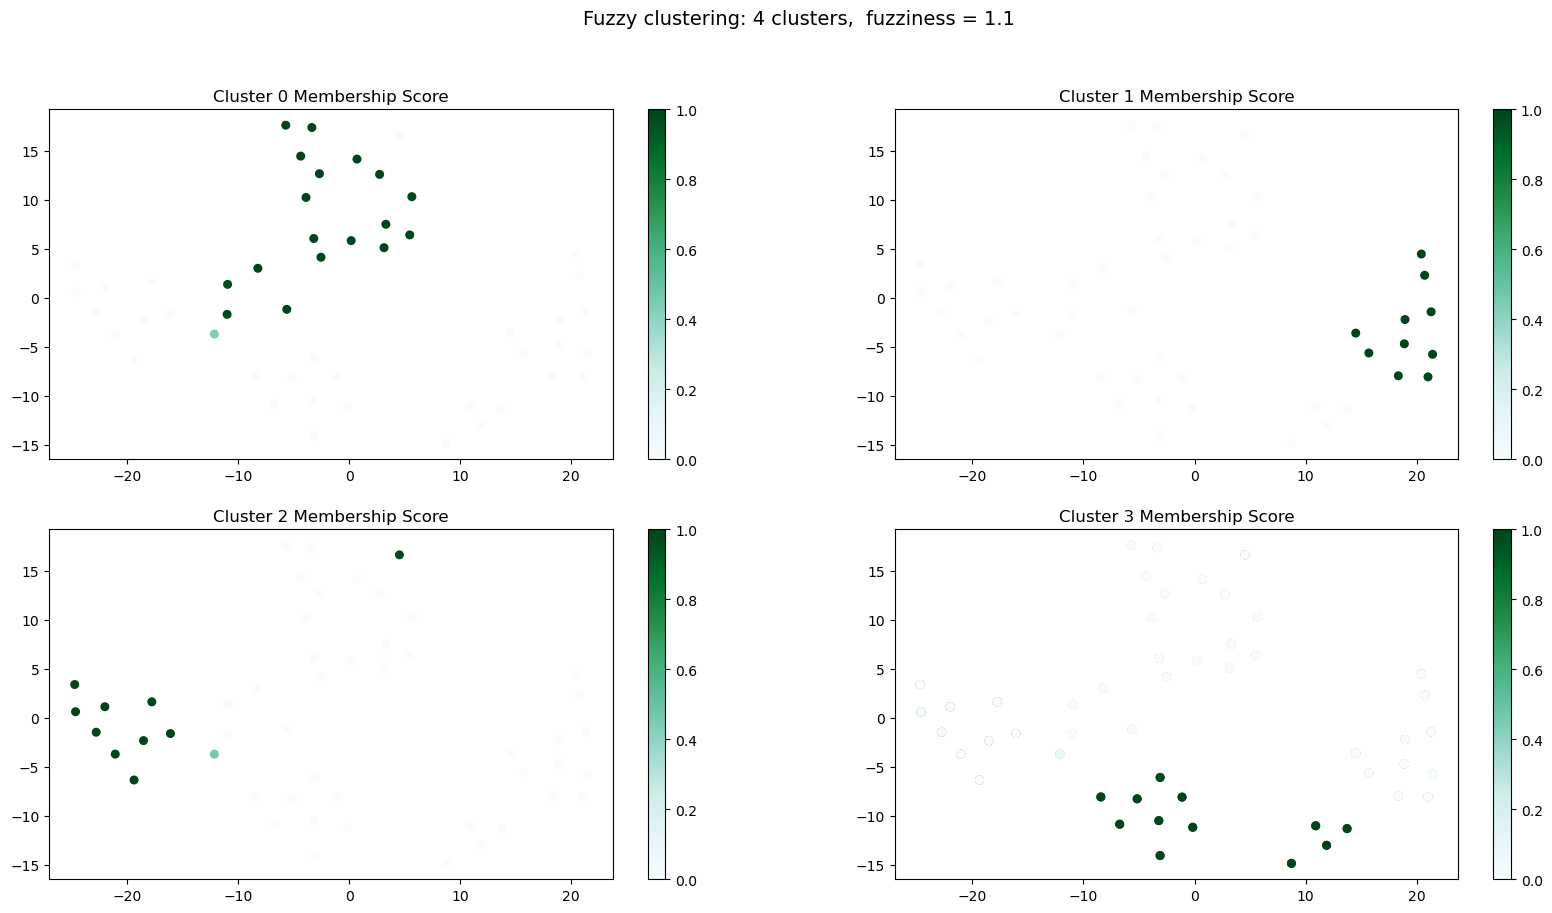

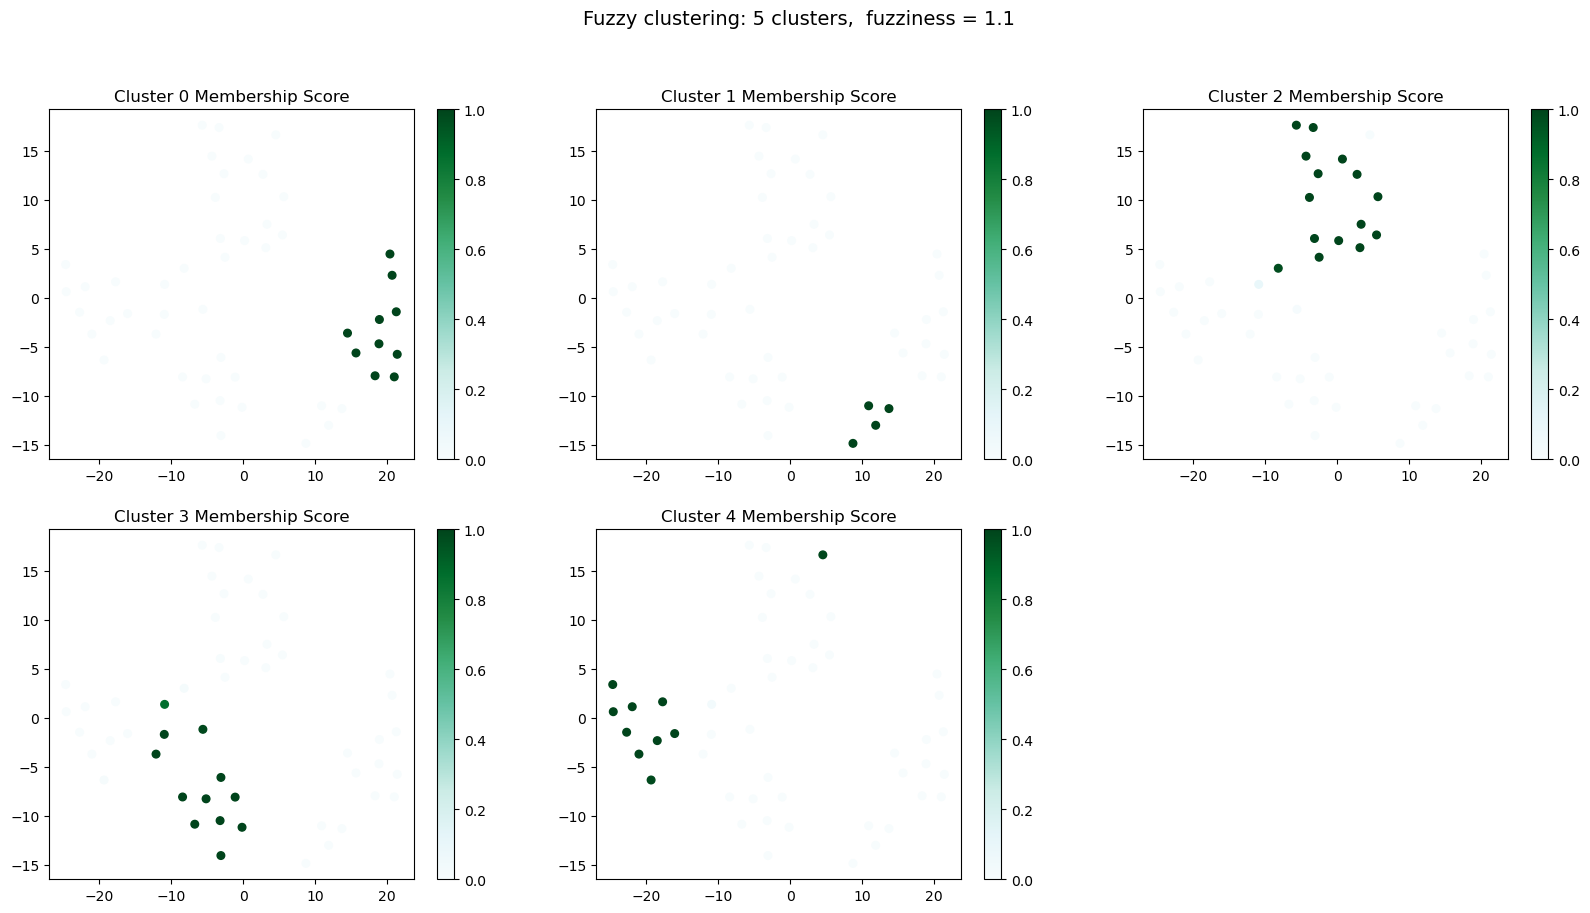

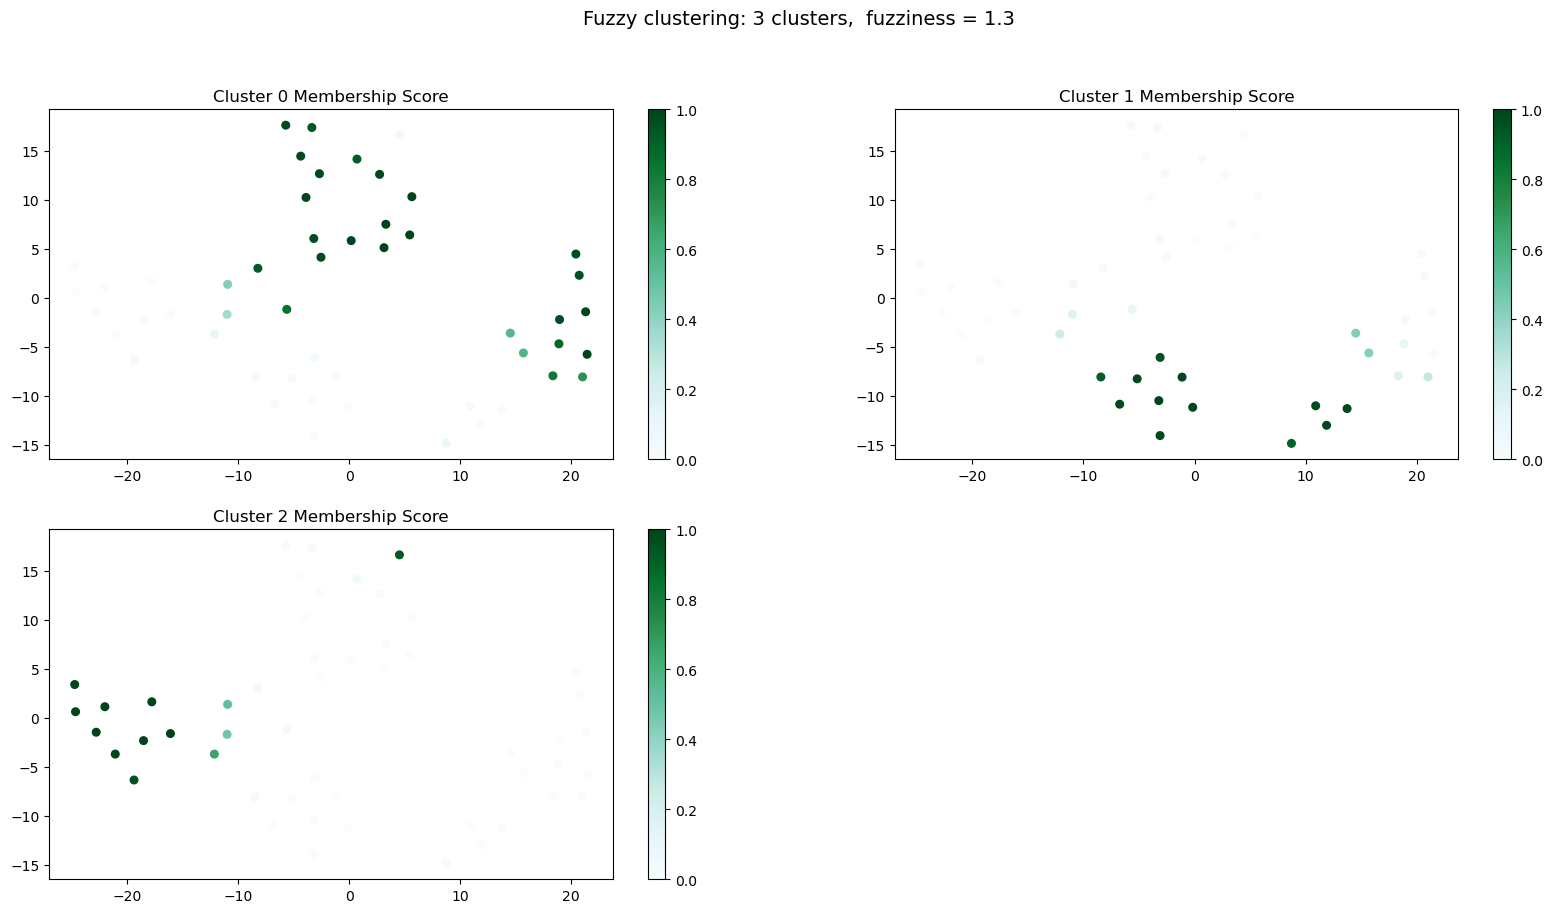

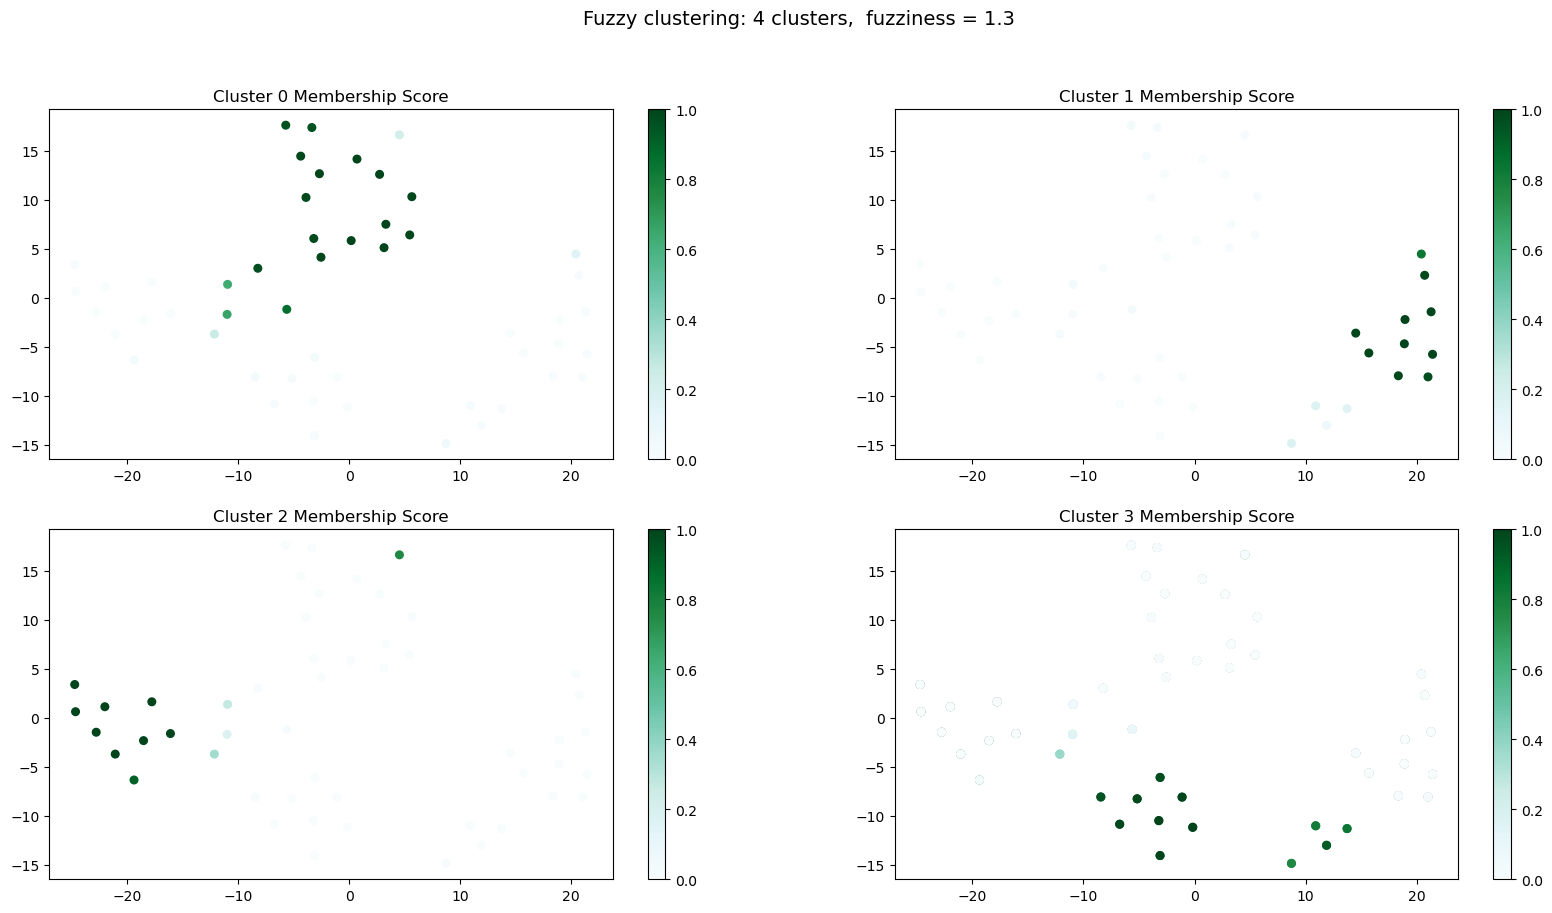

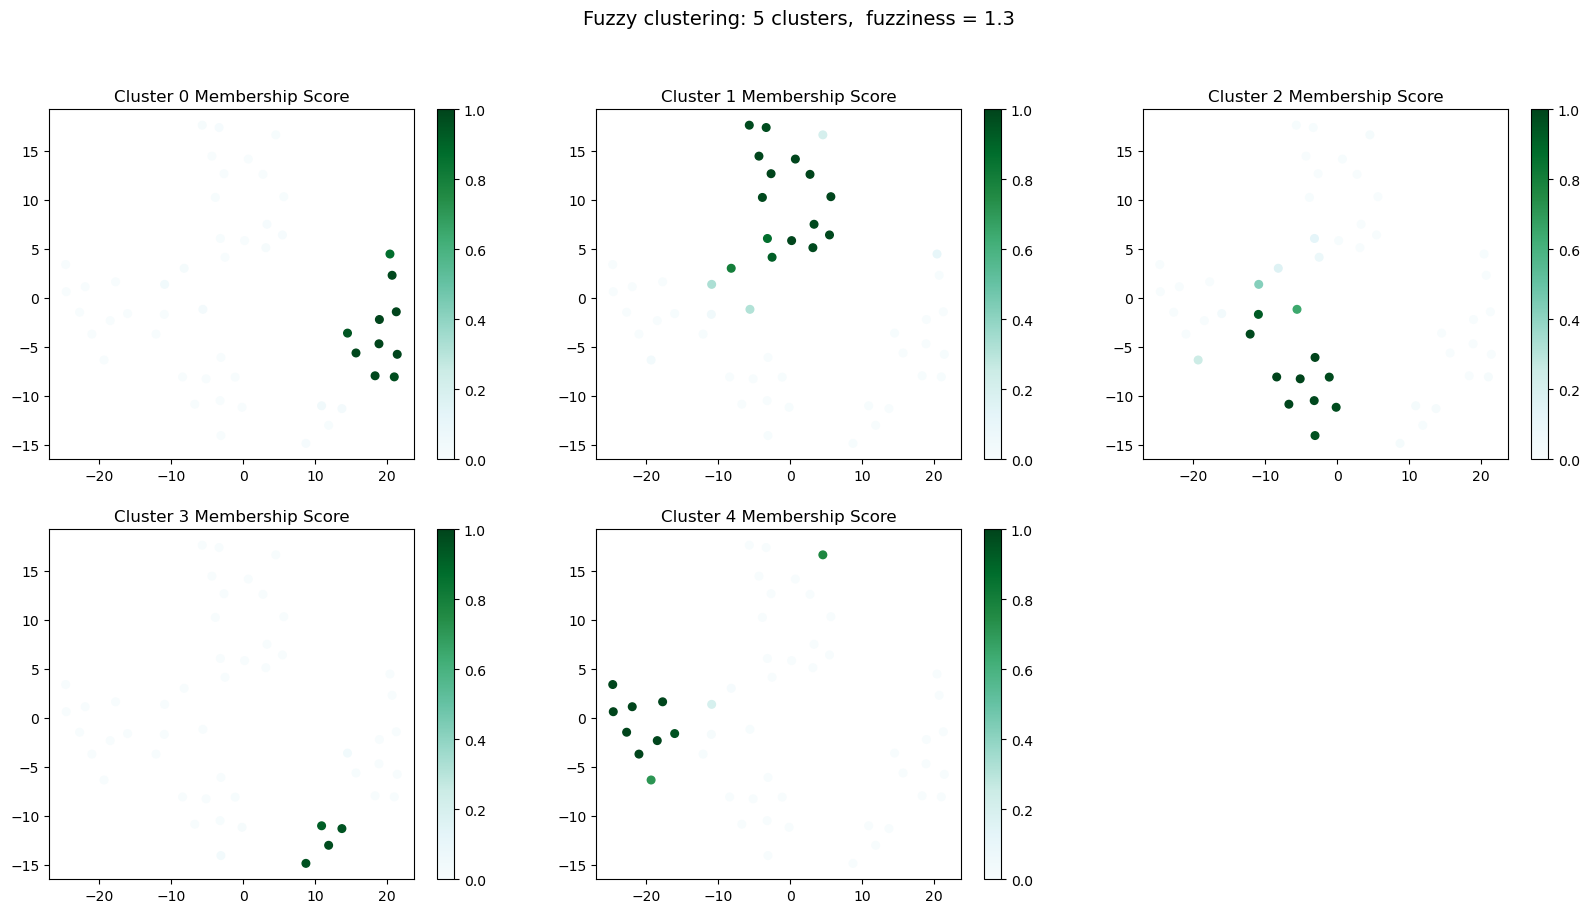

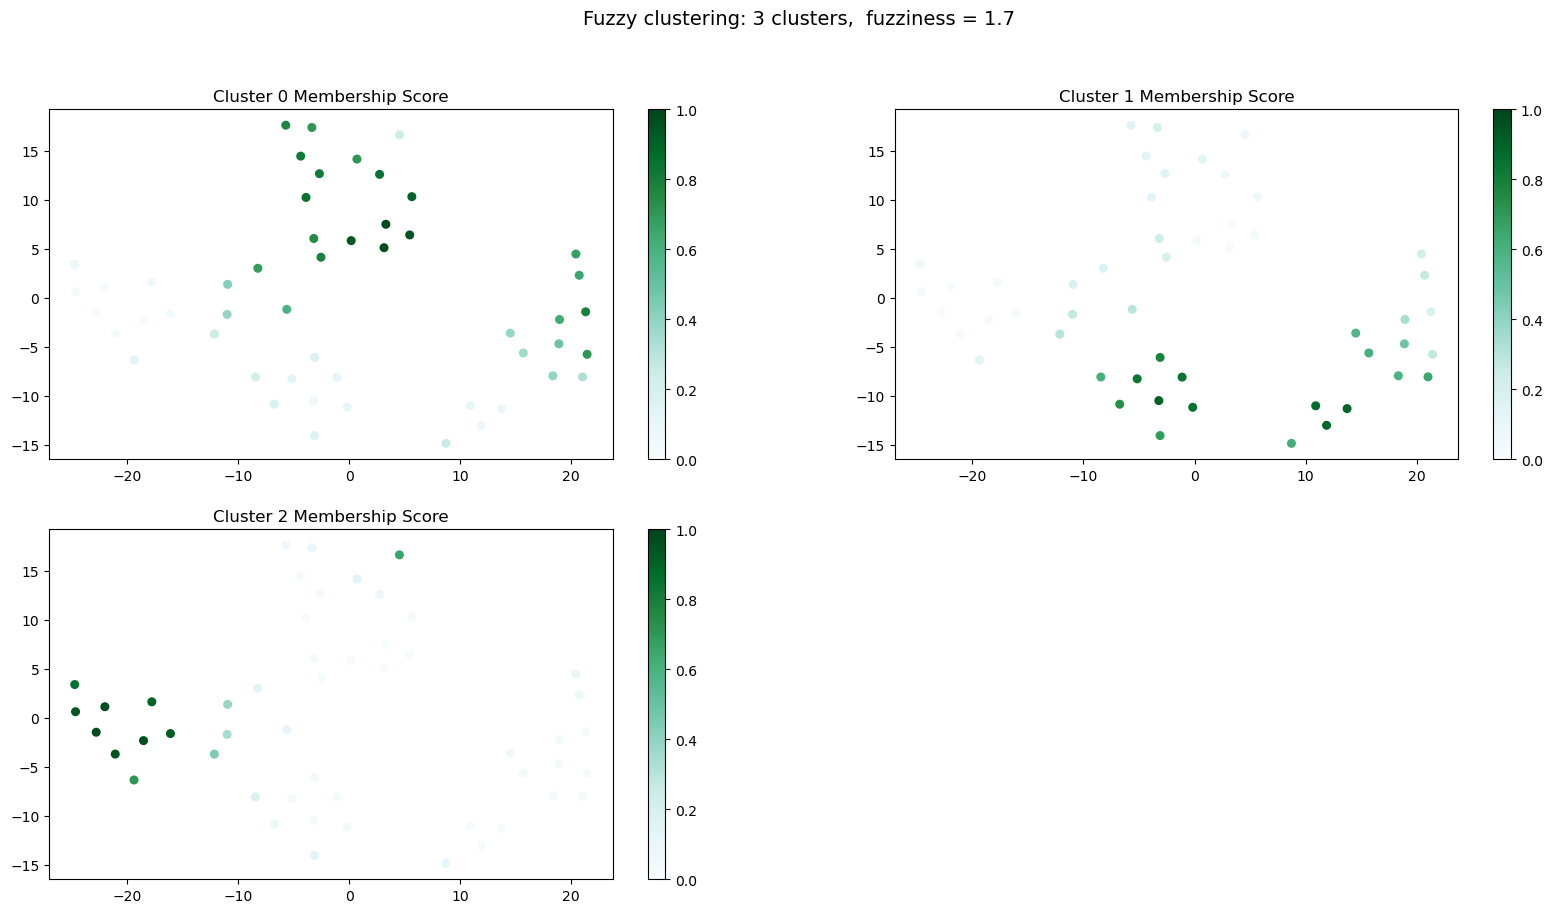

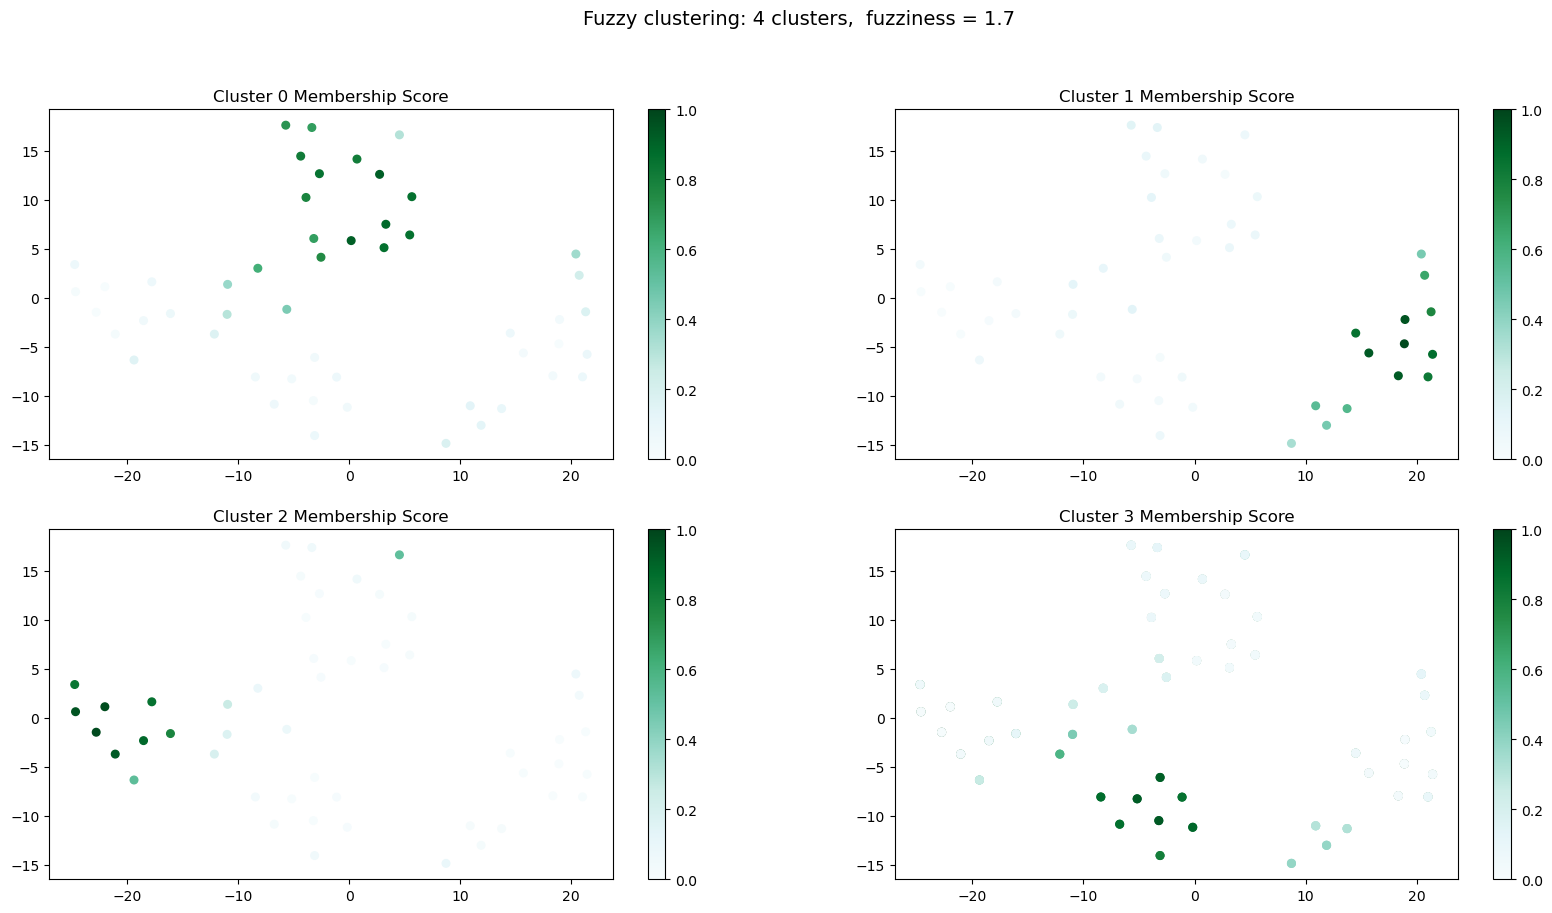

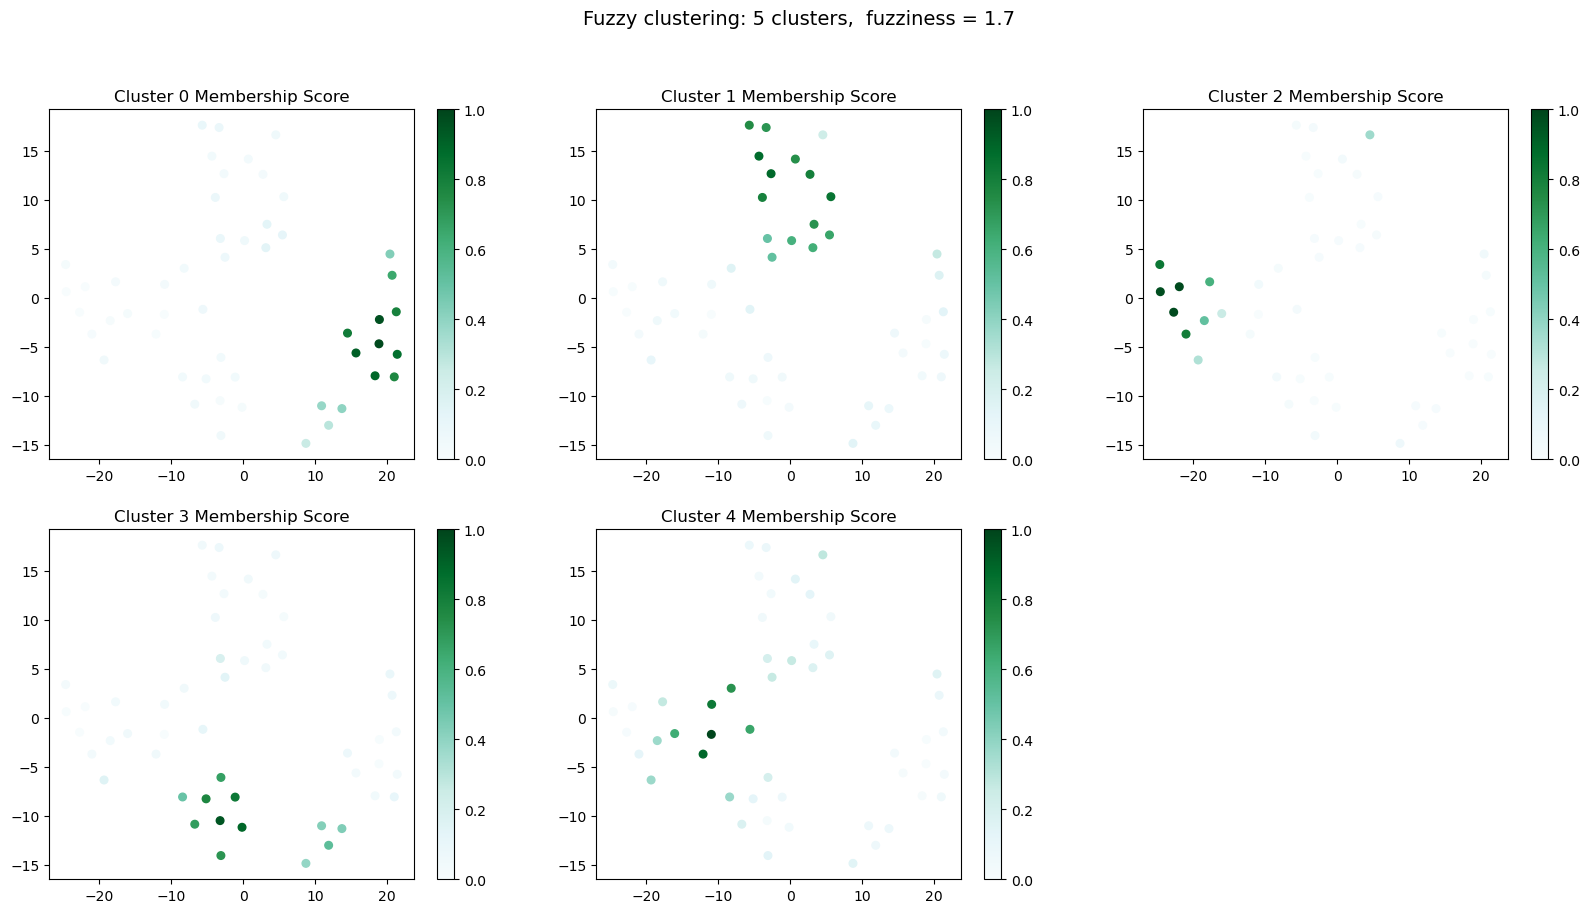

In [20]:
for p in [1.01, 1.1, 1.3, 1.7]:
    for c in [3, 4, 5]:

        ncols = math.ceil(math.sqrt(c))
        nrows = math.ceil(c / ncols)

        centroids, W, W_0, dist_mat, history, iters, ndpc = cmeans(df_scaled.T, c=c, m=p, error=1e-6, maxiter=20000, seed=100)
        fig, ax = plt.subplots(nrows, ncols, figsize=(20,10), squeeze=False)
        plt.suptitle(f'Fuzzy clustering: {c} clusters,  fuzziness = {p}', fontsize=14)

        for i in range(0,c):

            row = i // ncols
            col = i % ncols

            df_tsne['Cluster %s Membership Score' %str(i)] = W[i,:]
            points = plt.scatter(df_tsne['x'], df_tsne['y'], c = df_tsne['Cluster %s Membership Score' %str(i)], s=30, cmap='BuGn', vmin=0, vmax=1)
            ax[row, col].scatter(df_tsne['x'], df_tsne['y'], c = df_tsne['Cluster %s Membership Score' %str(i)], s=30, cmap='BuGn', vmin=0, vmax=1)
            fig.colorbar(points, ax=ax[row, col])
            ax[row, col].set_title('Cluster %s Membership Score' %str(i))
        
        for j in range(c, nrows * ncols):
            row = j // ncols
            col = j % ncols
            fig.delaxes(ax[row, col])

        plt.show()

### Fuzzy c-Means Average Silhouette Score Plots

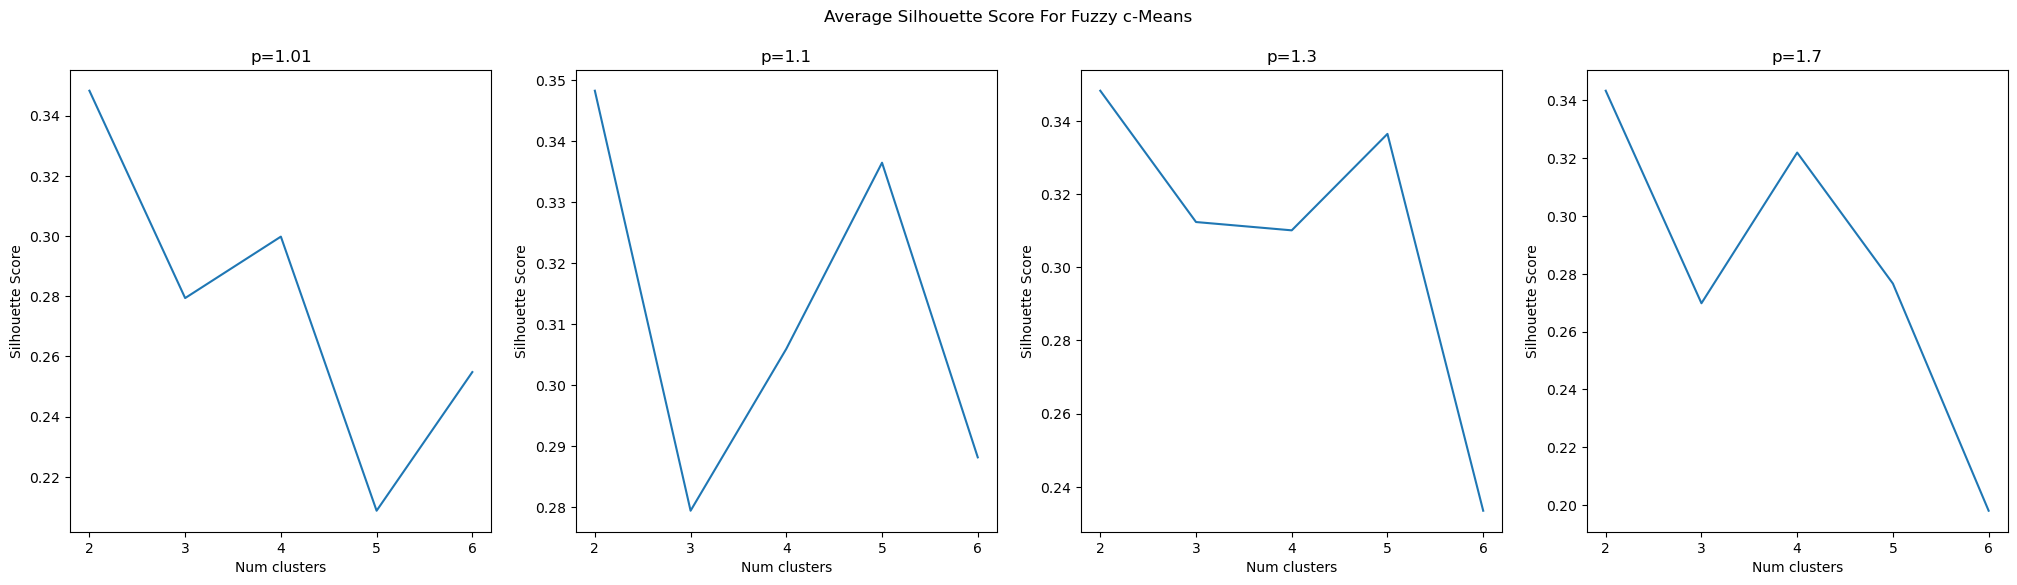

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(25, 6))
fig.suptitle("Average Silhouette Score For Fuzzy c-Means")
for i,p in enumerate([1.01, 1.1, 1.3, 1.7]):
    scores = []
    for c in range(2,7):
        centroids, W, W_0, dist_mat, history, iters, ndpc = cmeans(df_scaled.T, c=c, m=p, error=1e-6, maxiter=20000, seed=100)
        cluster_columns = ['Cluster %s Membership score' %(str(i)) for i in range(0,c)]
        df_membership = pd.DataFrame(W.T, columns=cluster_columns)
        partition_cluster_labels = [df_membership.T[i].argmax() for i in range(0, len(df_membership))]
        scores.append(silhouette_score(X, partition_cluster_labels, metric='euclidean'))
    ax[i].plot(range(2, 7), scores)
    ax[i].set_xlabel("Num clusters")
    ax[i].set_xticks(range(2,7))
    ax[i].set_ylabel("Silhouette Score")
    ax[i].set_title(f"p={p}")
plt.show()

### Fuzzy c-Means Cluster Sorted Similarity Matrix

Text(0.5, 0.98, 'Cluster-Sorted Similarity Matrices for Fuzzy c Means')

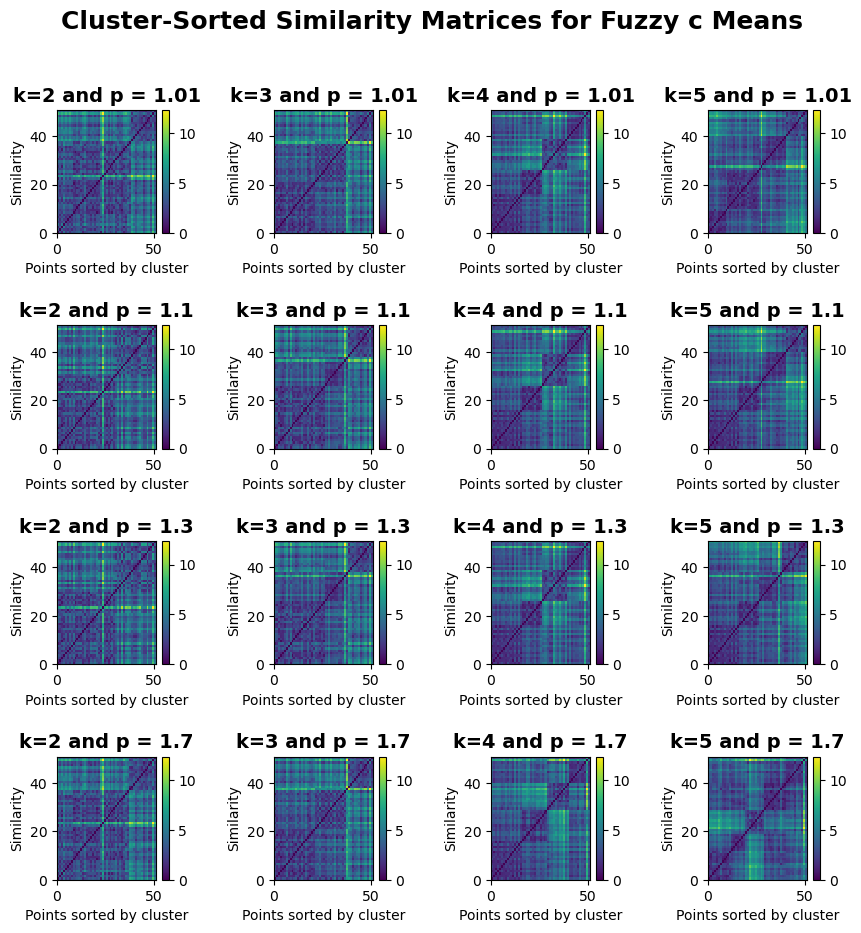

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 9))
fig.subplots_adjust(hspace = 0.75)
fig.subplots_adjust(wspace = 0.75)
fig.set_figheight(10)
fig.set_figwidth(10)

p_list = [1.01, 1.1, 1.3, 1.7]
for i in range(4):
    p = p_list[i]
    scores = []
    for c in range(2,6):
        ax = axes[i, c-2]
        centroids, W, W_0, dist_mat, history, iters, ndpc = cmeans(df_scaled.T, c=c, m=p, error=1e-6, maxiter=20000, seed=100)
        cluster_columns = ['Cluster %s Membership score' %(str(i)) for i in range(0,c)]
        df_membership = pd.DataFrame(W.T, columns=cluster_columns)
        partition_cluster_labels = [df_membership.T[i].argmax() for i in range(0, len(df_membership))]
        scores.append(silhouette_score(X, partition_cluster_labels, metric='euclidean'))

        partition_cluster_labels = [df_membership.T[i].argmax() for i in range(0, len(df_membership))]
        df_scaled['partition_cluster_labels'] = partition_cluster_labels
        df_sort = df_scaled.sort_values(by='partition_cluster_labels')
        df_sort = df_sort.drop(['partition_cluster_labels'], axis=1)
        dist_mat = squareform(pdist(df_sort))
        im = ax.pcolormesh(dist_mat)
        fig.colorbar(im, ax=ax)
        N = len(df_sort)
        ax.set_xlim([0,N])
        ax.set_ylim([0,N])
        ax.set_xlabel('Points sorted by cluster')
        ax.set_ylabel('Similarity')
        ax.set_title(f'k={c} and p = {p}', fontweight='bold', fontsize=14)
fig.suptitle('Cluster-Sorted Similarity Matrices for Fuzzy c Means', fontsize=18, fontweight='bold')

### Fuzzy c-Means Outlier and Noise Handling

Based on the pairplots and t-SNE, we knew this dataset had an no noise, but one outlier that may impact the fuzzy c-means clustering. However, we decided to leave the outlier in the data for several reasons. First, if the outlier was vastly different from all other observations, fuzzy c-means would have identified it as a singleton cluster, preserving the separation and cohesion of all the other identified clusters. That way, legislators could implement shared funding and programs for states that truly share drug use characteristics, and propose a unique solution for that outlier. On the other hand, if the outlier was similar enough to other observations, it would be grouped into the cluster it most strongly belonged to. Then, legislators would understand which other states, and therefore which other programs, would be most likely to be successful in the outlier state. Those states could then share funding and resources as necessary. As it turns out, none of the clusterings separated the outlier into a singleton cluster. This answered our reseach question of whether any states had significantly different young adult drug abuse patterns from the others. Furthermore it suggested that the outlier state would likely benefit from sharing resources with its most similar neighbors.

### Fuzzy c-Means Fuzziness

We clustered the data with various fuzziness ranging from 1.01 to 1.7 to identify the value that provides the most useful information about cluster membership. To find this value, we looked at the t-SNE plots and cluster-sorted similarity matrices at 4 clusters. The smaller fuzziness values produced fairly hard assignments, with one or two observations that had significant membership in more than one cluster. We identified that using 1.7 struck the right balance of producing hard assignments for observations that strongly belonged in a cluster, while giving more nuanced information for all the other states. We could also understand which clusters were nearest each other by studying which clusters any given observation had significant membership in. The t-SNE plots show that probable straddle nodes have fuzzy assignment, while other nodes have harder assignment.

### Fuzzy c-Means Best Clustering

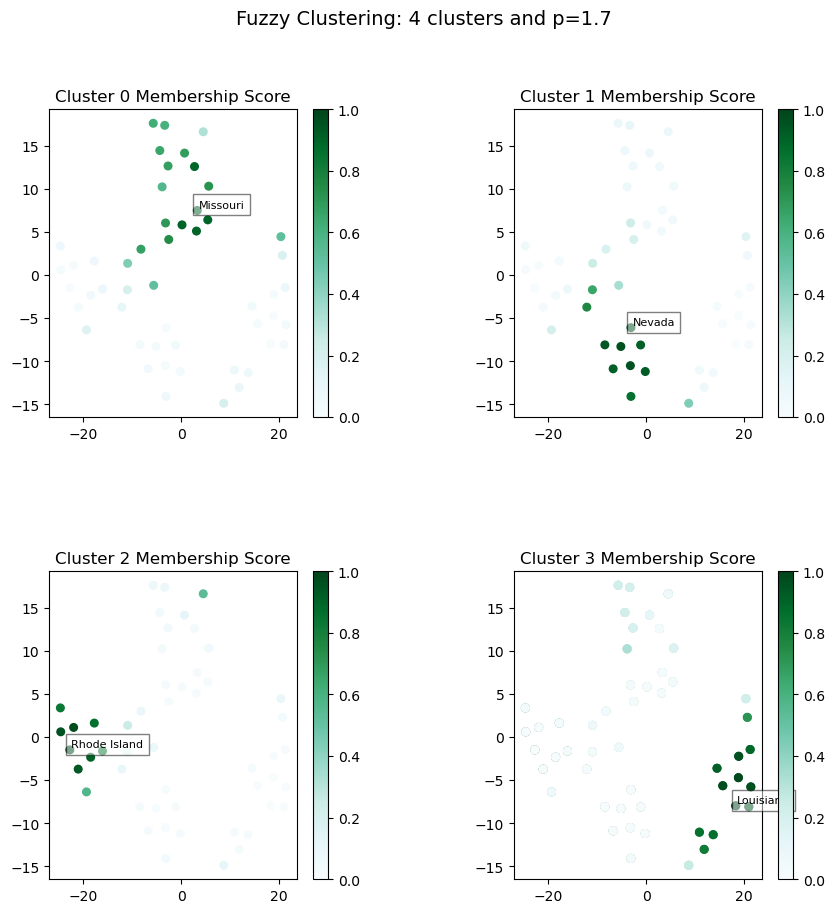

In [23]:
c = 4
p = 1.7

centroids, W, W_0, dist_mat, history, iters, ndpc = cmeans(df_scaled.T, c=c, m=p, error=1e-6, maxiter=20000, seed=100)
fig, ax = plt.subplots(2, 2)
fig.subplots_adjust(hspace = 0.5)
fig.subplots_adjust(wspace = 0.5)
fig.set_figheight(10)
fig.set_figwidth(10)

plt.suptitle('Fuzzy Clustering: %s clusters and p=%s'%(c,p), fontsize = 14)
for i in range(0,c):

    row = i // 2
    col = i % 2

    df_tsne['Cluster %s Membership Score' %str(i)] = W[i,:]

    points = plt.scatter(df_tsne['x'], df_tsne['y'], c = df_tsne['Cluster %s Membership Score' %str(i)], s=30, cmap='BuGn', vmin=0, vmax=1)
    ax[row, col].scatter(df_tsne['x'], df_tsne['y'], c = df_tsne['Cluster %s Membership Score' %str(i)], s=30, cmap='BuGn', vmin=0, vmax=1)
    cluster_max_idx = np.argmax(df_tsne['Cluster %s Membership Score' %str(i)])
    ax[row, col].text(
        x = df_tsne.loc[cluster_max_idx, 'x'] + 0.3, y = df_tsne.loc[cluster_max_idx,'y'] + 0.3,
        s = states[cluster_max_idx],
        fontdict=dict(color='black', size=8), bbox=dict(facecolor='white', alpha=0.5)
    )
    fig.colorbar(points, ax=ax[row, col])
    ax[row, col].set_title('Cluster %s Membership Score' %str(i))

for j in range(c, 2 * 2):
    row = j // 2
    col = j % 2
    fig.delaxes(ax[row, col])

plt.show()


In [24]:
ndpc

np.float64(0.7048747073117291)

### Highest Cluster Membership Weights

In [25]:
cluster_columns = ['Cluster %s Membership Score'%(str(i)) for i in range(4)]
df_membership = pd.DataFrame(W.T, columns = cluster_columns)
df_membership.round(4)

Cluster 0 Membership Score  Cluster 1 Membership Score  \
0                       0.0198                      0.0097   
1                       0.4411                      0.2514   
2                       0.0539                      0.9137   
3                       0.0248                      0.0075   
4                       0.0636                      0.8585   
5                       0.0128                      0.0091   
6                       0.0478                      0.0327   
7                       0.2019                      0.6578   
8                       0.1604                      0.2080   
9                       0.0231                      0.9584   
10                      0.0705                      0.0539   
11                      0.0448                      0.9264   
12                      0.0795                      0.0471   
13                      0.7434                      0.2029   
14                      0.9060                      0.0524   
15                      0.6554                      0.0751   
16                      0.5678                      0.0686   
17                      0.1827                      0.0559   
18                      0.0085                      0.0030   
19                      0.0747                      0.0414   
20                      0.0477                      0.9173   
21                      0.0272                      0.0293   
22                      0.6755                      0.1860   
23                      0.8974                      0.0485   
24                      0.0506                      0.0267   
25                      0.9198                      0.0420   
26                      0.3176                      0.0848   
27                      0.6796                      0.0789   
28                      0.0261                      0.9622   
29                      0.0238                      0.0166   
30                      0.0276                      0.9596   
31                      0.5194                      0.3382   
32                      0.0316                      0.9401   
33                      0.0337                      0.0130   
34                      0.6002                      0.1047   
35                      0.8999                      0.0484   
36                      0.0846                      0.0190   
37                      0.0845                      0.0742   
38                      0.9045                      0.0623   
39                      0.0097                      0.0084   
40                      0.0293                      0.0077   
41                      0.6236                      0.0842   
42                      0.0102                      0.0037   
43                      0.0949                      0.0670   
44                      0.2006                      0.4339   
45                      0.0773                      0.0559   
46                      0.7012                      0.2416   
47                      0.1128                      0.7646   
48                      0.5205                      0.1574   
49                      0.6864                      0.0837   
50                      0.7200                      0.0519   

    Cluster 2 Membership Score  Cluster 3 Membership Score  
0                       0.0044                      0.9661  
1                       0.2431                      0.0644  
2                       0.0152                      0.0173  
3                       0.0044                      0.9634  
4                       0.0450                      0.0329  
5                       0.9740                      0.0041  
6                       0.9087                      0.0108  
7                       0.1104                      0.0299  
8                       0.5714                      0.0603  
9                       0.0082                      0.0103  
10                      0.0200                      0.8557  
11                      0.0132                 

In [26]:
highest_membership_scores = df_membership.T.max()
highest_membership_scores

0     0.966079
1     0.441054
2     0.913660
3     0.963358
4     0.858515
5     0.973960
6     0.908706
7     0.657827
8     0.571365
9     0.958369
10    0.855667
11    0.926404
12    0.854838
13    0.743415
14    0.905958
15    0.655365
16    0.567752
17    0.715994
18    0.987018
19    0.861363
20    0.917349
21    0.934051
22    0.675461
23    0.897398
24    0.910956
25    0.919806
26    0.541018
27    0.679576
28    0.962226
29    0.951305
30    0.959586
31    0.519441
32    0.940092
33    0.945732
34    0.600191
35    0.899856
36    0.883349
37    0.818106
38    0.904481
39    0.978535
40    0.958031
41    0.623623
42    0.984103
43    0.813826
44    0.433897
45    0.833506
46    0.701173
47    0.764558
48    0.520507
49    0.686407
50    0.720046
dtype: float64

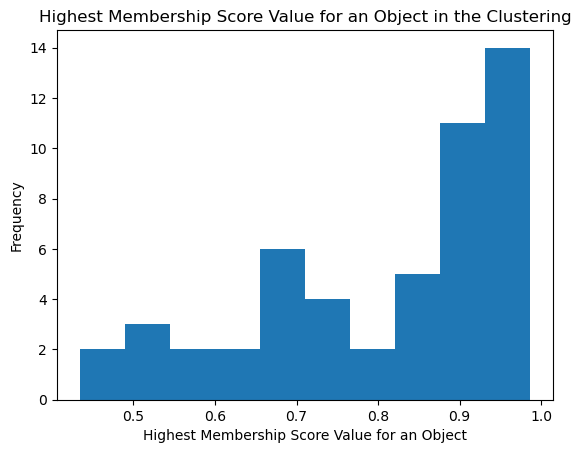

In [27]:
plt.hist(highest_membership_scores)
plt.title("Highest Membership Score Value for an Object in the Clustering")
plt.xlabel("Highest Membership Score Value for an Object")
plt.ylabel("Frequency")
plt.show()

In [28]:
states[np.argmin(highest_membership_scores)]

'Utah'

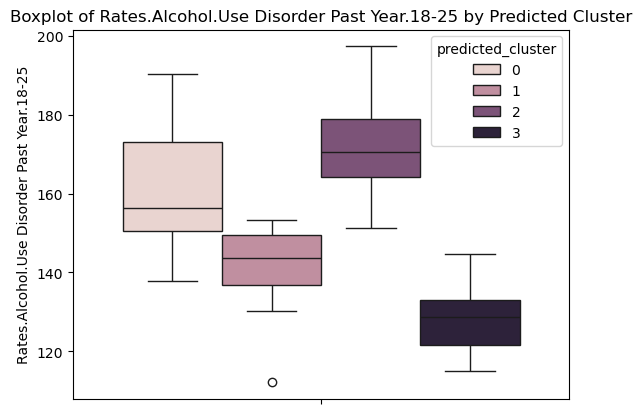

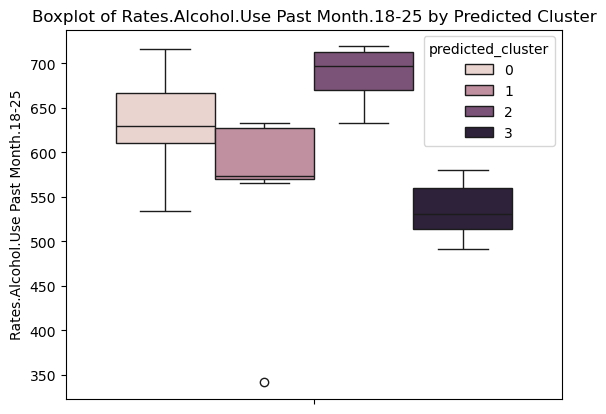

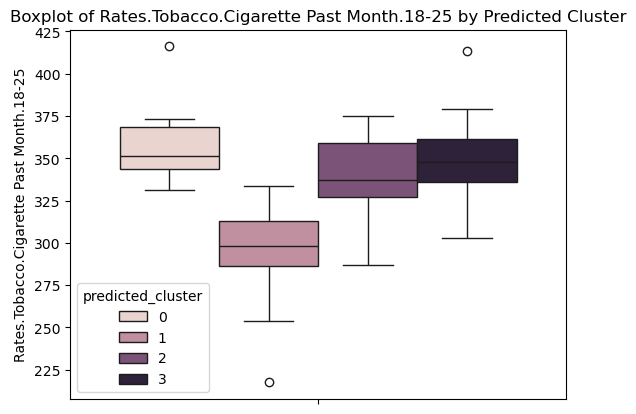

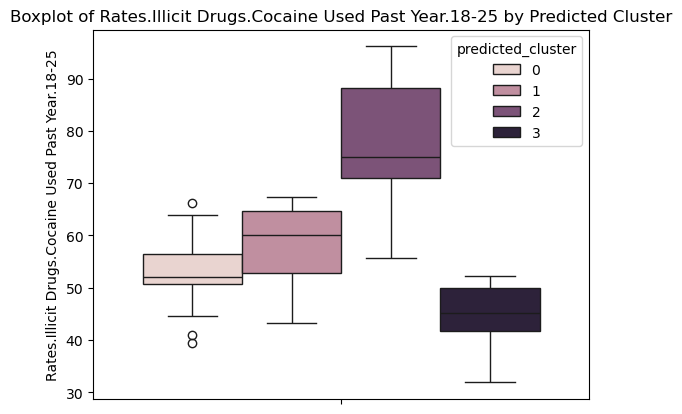

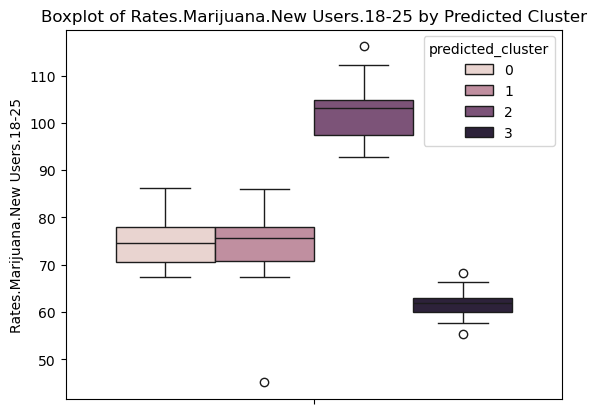

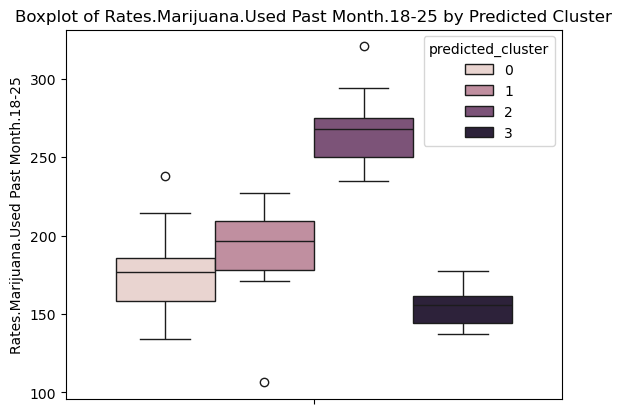

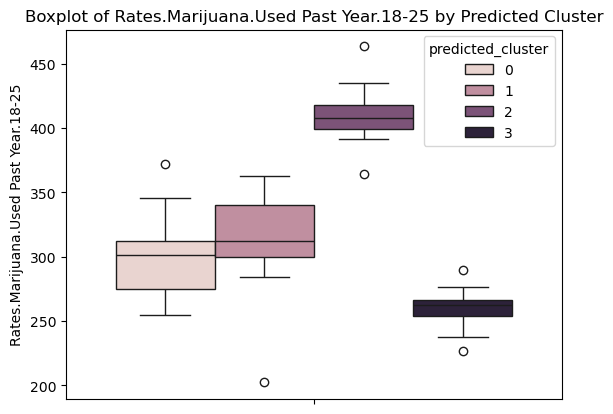

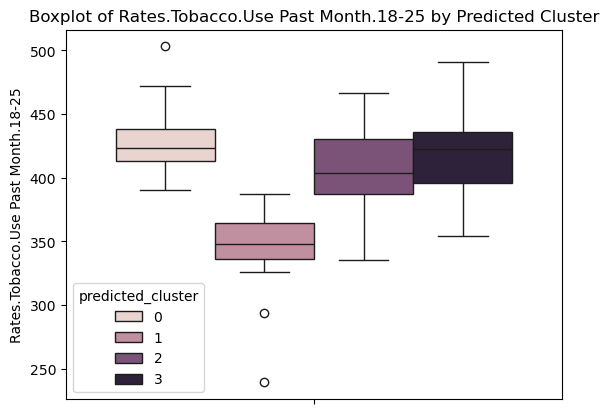

In [29]:
partition_cluster_labels=[df_membership.T[i].argmax() for i in range(0, len(df_membership))]
df2 = df.copy()
df2["predicted_cluster"] = partition_cluster_labels
for column in df2.columns.tolist():
    if column == "State" or column == "predicted_cluster":
        continue
    else:
        sns.boxplot(
            data = df2,
            y = column,
            hue = "predicted_cluster"
        )
        plt.title("Boxplot of %s by Predicted Cluster"%(column))
        plt.show()

In [30]:
cluster0 = df2[df2["predicted_cluster"] == 0]["State"].reset_index(drop=True)
cluster1 = df2[df2["predicted_cluster"] == 1]["State"].reset_index(drop=True)
cluster2 = df2[df2["predicted_cluster"] == 2]["State"].reset_index(drop=True)
cluster3 = df2[df2["predicted_cluster"] == 3]["State"].reset_index(drop=True)

pd.DataFrame(
    {'cluster0': cluster0,
     'cluster1': cluster1,
     'cluster2': cluster2,
     'cluster3':cluster3
    })

cluster0    cluster1              cluster2        cluster3
0          Alaska     Arizona              Colorado         Alabama
1        Illinois  California           Connecticut        Arkansas
2         Indiana    Delaware  District of Columbia         Georgia
3            Iowa     Florida                 Maine           Idaho
4          Kansas      Hawaii         Massachusetts        Kentucky
5        Michigan    Maryland               Montana       Louisiana
6       Minnesota      Nevada         New Hampshire     Mississippi
7        Missouri  New Jersey                Oregon  North Carolina
8        Nebraska    New York          Rhode Island        Oklahoma
9      New Mexico        Utah               Vermont  South Carolina
10   North Dakota  Washington                   NaN       Tennessee
11           Ohio         NaN                   NaN           Texas
12   Pennsylvania         NaN                   NaN             NaN
13   South Dakota         NaN                   NaN             NaN
14       Virginia         NaN                   NaN             NaN
15  West Virginia         NaN                   NaN             NaN
16      Wisconsin         NaN                   NaN             NaN
17        Wyoming         NaN                   NaN             NaN

### Fuzzy c-Means Technique Shortcomings

In conjunction with each other, the elbow plots, average silhouette score plots, and cluster-sorted similarity matrices guided us to finding the fuzzy c-means clustering that we believe most strongly identifies the inherent clusters in the dataset. However, individually, each technique had its own shortcomings. None of the elbow plots across various fuzziness values displayed a strong elbow, making it difficult to choose the most accurate number of clusters. Next, the average silhouette score plots each had a maximum at 2 clusters, while the t-SNE plots suggested there were more clusters. With this information we decided that the clustering with the highest average silhouette score was not the one that best identified the inherent clusters in the dataset. However, the second-highest silhouette scores alternated between 4 and 5 clusters depending on the fuzziness value, which had much more corroboration with the t-SNE suggested clusters. Finally, due to the outlier in the dataset and the overlapping nature of the clusters, none of the cluster-sorted similarity matrices suggested perfect separation and cohesion. Therefore, the clustering that identified the inherent clusters grouped the outlier in with other observations, decreasing the cohesion of that cluster. 

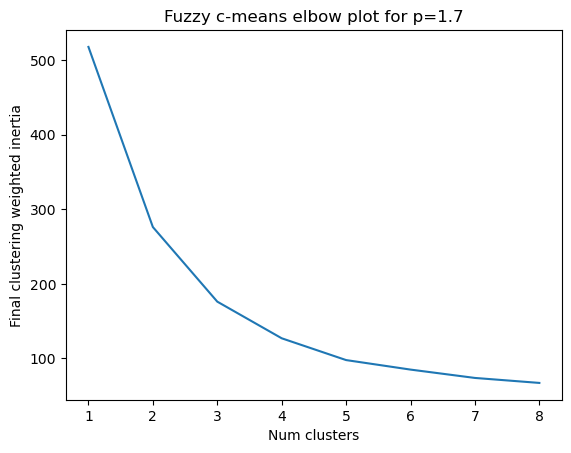

In [31]:
p = 1.7
inertias = []
for c in range(1,9):
    centroids, W, W_0, dist_mat, history, iters, ndpc = cmeans(df_scaled.T, c=c, m=p, error=1e-6, maxiter=20000, seed=100)
    inertias.append(history[len(history) - 1])

plt.plot(range(1,9), inertias)
plt.xlabel('Num clusters')
plt.ylabel('Final clustering weighted inertia')
plt.title(f'Fuzzy c-means elbow plot for p={p}')
plt.show()   

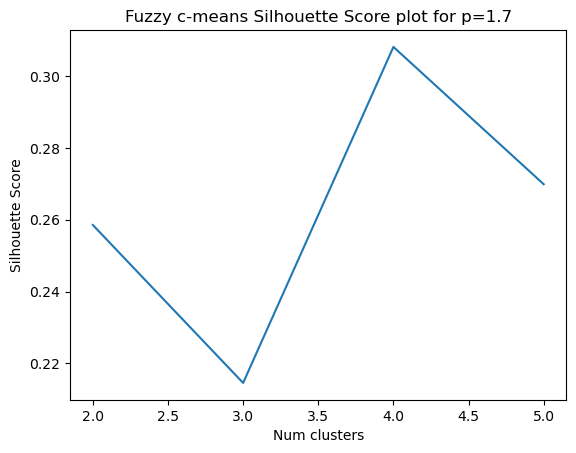

In [32]:
fig.suptitle("Average Silhouette Score For Fuzzy c-Means")
p = 1.7
scores = []
for c in range(2,6):
    centroids, W, W_0, dist_mat, history, iters, ndpc = cmeans(df_scaled.T, c=c, m=p, error=1e-6, maxiter=20000, seed=100)
    cluster_columns = ['Cluster %s Membership score' %(str(i)) for i in range(0,c)]
    df_membership = pd.DataFrame(W.T, columns=cluster_columns)
    partition_cluster_labels = [df_membership.T[i].argmax() for i in range(0, len(df_membership))]
    scores.append(silhouette_score(X, partition_cluster_labels, metric='euclidean'))
plt.plot(range(2,6), scores)
plt.xlabel('Num clusters')
plt.ylabel('Silhouette Score')
plt.title(f'Fuzzy c-means Silhouette Score plot for p={p}')
plt.show()

predicted_cluster
0    18
1    29
2    39
3    51
Name: count, dtype: int64


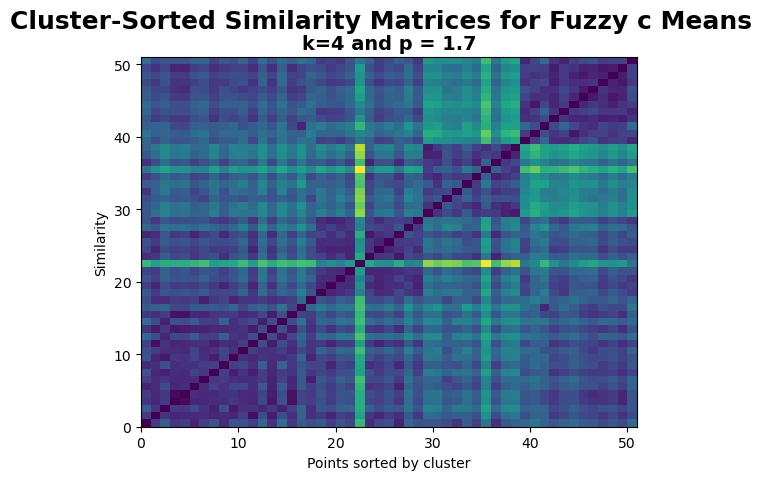

In [33]:
p = 1.7
scores = []
c = 4
centroids, W, W_0, dist_mat, history, iters, ndpc = cmeans(df_scaled.T, c=c, m=p, error=1e-6, maxiter=20000, seed=100)
cluster_columns = ['Cluster %s Membership score' %(str(i)) for i in range(0,c)]
df_membership = pd.DataFrame(W.T, columns=cluster_columns)
partition_cluster_labels = [df_membership.T[i].argmax() for i in range(0, len(df_membership))]
scores.append(silhouette_score(X, partition_cluster_labels, metric='euclidean'))

partition_cluster_labels = [df_membership.T[i].argmax() for i in range(0, len(df_membership))]
df_scaled['partition_cluster_labels'] = partition_cluster_labels
df_sort = df_scaled.sort_values(by='partition_cluster_labels')
df_sort = df_sort.drop(['partition_cluster_labels'], axis=1)
dist_mat = squareform(pdist(df_sort))
im = plt.pcolormesh(dist_mat)
fig.colorbar(im, ax=ax)
N = len(df_sort)
plt.xlabel('Points sorted by cluster')
plt.ylabel('Similarity')
plt.title(f'k={c} and p = {p}', fontweight='bold', fontsize=14)
plt.suptitle('Cluster-Sorted Similarity Matrices for Fuzzy c Means', fontsize=18, fontweight='bold')

print(df2['predicted_cluster'].value_counts().sort_index().cumsum())

### Fuzzy c-Means Best Clustering Algorithm Results Presentation

Fuzzy c-Means was very useful in identifying the inherent clusters we observed in our t-SNE plots. We tried four different fuzziness paramters, and 4 different k values for our number of clusters. A shortcoming that we ran into was that the elbow plots were on the smoother end, making it difficult to select the best number of clusters. Luckily the silhouette score plot had enough corroboration with the t-SNE plots. Based on the elbow, silhouette score, and t-SNE plots, we landed on a fuzziness, p, of 1.7 and 4 clusters. Cluster 3, which consists of primarily southern states, consistently had the lowest usage rate in all of our columns, cluster 1 which contains states like new york and california was consistently the second lowest rates, cluster 0 was the second highest and contained primarily the midwestern and great plains states, while cluster 2 which contained mostly new england has consistently the highest usage ratess.

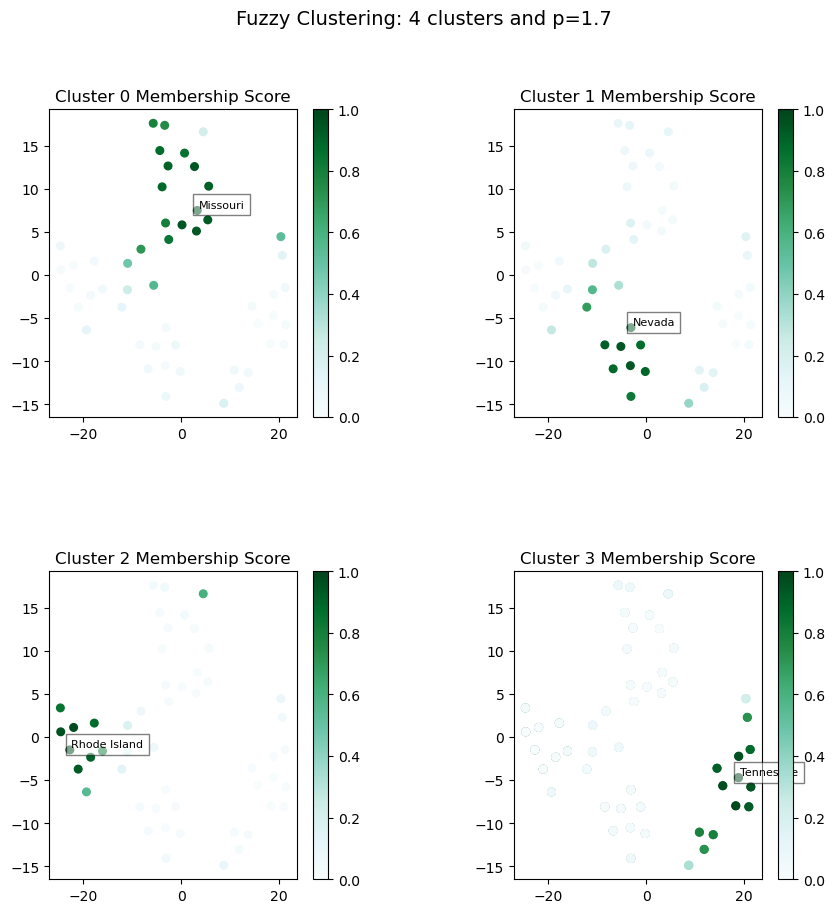

In [34]:
c = 4
p = 1.7

centroids, W, W_0, dist_mat, history, iters, ndpc = cmeans(df_scaled.T, c=c, m=p, error=1e-6, maxiter=20000, seed=100)
fig, ax = plt.subplots(2, 2)
fig.subplots_adjust(hspace = 0.5)
fig.subplots_adjust(wspace = 0.5)
fig.set_figheight(10)
fig.set_figwidth(10)

plt.suptitle('Fuzzy Clustering: %s clusters and p=%s'%(c,p), fontsize = 14)
for i in range(0,c):

    row = i // 2
    col = i % 2

    df_tsne['Cluster %s Membership Score' %str(i)] = W[i,:]

    points = plt.scatter(df_tsne['x'], df_tsne['y'], c = df_tsne['Cluster %s Membership Score' %str(i)], s=30, cmap='BuGn', vmin=0, vmax=1)
    ax[row, col].scatter(df_tsne['x'], df_tsne['y'], c = df_tsne['Cluster %s Membership Score' %str(i)], s=30, cmap='BuGn', vmin=0, vmax=1)
    cluster_max_idx = np.argmax(df_tsne['Cluster %s Membership Score' %str(i)])
    ax[row, col].text(
        x = df_tsne.loc[cluster_max_idx, 'x'] + 0.3, y = df_tsne.loc[cluster_max_idx,'y'] + 0.3,
        s = states[cluster_max_idx],
        fontdict=dict(color='black', size=8), bbox=dict(facecolor='white', alpha=0.5)
    )
    fig.colorbar(points, ax=ax[row, col])
    ax[row, col].set_title('Cluster %s Membership Score' %str(i))

for j in range(c, 2 * 2):
    row = j // 2
    col = j % 2
    fig.delaxes(ax[row, col])

plt.show()


## 10. Discussion

### Clustering Comparison: What was different?
* Were the "best" results from your two clustering algorithms (1 and 2) different?
* To quantify the clustering result differences, calculate and interpret the adjusted rand score
between each pair of "best" clusterings. If one of your clusterings was not a partition-based
clustering, convert it into one.
* In addition, more specifically describe what types of observations were different between
these two clusterings and how they were different. t-SNE plots color-coded by the cluster
labels can help you describe this

**HAC Complete Linkage**

The "best" clusterings from our two algorithms produced very similar results. After our initial data exploration and troubleshooting each of our algorithms, the finalized number of clusters were different where for c-means the ideal k was 4 and for HAC complete linkage the ideal k was 5. After converting the fuzzy c-means clustering to be partitional-based, we calculated the adjusted rand score between our "best" HAC Complete Linkage clustering and our "best" Fuzzy C-Means clustering and got the value 0.813. This value is closer to 1 than 0 and therefore tells us that there is strong agreement between the two resulting clusters for each algorithm. 

To visualize this, we created t-SNE plots corresponding to the predicted cluster labels for each algorithm. Based on this side-by-side comparison, we found that only 5 points from our dataset had different assignments. After labelling these points based on the pre-assigned state labels, we saw that the differing points were Oregon, Connecticut, District of Columbia, Utah, and Kentucky. For HAC Complete Linkage, Oregon, Connecticut, and District of Columbia were assigned to the cluster on the bottom left hand side while Fuzzy C-Means assigned it to the cluster to the right of it. Additionally, in HAC Complete Linkage, Kentucky was assigned to the top cluster while Fuzzy C-means assigned it to the bottom right-hand side cluster.

In our initial data exploration, we identified one significant outlier: Utah. In the fuzzy c-means results, Utah was merged into a nearby larger cluster, whereas in HAC complete linkage it formed a singleton cluster. This difference helps explain why the two methods selected different values for the optimal number of clusters, where each algorithm handled the Utah outlier differently.

The remaining data points that varied between each algorithm were most likely a result of poorly separated inherent clusters. We see an apparent lack of separation in our tSNE plot as well as in our fuzzy c-means membership scores.

In [35]:
partition_cluster_labels = [W.T[i].argmax() for i in range(0, len(W.T))]
partition_cluster_labels

df_combo = df.copy()
df_combo["predicted_cluster_fcm"] = partition_cluster_labels

k = 5
hac = AgglomerativeClustering(n_clusters=k, metric="euclidean", linkage="complete")
df_combo["predicted_cluster_hac"] = hac.fit_predict(X_scaled)

ars = adjusted_rand_score(df_combo["predicted_cluster_hac"], df_combo["predicted_cluster_fcm"])
print('Adjusted Rand Score', ars)

Adjusted Rand Score 0.8130346232179226


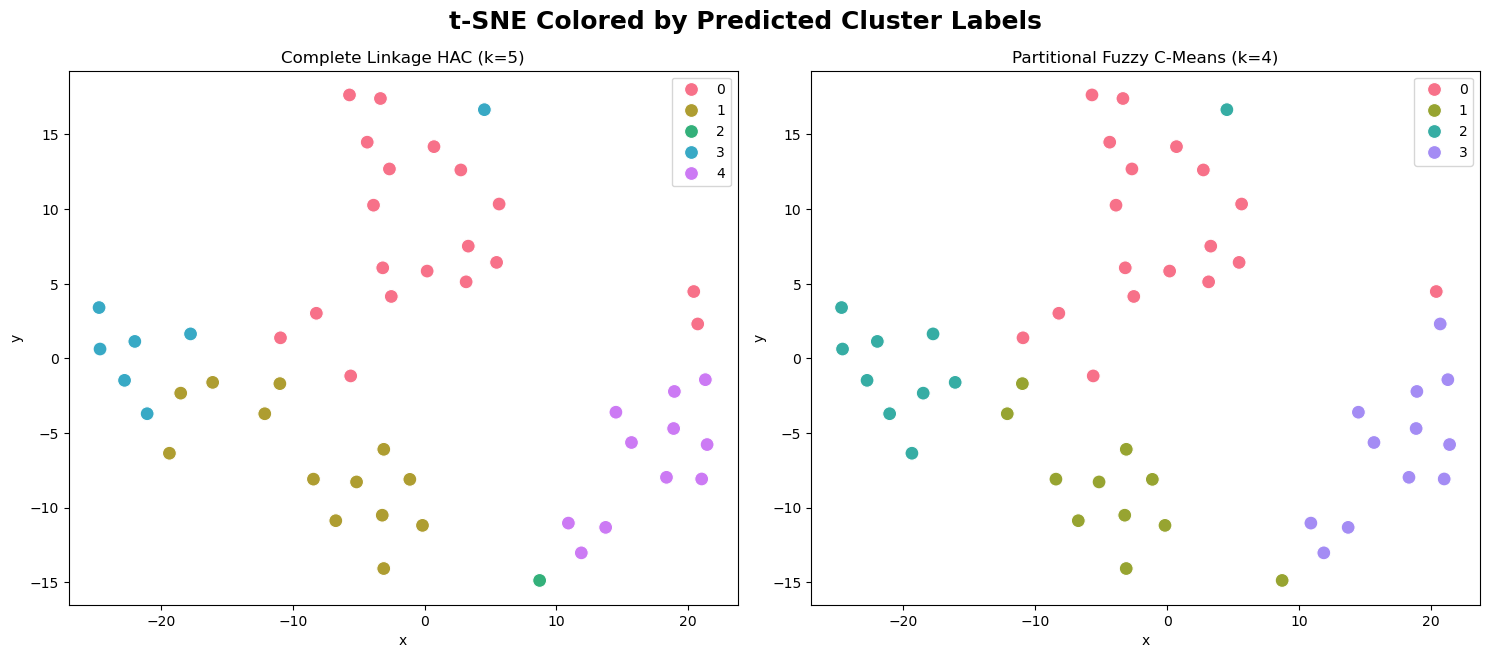

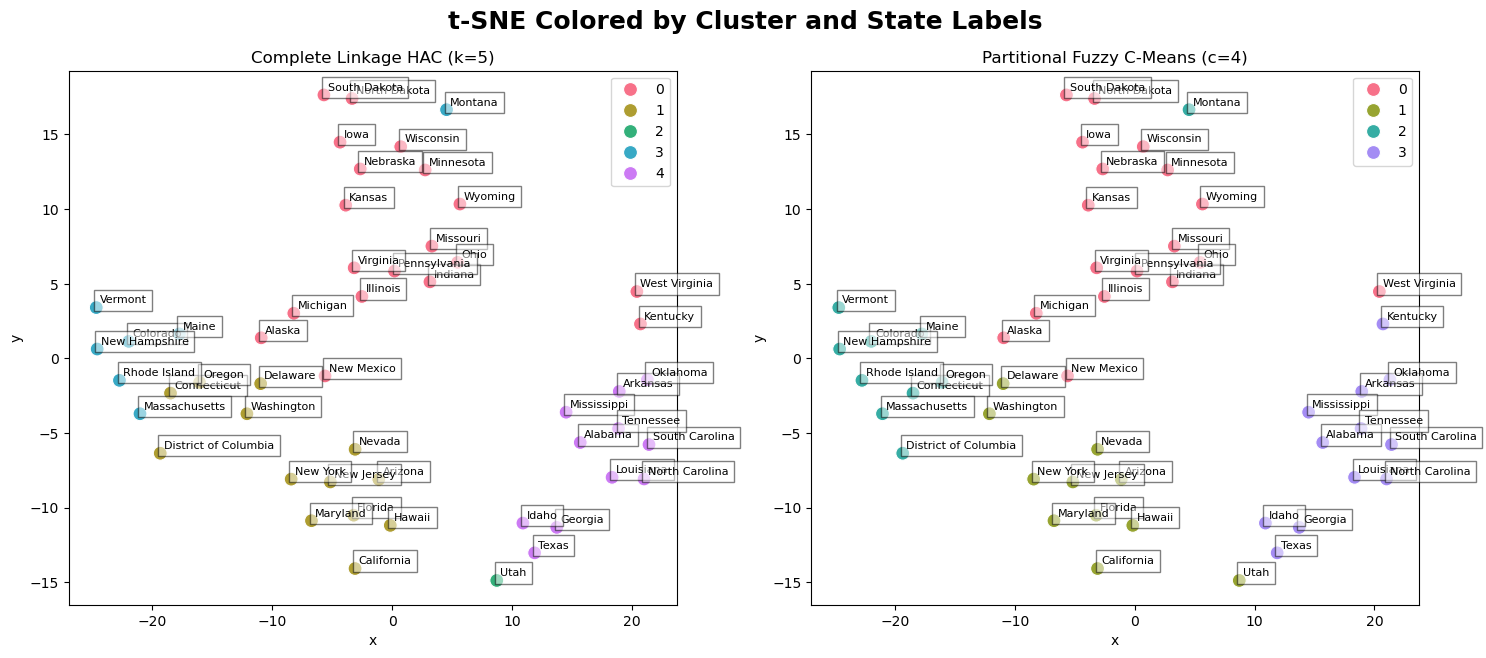

In [39]:
k = 5
hac = AgglomerativeClustering(n_clusters=k, metric="euclidean", linkage="complete")
predicted_cluster_hac = hac.fit_predict(X_scaled)
c = W.shape[0]
predicted_cluster_fcm = [W.T[i].argmax() for i in range(0, len(W.T))]
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10*(2/3)))
sns.scatterplot(
    x="x", y="y", hue=predicted_cluster_hac,
    palette=sns.color_palette("husl", k), data=df_tsne, ax=ax0, s=100
)
ax0.set_title(f"Complete Linkage HAC (k={k})")
sns.scatterplot(
    x="x", y="y", hue=predicted_cluster_fcm,
    palette=sns.color_palette("husl", c), data=df_tsne, ax=ax1, s=100
)
ax1.set_title(f"Partitional Fuzzy C-Means (k={c})")
fig.suptitle("t-SNE Colored by Predicted Cluster Labels", fontsize=18, fontweight="bold")
fig.tight_layout()
plt.show()
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10*(2/3)))
sns.scatterplot(
    x="x", y="y", hue=predicted_cluster_hac, palette=sns.color_palette("husl", k), data=df_tsne, ax=ax0, s=100
)
for i in range(df_tsne.shape[0]):
    ax0.text(
        x=df_tsne.loc[i, "x"] + 0.3, y=df_tsne.loc[i, "y"] + 0.3, s=states[i],
        fontdict=dict(color="black", size=8), bbox=dict(facecolor="white", alpha=0.5)
    )
ax0.set_title(f"Complete Linkage HAC (k=5)")

sns.scatterplot(
    x="x", y="y", hue=predicted_cluster_fcm, palette=sns.color_palette("husl", c), data=df_tsne, ax=ax1, s=100
)
for i in range(df_tsne.shape[0]):
    ax1.text(
        x=df_tsne.loc[i, "x"] + 0.3, y=df_tsne.loc[i, "y"] + 0.3, s=states[i],
        fontdict=dict(color="black", size=8), bbox=dict(facecolor="white", alpha=0.5)
    )
ax1.set_title(f"Partitional Fuzzy C-Means (c=4)")
fig.suptitle("t-SNE Colored by Cluster and State Labels", fontsize=18, fontweight="bold")
fig.tight_layout()
plt.show()

### "Best Clustering(s)"

Out of ALL of the clusterings that you have explored (from Algorithm 1 and 2), which clustering(s) do you think provide the strongest evidence that you have:
* identified all of the inherent clusters
* are the most informative
* and are most in alignment with your stated research goals and motivations (ex: outlier
handling)?
Explain your answer.

### Different Clustering Insights

* Does clustering algorithm #1 reveal any insights about the data that algorithm #2 does not?
If so, what are they?
* Does clustering algorithm #2 reveal any insights about the data that algorithm #1 does not?
If so, what are they?

**HAC Complete Linkage**

Clustering algorithm #1 provides insight into significant outliers that might warp our predicted cluster labels. Although Complete Linkage is known to be incredibly robust to outliers, it still produced a singleton cluster for Utah because it's drug rates were very different from the rest of the states within the Drugs dataset. This distinction can be valuable for legislators and other policy makers because it highlights the states that may need more unique intervention rather than being lumped into a group of states with different drug use patterns.

### Additional "Best" Clustering(s) Exploration
For each of your "best" overall clustering(s) that you selected above you should also use
cluster sorted similarity matrices to answer the following questions to describe the
clusterings further.

Separation: Summarize the distances between the clusters.
* Are there clusters that are much further away from the others? Which ones?
* Are there clusters that are much closer to other clusters? Which ones?
Sparsity: Summarize the sparsity of he clusters.
* Are there clusters that are more dense than others? Which ones?
* Are there clusters that are more sparse than others? Which ones?

**ANSWER**

For algorithm #1 (HAC Complete Linkage), 

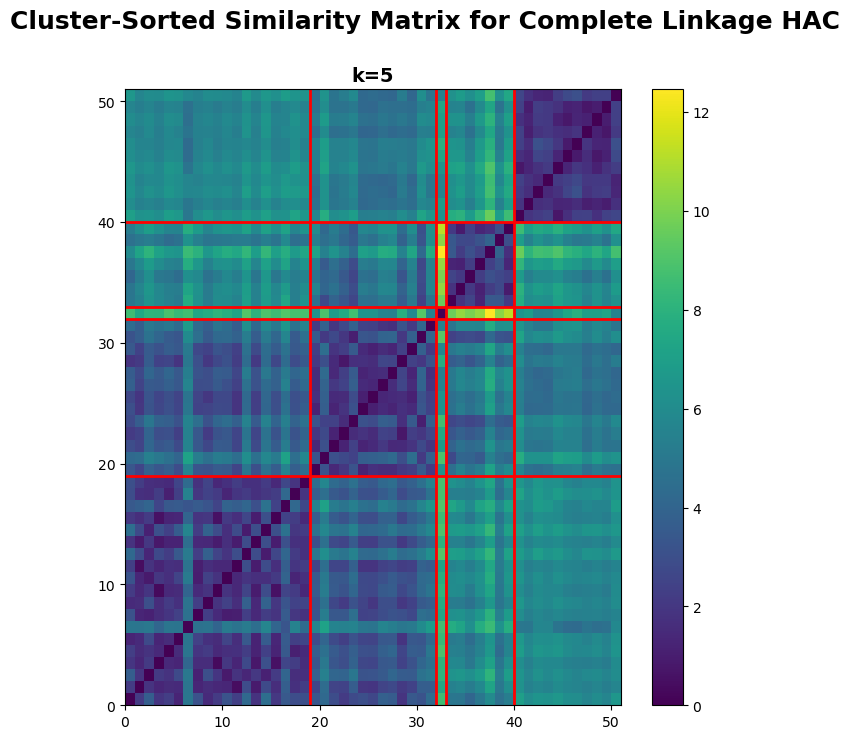

In [37]:
k = 5

hac = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='complete')
labels = hac.fit_predict(X_scaled)

df_sort = df_scaled.copy()
df_sort[f'predicted_cluster_k{k}'] = labels
df_sort = df_sort.sort_values(f'predicted_cluster_k{k}', ascending=True)

dist_mat = squareform(pdist(df_sort.select_dtypes([int, float])))
bounds = np.flatnonzero(np.diff(df_sort[f'predicted_cluster_k{k}'].to_numpy())) + 1

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.pcolormesh(dist_mat)
fig.colorbar(im, ax=ax)
ax.vlines(bounds, 0, len(df_sort), colors='red', lw=2)
ax.hlines(bounds, 0, len(df_sort), colors='red', lw=2)
ax.set_title(f'k={k}', fontweight='bold', fontsize=14)

fig.suptitle('Cluster-Sorted Similarity Matrix for Complete Linkage HAC', fontsize=18, fontweight='bold')
plt.show()

### Additional "Best" Clustering(s) Attribute Descriptions
For each of your "best" clusterings that you selected above you should describe what
attributes characterize each of the clusters that you found.
[QUALITIATIVELY, THIS IS THE MOST IMPORTANT PART OF THE PROJECT!]

Describing Each of the Clusters

Finally, describe what type of attribute values and attribute relationships characterize each of
the resulting clusters in your final clustering. You can choose at least one of these options (or
pick multiple options to learn more).
• Option 1 (don’t use this if your dataset is an image dataset):
* Create a side-by-side boxplots visualization for each numerical attribute in your dataset
(where each cluster label is given a boxplot).
* Create a side-by-side barplot visualization for each categorical attribute in your dataset
(where each cluster label appears on the x-axis).


o Use these plots to thoroughly describe which type of attribute values characterize each of
the resulting clusters in your final clustering.
Ex: Cluster 1 is characterized by low crime, high pollution, etc.
Cluster 2 is characterized by high crime, medium pollution.
You should only leave an attribute out of your descriptions if there is NO association
between that attribute and the cluster labels (ie. there is no pair of IQR boxes that don't
overlap).

**HAC Complete Linkage**

One cluster from our HAC Complete Linkage clustering is comprised of moderate alcohol use disorder in the past year and alcohol use in the past month, moderate to high tobacco (cigarette) use in the past month, low cocaine use in the past year, moderate new marijuana use, low marijuana use in the past month, low marijuana use in the past year, and moderate to high tobacco use in the past month.

Another cluster from our HAC Complete Linkage clustering is comprised of moderate alcohol use disorder in the past year and alcohol use in the past month, low tobacco (cigarette) use in the past month, moderate cocaine use in the past year, moderate new marijuana use, moderate marijuana use in the past month, moderate marijuana use in the past year, and low tobacco use in the past month.

Another cluster from our HAC Complete Linkage clustering is comprised of low alcohol use disorder in the past year and alcohol use in the past month, low tobacco (cigarette) use in the past month, moderate cocaine use in the past year, low new marijuana use, low marijuana use in the past month, low marijuana use in the past year, and low tobacco use in the past month.

Another cluster from our HAC Complete Linkage clustering is comprised of high alcohol use disorder in the past year and alcohol use in the past month, moderate tobacco (cigarette) use in the past month, high cocaine use in the past year, high new marijuana use, high marijuana use in the past month, high marijuana use in the past year, and moderate tobacco use in the past month.

The remaining cluster from our HAC Complete Linkage clustering is comprised of low alcohol use disorder in the past year, moderate alcohol use in the past month, moderate tobacco (cigarette) use in the past month, low cocaine use in the past year, low new marijuana use, low marijuana use in the past month, low marijuana use in the past year, and moderate tobacco use in the past month.

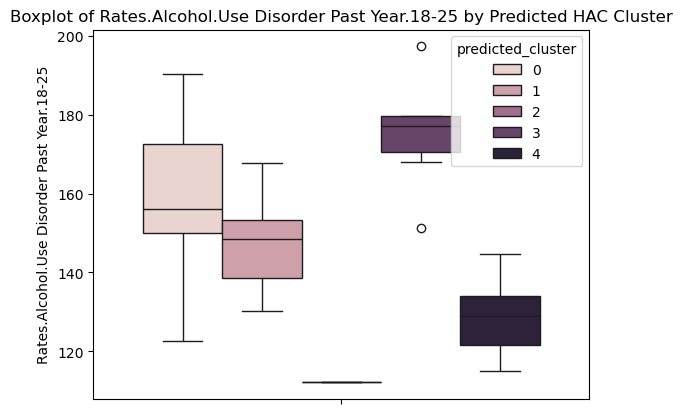

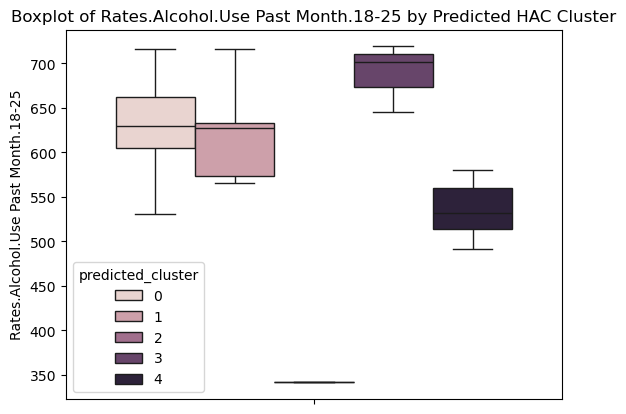

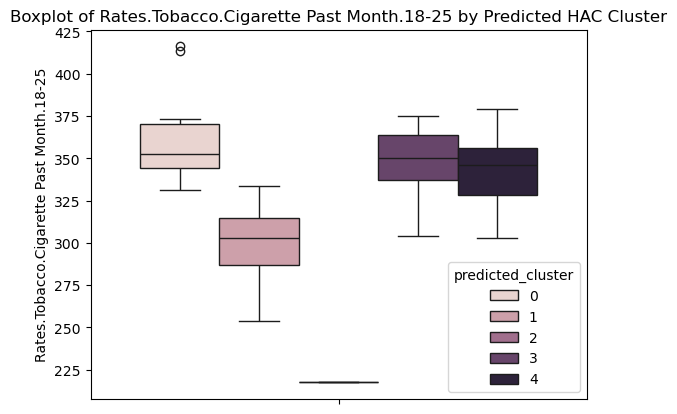

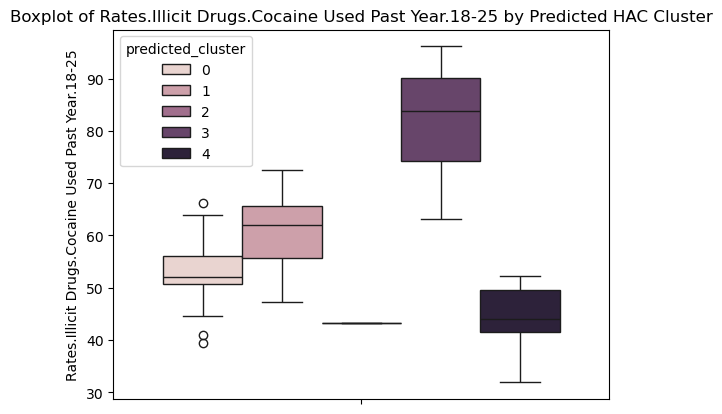

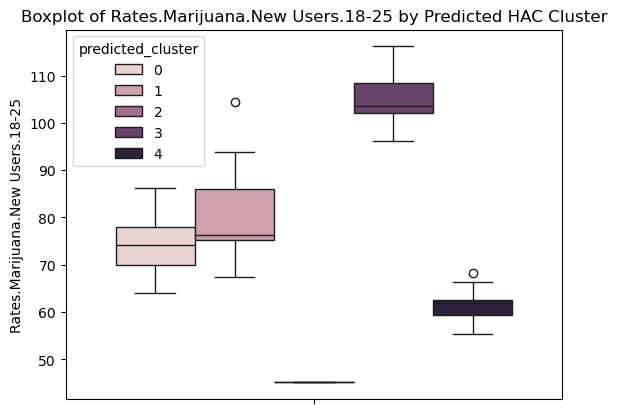

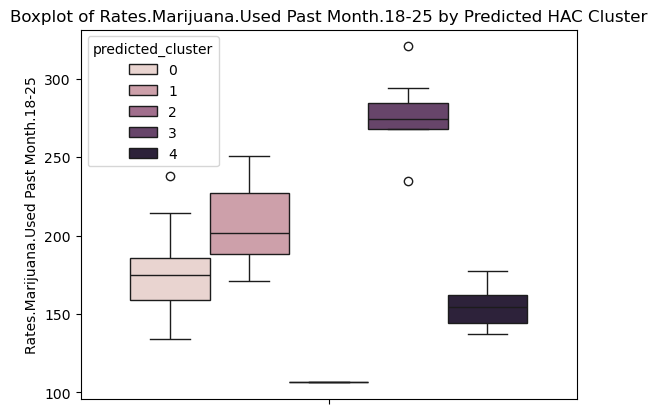

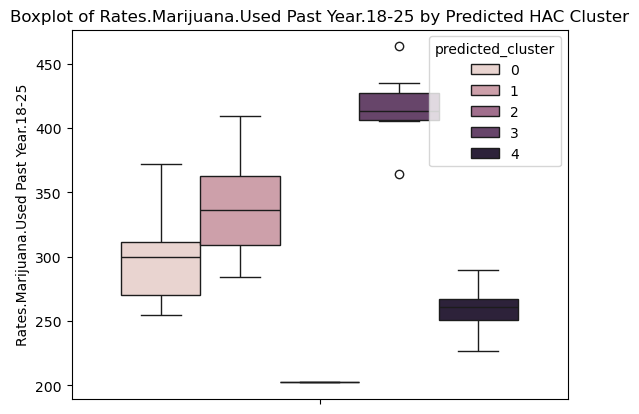

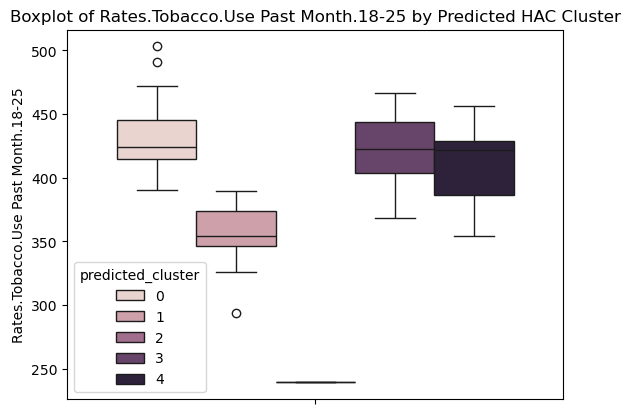

In [38]:
k = 5
hac = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='complete')
predicted_cluster_labels = hac.fit_predict(X_scaled)

df2 = df.copy()
df2["predicted_cluster"] = predicted_cluster_labels

for column in df2.columns.tolist():
    if column == "State" or column == "predicted_cluster":
        continue
    else:
        sns.boxplot(
            data=df2,
            y=column,
            hue="predicted_cluster"
        )
        plt.title("Boxplot of %s by Predicted HAC Cluster"%(column))
        plt.show()

## 11. Conclusion

### Summarize
Briefly summarize what you did in this report and what your key findings were

### Recommendation
* Based on your analyses above, would you recommend that any of the insights that you
extracted be used by the person/application discussed in your research motivation? Why or
why not?
* If so, how might they use these insights? Be specific.

### Shortcomings/Caveats
Discuss any other shortcomings to your analysis here (all analyses have SOME
shortcomings).

Since we aggregated each row of our dataset by state and averaged across the years 2002 to 2018, we lose the ability to make meaningful year-to-year comparisons. Policy makers might want the most up-to-date state comparisons to effectively change funding or drug programs based on the current drug use rates rather than the historical averages. Our study also only features drug use rates which omits many other factors such as income that could contribute to our understanding of the similarities/differences in each predicted cluster. Additionally, there are some shortcomings involved in survey responses in general. For this specific dataset, the sampling population excludes individuals that were at the time in prison or jail, service members on active duty, and people who were not residing in a home or shelter. This creates limitations on the accuracy of our drug use rate estimates for each state, especially for states that have lower populations. Lastly, in unsupervised learning, the true cluster structure is unknown and therefore the results found in our analysis are not the one and only "truth". What our analysis can provide is a deeper understanding of the overall structure of the dataset that is backed by multiple algorithms and data visualization techniques.

### Future Work
Based on what you observed in your analysis, what are some ideas you might have for
future work?

Possible suggestions that might add additional meaning or better comparisons for each state would be including other attributes, broadening the sampling population, and allowing for more granular time-based comparisons. It could be beneficial to add other attributes such as income, education levels, and other relevant factors that may be correlated to higher or lower drug abuse rates. This allows more insight for policy makers because they can enact changes other than revising drug abuse programs and funding. If high/low education levels are associated with high/low drug use rates, it might be useful to address problems involving educational funding or access to higher education. As discussed in the previous section, there are also some shortcomings involving the sampling population of our dataset. It could benefit future research if more populations were included to improve the accuracy of the drug rate estimates. There are also some downsides to our data processing techniques, specifically how we averaged across the years. For the future, researchers can gain additional insight by looking at each specific year to spot any significant changes that occur. This could be paired with further research in historical state-wide adjustments in funding or programs to basically gain a sense of what worked or what didn't work over time and what can be done in the future. Overall, we gained an insightful but limited understanding of the similarities and differences in U.S. states drug use rates.

## References

CORGIS Datasets Project. (2021). Drugs CSV File. https://corgis-edu.github.io/corgis/csv/drugs/

Substance Abuse and Mental Health Services Administration. (2025). Know the risks of using drugs. https://www.samhsa.gov/substance-use/learn/risks